# ORIE 4741 - Exploring Wine

In [1]:
# Here we import everything we need to explore our data.

import pandas as pd
import numpy as np
import scipy.stats as scipy
import scipy.linalg
import matplotlib.pyplot as py
import matplotlib
import random
%matplotlib inline

## Importing our Data

#### Our first approach was to import data using python’s pandas.read_csv

#### Issues

The first issue we ran into occurred when we inspected our raw data in Excel. We noticed that many of the foreign characters such as ‘é’ were not being displayed properly in our imported dataset (see Figure 1.1). This concerned us because the interpretability of the dataset was difficult for potential readers and us; however, after some research on UnicodeDecodeError’s (such as the one given below), we found the problem to be that Excel expected characters to be encoded as UTF-8*. The incorrect outputs were a result of UTF-8 only including ASCII characters; however, our data had a significant amount of non-ASCII characters. 

UnicodeDecodeError: 'utf8' codec can't decode byte 0xa5 in position 0: invalid start byte

*UTF-8 is a character encoding capable of encoding all 1,112,064 valid code points in Unicode using one to four 8-bit bytes.

#### Examples of some issues

See Table in Latex File (Figure 1.1)

#### Initial attempts to fix the encoding issues

We initially tried changing the file type and even starting writing code to replace strange character sequences. This process was labor intensive and took way too long. Then we thought it would make sense to simply remove the data containing any foreign characters and in doing so, learned our dataset was biased towards non-foreign wines and reviews. 

1. Tried changing the excel file’s character encoding.
2. Tried changing the .csv file’s character encoding.
3. Tried using “Apple Numbers” (an excel equivalent) to see if we could encode foreign characters.
4. Tried using Business Intelligence software (Microsoft Power BI) to identify and replace character patterns with an ASCII equivalent (i.e., changing ‘Ã©’ which was supposed to be an ‘é’ to ‘e’). This was time intensive and was not a practical approach.
5. Tried reading the dataset into a .ipynb using Python’s pandas.read_csv; However, one main issue we had was the presence of commas in reviews. This caused our data to transform the fields of those particular examples from the expected 11 fields to over 140. We recognize this transformation as an error in read_csv and our data which added onto our foreign language issues.

#### Understanding our root problem

Our root problem was the character encoding of a .csv file in which our data was stored. 

#### Our solution

We ended up using .json files instead of .csv to store our data. This type of file does not allow us to examine our raw data in Excel, but when importing the file into the .ipynb notebook we found that the method pandas.read_json read-in foreign languages efficiently and accurately without causing the fields to expand or transform. This was mainly a benefit of how .json files structure and store data in defined fields while also including the correct encodings for reading numbers as Float64 rather than strings. 


In [2]:
df = pd.read_json('/Users/alexanderdowney/Downloads/winemag-data_first150k.json')

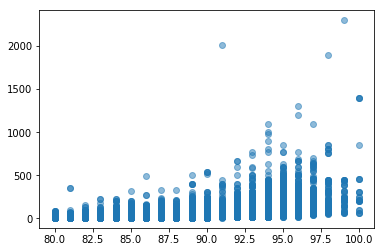

In [3]:
py.scatter(df['points'],df['price'],alpha=0.5)
py.show()
size_of_dataset=[]
size_of_dataset.append(len(df))

In [4]:
df_store=df

### First Step of Cleaning the Dataset 

We noticed that we had some "odd" countries that we didn't expect to see. Also they had a very limited amount of data points and thus would not be helpful in predicting prices for more "common" countries. 

In [5]:
countries = df['country'].unique()
country_count=[]
countries_kept = []
for i in range(0,len(countries)):
    country_count.append(len(df.loc[df['country'] == countries[i]]))
    print(countries[i],len(df.loc[df['country'] == countries[i]]))
for j in range(0,len(countries)):
    if country_count[j]>500:
        countries_kept.append(countries[j])
df = df[df['country'].isin(countries_kept)]
size_of_dataset.append(len(df))

US 62397
Spain 8268
France 21098
Italy 23478
New Zealand 3320
Bulgaria 77
Argentina 5631
Australia 4957
Portugal 5322
Israel 630
South Africa 2258
Greece 884
Chile 5816
Morocco 12
Romania 139
Germany 2452
Canada 196
Moldova 71
Hungary 231
Austria 3057
Croatia 89
Slovenia 94
None 0
India 8
Turkey 52
Macedonia 16
Lebanon 37
Serbia 14
Uruguay 92
Switzerland 4
Albania 2
Bosnia and Herzegovina 4
Brazil 25
Cyprus 31
Lithuania 8
Japan 2
China 3
South Korea 4
Ukraine 5
England 9
Mexico 63
Georgia 43
Montenegro 2
Luxembourg 9
Slovakia 3
Czech Republic 6
Egypt 3
Tunisia 2
US-France 1


### Removing NaN's from our points & price columns

Examining our data some more we realize we have some values in price (our output vector) which are NaN. See index 150922 for an example. We proceed to remove these values.

We selected only the points and price columns as a means for identifying NaNs to remove. Our rationale for only using these columns is some wines have more detailed regions and sub-regions vs others, this is not a data entry error but simply due to industry structure and classification systems. 

In [6]:
## Look at the NaN at 150922!
df['price']

0         235.0
1         110.0
2          90.0
3          65.0
4          66.0
5          73.0
6          65.0
7         110.0
8          65.0
9          60.0
10         80.0
11         48.0
12         48.0
13         90.0
14        185.0
15         90.0
16        325.0
17         80.0
18        290.0
19         75.0
20         24.0
21         79.0
22        220.0
23         60.0
24         45.0
25         57.0
26         62.0
27        105.0
28         60.0
29         60.0
          ...  
150900     13.0
150901     12.0
150902     10.0
150903      7.0
150904     10.0
150905     13.0
150906     65.0
150907     52.0
150908     65.0
150909     52.0
150910     38.0
150911     37.0
150912     65.0
150913     30.0
150914     25.0
150915     30.0
150916     65.0
150917     30.0
150918     38.0
150919     37.0
150920     19.0
150921     38.0
150922      NaN
150923     30.0
150924     70.0
150925     20.0
150926     27.0
150927     20.0
150928     52.0
150929     15.0
Name: price, Length: 149

In [7]:
df = df[np.isfinite(df['price'])]
df = df[np.isfinite(df['points'])]

### Exploring our Data some more by finding implict price distributions

This is fitting a t-distribution to the Price data

Moments MVSK are as follows: 23.57478531143802 inf nan nan



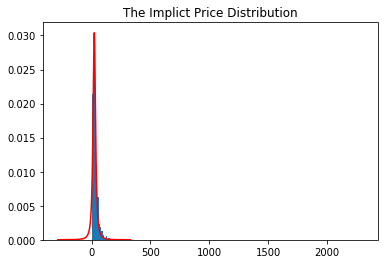

In [8]:
print("This is fitting a t-distribution to the Price data")
print()
dfd, loc, scale = (scipy.stats.t.fit(df['price']))
mean, var, skew, kurt = scipy.stats.t.stats(dfd, loc, scale, moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)
print()
x = np.linspace(scipy.stats.t.ppf(0.001, dfd, loc, scale),scipy.stats.t.ppf(0.999, dfd, loc, scale), 1000)
py.plot(x, scipy.stats.t.pdf(x, dfd, loc, scale),'r-')
py.hist(df['price'],bins=200,normed=1)
py.title('The Implict Price Distribution')
py.show()

This is fitting a exponential-distribution to the Price data

Moments MVSK are as follows: 33.19055303064944 852.088386243031 2.0 6.0


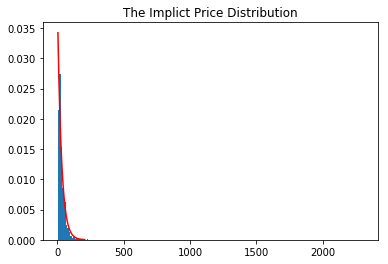

In [9]:
print("This is fitting a exponential-distribution to the Price data")
print()
dfd, loc = (scipy.stats.expon.fit(df['price']))
mean, var, skew, kurt = scipy.stats.expon.stats(dfd, loc,moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)

x = np.linspace(scipy.stats.expon.ppf(0.001, dfd, loc),scipy.stats.expon.ppf(0.999, dfd, loc), 1000)
py.plot(x, scipy.stats.expon.pdf(x, dfd, loc),'r-')
py.hist(df['price'],bins=200,normed=1)
py.title('The Implict Price Distribution')
py.show()

### Looking at the points distribution

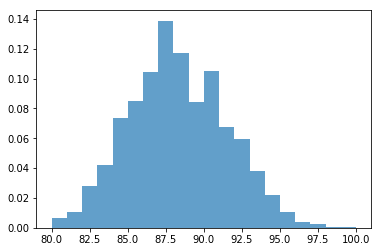

In [10]:
py.hist(df['points'],bins=20,normed=1,alpha=0.7)
py.show()

This is fitting a normal-distribution to the Points data

Moments MVSK are as follows: 87.80164814951071 10.368441106721427 0.0 0.0



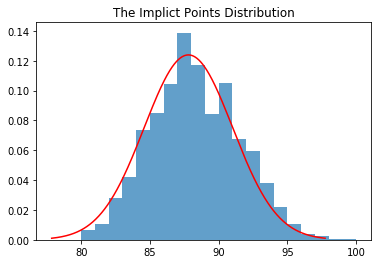

In [11]:
print("This is fitting a normal-distribution to the Points data")
print()
dfd, loc = (scipy.stats.norm.fit(df['points']))
mean, var, skew, kurt = scipy.stats.norm.stats(dfd, loc, moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)
print()
x = np.linspace(scipy.stats.norm.ppf(0.001, dfd, loc),scipy.stats.norm.ppf(0.999, dfd, loc), 1000)
py.plot(x, scipy.stats.norm.pdf(x, dfd, loc),'r-')
py.hist(df['points'],bins=20,normed=1,alpha=0.7)
py.title('The Implict Points Distribution')
py.show()

This is fitting a t-distribution to the Points data

Moments MVSK are as follows: 87.80147021535227 10.3684263499024 0.0 9.579444076054575e-07



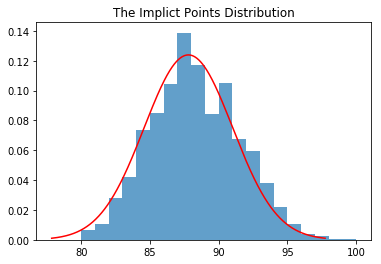

In [12]:
print("This is fitting a t-distribution to the Points data")
print()
dfd, loc, scale = (scipy.stats.t.fit(df['points']))
mean, var, skew, kurt = scipy.stats.t.stats(dfd, loc, scale, moments='mvsk')
print("Moments MVSK are as follows:",mean, var, skew, kurt)
print()
x = np.linspace(scipy.stats.t.ppf(0.001, dfd, loc, scale),scipy.stats.t.ppf(0.999, dfd, loc,scale), 1000)
py.plot(x, scipy.stats.t.pdf(x, dfd, loc,scale),'r-')
py.hist(df['points'],bins=20,normed=1,alpha=0.7)
py.title('The Implict Points Distribution')
py.show()

### Exploring the Average Price per Country

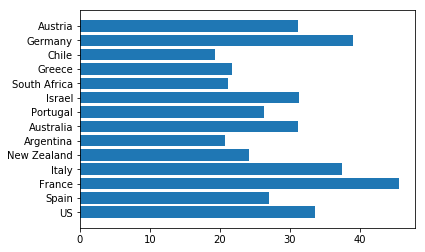

In [13]:
Average_Price_Per_Region=[]
for i in range(0,len(countries_kept)):
    Average_Price_Per_Region.append(np.mean(df.loc[df['country'] == countries_kept[i]]['price']))

y_pos = np.arange(len(Average_Price_Per_Region))
py.barh(y_pos, Average_Price_Per_Region, align='center')
py.yticks(y_pos, countries_kept)
py.show()

### Exploring the Average Points per Country

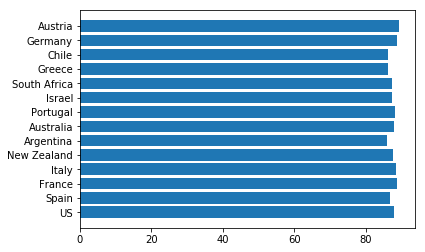

In [14]:
Average_Points_Per_Region=[]
for i in range(0,len(countries_kept)):
    Average_Points_Per_Region.append(np.mean(df.loc[df['country'] == countries_kept[i]]['points']))

y_pos = np.arange(len(Average_Points_Per_Region))
py.barh(y_pos, Average_Points_Per_Region, align='center')
py.yticks(y_pos, countries_kept)
py.show()

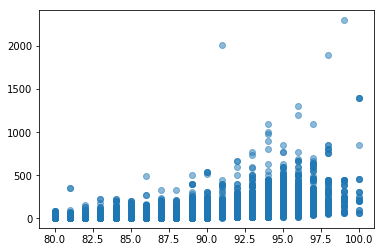

In [15]:
py.scatter(df['points'],df['price'],alpha=0.5)
py.show()
size_of_dataset=[]
size_of_dataset.append(len(df))

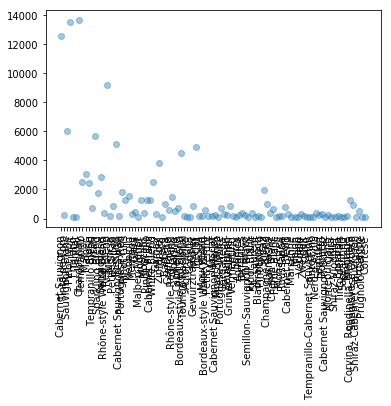

In [16]:
amount_of_varieties = len(df['variety'].unique())
varietal = df['variety'].unique()
varietals = []
amount_of_each_variety = []
fig, ax = py.subplots()
Tol = 74


for i in range(0,amount_of_varieties):
    if len(df.loc[df['variety'] == varietal[i]]) > Tol:
        amount_of_each_variety.append(len(df.loc[df['variety'] == varietal[i]]))
        varietals.append(varietal[i])
py.scatter(np.arange(len(varietals)),amount_of_each_variety,alpha=0.4)
ax.set_xticklabels(varietals)
py.xticks(np.arange(len(varietals)),varietals,rotation='vertical')
py.show()

In [17]:
print("The median price of wine in our data set is",np.median(amount_of_each_variety))

The median price of wine in our data set is 310.5


In [18]:
print("We have",np.size(varietals),"varietals in our cleaned data set")

We have 100 varietals in our cleaned data set


In [19]:
df = df[df['variety'].isin(varietals)]
size_of_dataset.append(len(df))

In [20]:
countries_kpt = df['country'].unique()
dummy = pd.get_dummies(df['country'])
country_dummy = []
for i in range(0,len(df['country'].unique())):
    country_dummy.append(dummy[countries_kpt[i]])

In [21]:
X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],np.ones(len(df['points']))]
y = df['price'].as_matrix()
X[0], y[0]
print(X)
X_points = df[['points']].as_matrix()
X_points= np.c_[X_points,np.ones(len(df['points']))]
y = df['price'].as_matrix()
X[0], y[0]

X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],np.ones(len(df['points']))]
y = df['price'].as_matrix()
X[50], y[50]


[[ 96.   1.   0. ...,   0.   0.   1.]
 [ 96.   0.   1. ...,   0.   0.   1.]
 [ 96.   1.   0. ...,   0.   0.   1.]
 ..., 
 [ 91.   0.   0. ...,   0.   0.   1.]
 [ 90.   0.   0. ...,   0.   0.   1.]
 [ 90.   0.   0. ...,   0.   0.   1.]]


(array([ 90.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]), 18.0)

In [22]:
np.linalg.lstsq(X,y)[0]

array([  5.09496473e+00,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
         2.36331863e+12,   2.36331863e+12,   2.36331863e+12,
        -2.36331863e+12])

In [23]:
m,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,c = np.linalg.lstsq(X,y)[0]
print(np.linalg.lstsq(X,y)[0])
w,c1 = np.linalg.lstsq(X_points,y)[0]
print(np.linalg.lstsq(X_points,y)[0])

[  5.09496473e+00   2.36331863e+12   2.36331863e+12   2.36331863e+12
   2.36331863e+12   2.36331863e+12   2.36331863e+12   2.36331863e+12
   2.36331863e+12   2.36331863e+12   2.36331863e+12   2.36331863e+12
   2.36331863e+12   2.36331863e+12   2.36331863e+12  -2.36331863e+12]
[   5.24996669 -427.5377278 ]


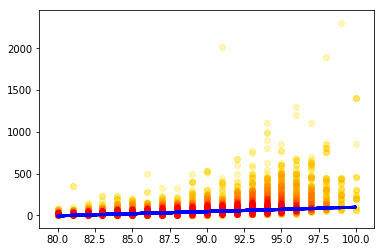

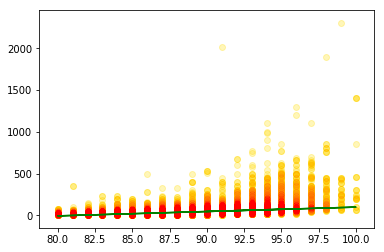

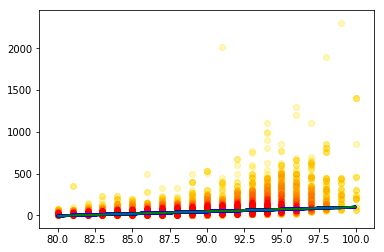

In [24]:
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+c,'b')
py.show()
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],w*df['points']+c1,'g')
py.show()
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+c,'b')
py.plot(df['points'],w*df['points']+c1,'g')
py.show()

In [25]:
error = w*df['points']+c1-(m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+m3+c)
print("How many data points does the simple regression predict a higher price?",len(np.where(error>0)[0]))
np.mean(error)
np.std(error)

How many data points does the simple regression predict a higher price? 0


4.371160453520204

# Feature engineering for variety

In [26]:
varieties_kpt = df['variety'].unique()
dummy_variety = pd.get_dummies(df['variety'])
country_variety = []
for i in range(0,len(df['variety'].unique())):
    country_variety.append(dummy_variety[varieties_kpt[i]])

# Decision Trees

In [27]:
from sklearn import tree
import graphviz

In [28]:
X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],country_variety[0],country_variety[1],country_variety[2],country_variety[3],country_variety[4],country_variety[5],country_variety[6],country_variety[7],country_variety[8],country_variety[9],country_variety[10],country_variety[11],country_variety[12],country_variety[13],country_variety[14],country_variety[15],country_variety[16],country_variety[17],country_variety[18],country_variety[19],country_variety[20],country_variety[21],country_variety[22],country_variety[23],country_variety[24],country_variety[25],country_variety[26],country_variety[27],country_variety[28],country_variety[29],country_variety[30],country_variety[31],country_variety[32],country_variety[33],country_variety[34],country_variety[35],country_variety[36],country_variety[37],country_variety[38],country_variety[39],country_variety[40],country_variety[41],country_variety[42],country_variety[43],country_variety[44],country_variety[45],country_variety[46],country_variety[47],country_variety[48],country_variety[49],country_variety[50],country_variety[51],country_variety[52],country_variety[53],country_variety[54],country_variety[55],country_variety[56],country_variety[57],country_variety[58],country_variety[59],country_variety[60],country_variety[61],country_variety[62],country_variety[63],country_variety[64],country_variety[65],country_variety[66],country_variety[67],country_variety[68],country_variety[69],country_variety[70],country_variety[71],country_variety[72],country_variety[73],country_variety[74],country_variety[75],country_variety[76],country_variety[77],country_variety[78],country_variety[79],country_variety[80],country_variety[81],country_variety[82],country_variety[83],country_variety[84],country_variety[85],country_variety[86],country_variety[87],country_variety[88],country_variety[89],country_variety[90],country_variety[91],country_variety[92],country_variety[93],country_variety[94],country_variety[95],country_variety[96],country_variety[97],country_variety[98],country_variety[99],np.ones(len(df['points']))]
Y = df['price'].as_matrix()
clf = tree.DecisionTreeClassifier(max_depth=20)
clf = clf.fit(X, Y)
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

[  3.16859871e+04   1.98463449e+02   1.32098339e+02   1.16569165e+02
   1.15188661e+02   1.03449519e+02   9.88610174e+01   9.06486597e+01
   8.62492118e+01   8.10278821e+01   7.97747512e+01   7.57872886e+01
   7.35137261e+01   7.24034428e+01   7.10728204e+01   6.57719686e+01
   6.29665175e+01   5.67095435e+01   5.29136823e+01   5.14212247e+01
   5.00904178e+01   4.91629802e+01   4.84351024e+01   4.61649767e+01
   4.41667140e+01   4.19952482e+01   3.96293754e+01   3.79999637e+01
   3.73259349e+01   3.63089824e+01   3.57102719e+01   3.56231062e+01
   3.55108957e+01   3.50785294e+01   3.39280178e+01   3.37775745e+01
   3.21341259e+01   3.09207030e+01   3.04108764e+01   2.97029964e+01
   2.84316410e+01   2.75136803e+01   2.66453662e+01   2.59678871e+01
   2.55910425e+01   2.49440881e+01   2.45138851e+01   2.44017517e+01
   2.38031151e+01   2.25885925e+01   2.24006632e+01   2.22290802e+01
   2.15561150e+01   2.09682683e+01   2.02055120e+01   1.95807382e+01
   1.92401727e+01   1.90648851e+01

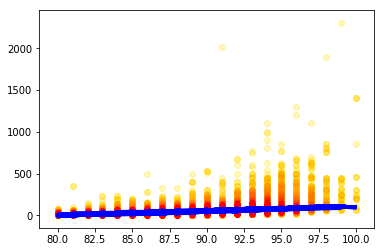

In [29]:
m,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,c = np.linalg.lstsq(X,y)[0]
print((np.linalg.lstsq(X,y))[3])
py.scatter(df['points'],y,alpha=0.2,color='yellow')
py.scatter(df['points'],y,alpha=0.085,color='orange')
py.scatter(df['points'],y,alpha=0.002,color='red')
py.plot(df['points'],m*df['points']+m1*country_dummy[0]+m2*country_dummy[1]+m3*country_dummy[2]+m4*country_dummy[3]+m5*country_dummy[4]+m6*country_dummy[5]+m7*country_dummy[6]+m8*country_dummy[7]+m9*country_dummy[8]+m10*country_dummy[9]+m11*country_dummy[10]+m12*country_dummy[11]+m13*country_dummy[12]+m14*country_dummy[13]+v0*country_variety[0]+v1*country_variety[1]+v2*country_variety[2]+v3*country_variety[3]+v4*country_variety[4]+v5*country_variety[5]+v6*country_variety[6]+v7*country_variety[7]+v8*country_variety[8]+v9*country_variety[9]+v10*country_variety[10]+v11*country_variety[11]+v12*country_variety[12]+v13*country_variety[13]+v14*country_variety[14]+v15*country_variety[15]+v16*country_variety[16]+v17*country_variety[17]+v18*country_variety[18]+v19*country_variety[19]+v20*country_variety[20]+v21*country_variety[21]+v22*country_variety[22]+v23*country_variety[23]+v24*country_variety[24]+v25*country_variety[25]+v26*country_variety[26]+v27*country_variety[27]+v28*country_variety[28]+v29*country_variety[29]+v30*country_variety[30]+v31*country_variety[31]+v32*country_variety[32]+v33*country_variety[33]+v34*country_variety[34]+v35*country_variety[35]+v36*country_variety[36]+v37*country_variety[37]+v38*country_variety[38]+v39*country_variety[39]+v40*country_variety[40]+v41*country_variety[41]+v42*country_variety[42]+v43*country_variety[43]+v44*country_variety[44]+v45*country_variety[45]+v46*country_variety[46]+v47*country_variety[47]+v48*country_variety[48]+v49*country_variety[49]+v50*country_variety[50]+v51*country_variety[51]+v52*country_variety[52]+v53*country_variety[53]+v54*country_variety[54]+v55*country_variety[55]+v56*country_variety[56]+v57*country_variety[57]+v58*country_variety[58]+v59*country_variety[59]+v60*country_variety[60]+v61*country_variety[61]+v62*country_variety[62]+v63*country_variety[63]+v64*country_variety[64]+v65*country_variety[65]+v66*country_variety[66]+v67*country_variety[67]+v68*country_variety[68]+v69*country_variety[69]+v70*country_variety[70]+v71*country_variety[71]+v72*country_variety[72]+v73*country_variety[73]+v74*country_variety[74]+v75*country_variety[75]+v76*country_variety[76]+v77*country_variety[77]+v78*country_variety[78]+v79*country_variety[79]+v80*country_variety[80]+v81*country_variety[81]+v82*country_variety[82]+v83*country_variety[83]+v84*country_variety[84]+v85*country_variety[85]+v86*country_variety[86]+v87*country_variety[87]+v88*country_variety[88]+v89*country_variety[89]++v90*country_variety[90]+v91*country_variety[91]+v92*country_variety[92]+v93*country_variety[93]+v94*country_variety[94]+v95*country_variety[95]+v96*country_variety[96]+v97*country_variety[97]+v98*country_variety[98]+v99*country_variety[99]+c,'b')
py.show()

**The Decision Tree algorithm uses the Gini index to calculate the impurity in each node, minimizing this resulting impurity at each split.**

In [30]:
def R2_score(y_pred,y_true):
    # u is the residual sum of squares
    u = ((y_true - y_pred) ** 2).sum()
    # v is the total sum of squares
    v = ((y_true - y_true.mean()) ** 2).sum()
    return (1-u/v)

In [108]:
variety_map_1 = {'Cabernet Sauvignon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tinta de Toro':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sauvignon Blanc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Noir':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Friulano':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tannat':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Chardonnay':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tempranillo':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Malbec':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Rosé':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tempranillo Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Syrah':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sparkling Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sangiovese':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Rhône-style White Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Red Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Mencía':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Petite Sirah':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Riesling':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Cabernet Sauvignon-Syrah':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Portuguese Red':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Gris':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Nebbiolo':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Meritage':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Glera':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Malbec-Merlot':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Viognier':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Moscato':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Grigio':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Cabernet Franc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'White Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Gamay':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Zinfandel':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Greco':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Barbera':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Grenache':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]}
variety_map_2 = {'Rhône-style Red Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Albariño':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Carmenère':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Bordeaux-style Red Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Touriga Nacional':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Agiorgitiko':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Godello':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Gewürztraminer':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Merlot':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'G-S-M':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Mourvèdre':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Bordeaux-style White Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Petit Verdot':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Muscat':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Cabernet Sauvignon-Merlot':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Bianco':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Portuguese White':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Garganega':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sauvignon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Grüner Veltliner':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Vermentino':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sherry':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Aglianico':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Torrontés':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Primitivo':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Semillon-Sauvignon Blanc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Blanc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'St. Laurent':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Blaufränkisch':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Pinot Nero':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Shiraz':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Champagne Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Garnacha':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Chenin Blanc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Fumé Blanc':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]}
variety_map_3 = {'Monastrell':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Roussanne':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Port':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Cabernet Blend':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Marsanne':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Melon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Fiano':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Verdejo':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Zweigelt':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Grillo':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tempranillo-Cabernet Sauvignon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Tinto Fino':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],"Nero d'Avola":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Sémillon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Dolcetto':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Cabernet Sauvignon-Shiraz':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Montepulciano':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1],'Viura':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1],'Shiraz-Viognier':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1],'Bonarda':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1],'Tinto del Pais':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1],'Sagrantino':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1],'Pinotage':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1],'Corvina, Rondinella, Molinara':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1],'Sangiovese Grosso':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1],'Shiraz-Cabernet Sauvignon':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1],'Prosecco':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1],'Prugnolo Gentile':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1],'Cortese':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]}
country_map = {'US':[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Spain':[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Italy':[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'France':[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'New Zealand':[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Argentina':[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Australia':[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Portugal':[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Israel':[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'South Africa':[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Greece':[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Chile':[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Germany':[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],'Austria':[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]}

In [94]:
# To get variety data via one hot encoding
varieties_kpt = np.unique(np.append(df[0:100]['variety'].unique(),df[100:200]['variety'].unique()))
dummy_variety = pd.get_dummies(varieties_kpt)
country_variety = []
for i in range(0,len(dftest['variety'].unique())):
    country_variety.append(dummy_variety[varieties_kpt[i]])

In [110]:
country_map['US']+variety_map_1['Cabernet Sauvignon']



[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

In [ ]:
country_variety = []
for i in range(0,len(dftest['variety'].unique())):
    country_variety.append(dummy_variety[varieties_kpt[i]])

In [92]:
def Wine_Decision_Tree_Regression(df,dftest):
    # To get variety data via one hot encoding
    varieties_kpt = df['variety'].unique()
    dummy_variety = pd.get_dummies(df['variety'])
    country_variety = []
    for i in range(0,len(df['variety'].unique())):
        country_variety.append(dummy_variety[varieties_kpt[i]])
        
    # To get country data via one hot encoding
    countries_kpt = df['country'].unique()
    dummy = pd.get_dummies(df['country'])
    country_dummy = []
    for i in range(0,len(df['country'].unique())):
        country_dummy.append(dummy[countries_kpt[i]])
        
    Xtrain = df[['points']].as_matrix()

    for i in range(0,len(country_dummy)):
        Xtrain = np.c_[Xtrain,country_dummy[i]]
    for j in range(0,len(country_variety)):
        Xtrain = np.c_[Xtrain,country_variety[j]]
    Xtrain = np.c_[Xtrain,np.ones(len(df['points']))]
    
    
    # To get variety data via one hot encoding
    varieties_kpt = dftest['variety'].unique()
    dummy_variety = pd.get_dummies(dftest['variety'])
    country_variety = []
    for i in range(0,len(dftest['variety'].unique())):
        country_variety.append(dummy_variety[varieties_kpt[i]])
        
    # To get country data via one hot encoding
    countries_kpt = dftest['country'].unique()
    dummy = pd.get_dummies(dftest['country'])
    country_dummy = []
    for i in range(0,len(dftest['country'].unique())):
        country_dummy.append(dummy[countries_kpt[i]])
        
    Xtest = df[['points']].as_matrix()

    for i in range(0,len(country_dummy)):
        Xtest = np.c_[Xtest,country_dummy[i]]
    for j in range(0,len(country_variety)):
        Xtest = np.c_[Xtest,country_variety[j]]
    Xtest = np.c_[Xtest,np.ones(len(dftest['points']))]
    
    
    Y = df['price'].as_matrix()
    clf = tree.DecisionTreeRegressor()
    # useful code: min_samples_leaf=10,max_depth=3,max_leaf_nodes = 100
    clf = clf.fit(X, Y)
    return clf.predict(Xtest) # Returns the prediction vector

In [93]:
R2_score(Wine_Decision_Tree_Regression(df,df),df['price'].as_matrix())

0.3547205766609236

In [34]:
X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],country_variety[0],country_variety[1],country_variety[2],country_variety[3],country_variety[4],country_variety[5],country_variety[6],country_variety[7],country_variety[8],country_variety[9],country_variety[10],country_variety[11],country_variety[12],country_variety[13],country_variety[14],country_variety[15],country_variety[16],country_variety[17],country_variety[18],country_variety[19],country_variety[20],country_variety[21],country_variety[22],country_variety[23],country_variety[24],country_variety[25],country_variety[26],country_variety[27],country_variety[28],country_variety[29],country_variety[30],country_variety[31],country_variety[32],country_variety[33],country_variety[34],country_variety[35],country_variety[36],country_variety[37],country_variety[38],country_variety[39],country_variety[40],country_variety[41],country_variety[42],country_variety[43],country_variety[44],country_variety[45],country_variety[46],country_variety[47],country_variety[48],country_variety[49],country_variety[50],country_variety[51],country_variety[52],country_variety[53],country_variety[54],country_variety[55],country_variety[56],country_variety[57],country_variety[58],country_variety[59],country_variety[60],country_variety[61],country_variety[62],country_variety[63],country_variety[64],country_variety[65],country_variety[66],country_variety[67],country_variety[68],country_variety[69],country_variety[70],country_variety[71],country_variety[72],country_variety[73],country_variety[74],country_variety[75],country_variety[76],country_variety[77],country_variety[78],country_variety[79],country_variety[80],country_variety[81],country_variety[82],country_variety[83],country_variety[84],country_variety[85],country_variety[86],country_variety[87],country_variety[88],country_variety[89],country_variety[90],country_variety[91],country_variety[92],country_variety[93],country_variety[94],country_variety[95],country_variety[96],country_variety[97],country_variety[98],country_variety[99],np.ones(len(df['points']))]
Y = df['price'].as_matrix()
clf = tree.DecisionTreeRegressor()
# useful code: min_samples_leaf=10,max_depth=3,max_leaf_nodes = 100
clf = clf.fit(X, Y)
clf

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [35]:
y_pred = clf.predict(X)
y_true = Y
R2_score(y_pred,Y)

0.55702513499629902

**Random Forest Regressor for our model**

In [36]:
import sklearn
from sklearn import ensemble
X = df[['points']].as_matrix()
X = np.c_[X,country_dummy[0],country_dummy[1],country_dummy[2],country_dummy[3],country_dummy[4],country_dummy[5],country_dummy[6],country_dummy[7],country_dummy[8],country_dummy[9],country_dummy[10],country_dummy[11],country_dummy[12],country_dummy[13],country_variety[0],country_variety[1],country_variety[2],country_variety[3],country_variety[4],country_variety[5],country_variety[6],country_variety[7],country_variety[8],country_variety[9],country_variety[10],country_variety[11],country_variety[12],country_variety[13],country_variety[14],country_variety[15],country_variety[16],country_variety[17],country_variety[18],country_variety[19],country_variety[20],country_variety[21],country_variety[22],country_variety[23],country_variety[24],country_variety[25],country_variety[26],country_variety[27],country_variety[28],country_variety[29],country_variety[30],country_variety[31],country_variety[32],country_variety[33],country_variety[34],country_variety[35],country_variety[36],country_variety[37],country_variety[38],country_variety[39],country_variety[40],country_variety[41],country_variety[42],country_variety[43],country_variety[44],country_variety[45],country_variety[46],country_variety[47],country_variety[48],country_variety[49],country_variety[50],country_variety[51],country_variety[52],country_variety[53],country_variety[54],country_variety[55],country_variety[56],country_variety[57],country_variety[58],country_variety[59],country_variety[60],country_variety[61],country_variety[62],country_variety[63],country_variety[64],country_variety[65],country_variety[66],country_variety[67],country_variety[68],country_variety[69],country_variety[70],country_variety[71],country_variety[72],country_variety[73],country_variety[74],country_variety[75],country_variety[76],country_variety[77],country_variety[78],country_variety[79],country_variety[80],country_variety[81],country_variety[82],country_variety[83],country_variety[84],country_variety[85],country_variety[86],country_variety[87],country_variety[88],country_variety[89],country_variety[90],country_variety[91],country_variety[92],country_variety[93],country_variety[94],country_variety[95],country_variety[96],country_variety[97],country_variety[98],country_variety[99],np.ones(len(df['points']))]
Y = df['price'].as_matrix()
rfr = sklearn.ensemble.RandomForestRegressor()
rfr = rfr.fit(X, Y)
rfr

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [37]:
y_pred = rfr.predict(X)
y_true = Y
R2_score(y_pred,y_true)

0.5523115426071179

In [38]:
npy = []
npy.append('points')
for i in countries_kpt:
    npy.append(i)
for i in varieties_kpt:
    npy.append(i)
npy.append('ones')

X = df[['points']].as_matrix()

for i in range(0,len(country_dummy)):
    X = np.c_[X,country_dummy[i]]
for j in range(0,len(country_variety)):
    X = np.c_[X,country_variety[j]]
X = np.c_[X,np.ones(len(df['points']))]

y_pred = clf.predict(X)
y_true = df['price'].as_matrix()
count = 0
y_true_jk = y_true
y_pred_jk = y_pred
target = 5
for i in range(0,len(y_true)):
    if y_true_jk[i] > 20:
        y_true_jk[i] = 0
        y_pred_jk[i] = 0
errors = abs(y_true_jk-y_pred_jk)
for i in range(0,len(errors)):
    if errors[i] > target:
        errors[i] = 0
        count+=1
py.scatter(df.index,errors)
print("Our chance of getting the prediction within",target,"dollars is",(1-count/len(errors)))
print(count)
print(len(errors))

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                        feature_names=npy,  
                        class_names=['price'],  
                        filled=True, rounded=True,  
                        special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render("data", view=True) 
#dot_data = tree.export_graphviz(clf, out_file=None, 
#                         feature_names=npy,  
#                         class_names=['price'],  
#                         filled=True, rounded=True,  
#                         special_characters=True)  
#graph = graphviz.Source(dot_data)  
#graph



In [41]:
# How to buy cheap wine 101

for i in df.index:
    if df['price'][i] <= 7:
        if df['points'][i] >= 90:
            print("Points",df['points'][i], "winery", df['winery'][i], "variety", df['variety'][i], "price", df['price'][i])

Points 96 winery Heitz variety Cabernet Sauvignon price 0.0
Points 96 winery Bodega Carmen Rodríguez variety Tinta de Toro price 0.0
Points 96 winery Macauley variety Sauvignon Blanc price 0.0
Points 96 winery Ponzi variety Pinot Noir price 0.0
Points 95 winery Numanthia variety Tinta de Toro price 0.0
Points 95 winery Maurodos variety Tinta de Toro price 0.0
Points 95 winery Bodega Carmen Rodríguez variety Tinta de Toro price 0.0
Points 95 winery Bergström variety Pinot Noir price 0.0
Points 95 winery Blue Farm variety Pinot Noir price 0.0
Points 95 winery Borgo del Tiglio variety Friulano price 0.0
Points 95 winery Patricia Green Cellars variety Pinot Noir price 0.0
Points 95 winery Patricia Green Cellars variety Pinot Noir price 0.0
Points 95 winery Vignobles Brumont variety Tannat price 0.0
Points 95 winery Domaine Serene variety Pinot Noir price 0.0
Points 95 winery Bergström variety Chardonnay price 0.0
Points 95 winery Hall variety Cabernet Sauvignon price 0.0
Points 95 winery V

Points 90 winery Medlock Ames variety Cabernet Sauvignon price 0.0
Points 90 winery Passaggio variety Sauvignon Blanc price 0.0
Points 90 winery Patland variety Chardonnay price 0.0
Points 90 winery Trig Point variety Chardonnay price 0.0
Points 90 winery Valquejigoso variety White Blend price 0.0
Points 90 winery Tenuta di Sesta variety Sangiovese price 0.0
Points 90 winery Terlato variety Chardonnay price 0.0
Points 90 winery The Calling variety Cabernet Sauvignon price 0.0
Points 90 winery Westwood variety Rhône-style Red Blend price 0.0
Points 90 winery Fenestra variety Tempranillo price 0.0
Points 90 winery Castello di Bossi variety Sangiovese price 0.0
Points 90 winery Cecchi variety Red Blend price 0.0
Points 90 winery Cafaggio variety Sangiovese price 0.0
Points 92 winery Martin Ray variety Chardonnay price 0.0
Points 92 winery Castello d'Alba variety Portuguese Red price 0.0
Points 92 winery Robert Biale variety Zinfandel price 0.0
Points 92 winery Sequoia Grove variety Bordea

Points 90 winery Naggiar variety Barbera price 0.0
Points 90 winery Paraduxx variety Red Blend price 0.0
Points 90 winery Renwood variety Tempranillo price 0.0
Points 90 winery Santa Ema variety Red Blend price 0.0
Points 90 winery Beronia variety Tempranillo Blend price 0.0
Points 90 winery Adelaida Cellars variety Rhône-style Red Blend price 0.0
Points 90 winery Bella Luna variety Zinfandel price 0.0
Points 90 winery Chacewater variety Syrah price 0.0
Points 90 winery Dr. H. Thanisch (Erben Thanisch) variety Riesling price 0.0
Points 90 winery Occasio variety Cabernet Franc price 0.0
Points 90 winery Korbin Kameron variety Cabernet Sauvignon price 0.0
Points 90 winery Llopart variety Sparkling Blend price 0.0
Points 90 winery Sparkling Pointe variety Champagne Blend price 0.0
Points 90 winery Steele variety Merlot price 0.0
Points 90 winery Torelló variety Sparkling Blend price 0.0
Points 90 winery Trefethen variety Cabernet Sauvignon price 0.0
Points 90 winery Anthony Road variety P

Points 90 winery Robert Hall variety Port price 0.0
Points 90 winery Roger et Didier Raimbault variety Pinot Noir price 0.0
Points 90 winery San Polo variety Sangiovese price 0.0
Points 90 winery V. Sattui variety Cabernet Sauvignon price 0.0
Points 90 winery William Hill Estate variety Chardonnay price 0.0
Points 90 winery Luiano variety Sangiovese price 0.0
Points 90 winery Maset del Lleó variety Tempranillo price 0.0
Points 90 winery Salcheto variety Red Blend price 0.0
Points 90 winery Villa a Sesta variety Sangiovese price 0.0
Points 90 winery Adair Bachman variety Rosé price 0.0
Points 90 winery Apriori variety Cabernet Sauvignon price 0.0
Points 90 winery Au Pied du Mont Chauve variety Chardonnay price 0.0
Points 93 winery Waxwing variety Syrah price 0.0
Points 93 winery Kumeu River variety Chardonnay price 0.0
Points 93 winery Château Eugénie variety Malbec price 0.0
Points 93 winery Fess Parker variety Pinot Noir price 0.0
Points 93 winery Grgich Hills variety Chardonnay price

Points 90 winery Argyle variety Pinot Noir price 0.0
Points 90 winery Big Table Farm variety Pinot Gris price 0.0
Points 90 winery Bischöfliche Weingüter Trier variety Riesling price 0.0
Points 90 winery Cantina del Pino variety Nebbiolo price 0.0
Points 90 winery Carmel variety Cabernet Sauvignon price 0.0
Points 90 winery Ricominciare variety Malbec price 0.0
Points 90 winery Antiquum Farm variety Pinot Gris price 0.0
Points 90 winery Beni di Batasiolo variety Nebbiolo price 0.0
Points 90 winery Bodega Catena Zapata variety Malbec price 0.0
Points 90 winery Carol Shelton variety Zinfandel price 0.0
Points 90 winery Cascina delle Rose variety Barbera price 0.0
Points 90 winery Château Eugénie variety Malbec-Merlot price 0.0
Points 90 winery Clos La Chance variety Rhône-style Red Blend price 0.0
Points 90 winery David Hill variety Pinot Noir price 0.0
Points 90 winery Deltetto variety Nebbiolo price 0.0
Points 90 winery Dry Creek Vineyard variety Chardonnay price 0.0
Points 90 winery F

Points 91 winery Château Brethous variety Bordeaux-style Red Blend price 0.0
Points 91 winery Château Cantinot variety Bordeaux-style Red Blend price 0.0
Points 91 winery Kiona variety Malbec price 0.0
Points 91 winery Dowsett Family variety Gewürztraminer price 0.0
Points 91 winery Dry Creek Vineyard variety Zinfandel price 0.0
Points 91 winery Clos du Val variety Cabernet Sauvignon price 0.0
Points 91 winery Santa Ema variety Red Blend price 0.0
Points 90 winery Anam Cara variety Pinot Noir price 0.0
Points 90 winery Donkey & Goat variety Chardonnay price 0.0
Points 90 winery Elena Walch variety Sauvignon price 0.0
Points 90 winery Juslyn Vineyards variety Cabernet Sauvignon price 0.0
Points 90 winery Kellerei Kaltern Caldaro variety Pinot Grigio price 0.0
Points 90 winery Kendall-Jackson variety Merlot price 0.0
Points 90 winery Kings Mountain variety Meritage price 0.0
Points 90 winery San Pedro variety Syrah price 0.0
Points 90 winery Prinz Salm variety Riesling price 0.0
Points 9

Points 92 winery Felton Road variety Pinot Noir price 0.0
Points 92 winery Alidis variety Tempranillo price 0.0
Points 92 winery Ancestrale variety Pinot Noir price 0.0
Points 92 winery Barton variety Zinfandel price 0.0
Points 92 winery Bergström variety Pinot Noir price 0.0
Points 92 winery Valenciso variety Tempranillo price 0.0
Points 92 winery Palliser Estate variety Pinot Noir price 0.0
Points 92 winery Las Vertientes variety Cabernet Sauvignon price 0.0
Points 92 winery Joseph Jewell variety Pinot Noir price 0.0
Points 92 winery Epiphany variety Syrah price 0.0
Points 92 winery Flying Trout variety Red Blend price 0.0
Points 92 winery Pride Mountain variety Cabernet Sauvignon price 0.0
Points 92 winery Château Lagrézette variety Malbec-Merlot price 0.0
Points 92 winery Château Sainte Marguerite variety Rosé price 0.0
Points 92 winery Amavi variety Syrah price 0.0
Points 92 winery Aventino variety Tempranillo price 0.0
Points 92 winery Babcock variety Sauvignon Blanc price 0.0
Po

Points 95 winery Biecher & Schaal variety Riesling price 0.0
Points 95 winery Abbadia Ardenga variety Sangiovese price 0.0
Points 95 winery Château Trotanoy variety Bordeaux-style Red Blend price 0.0
Points 95 winery Domaine Pfister variety Riesling price 0.0
Points 95 winery Donum variety Pinot Noir price 0.0
Points 95 winery Domaine Barmès-Buecher variety Gewürztraminer price 0.0
Points 95 winery Domaine Barmès-Buecher variety Riesling price 0.0
Points 95 winery Fuligni variety Sangiovese price 0.0
Points 95 winery Il Marroneto variety Sangiovese price 0.0
Points 95 winery Ridolfi variety Sangiovese price 0.0
Points 95 winery Williams Selyem variety Pinot Noir price 0.0
Points 95 winery Williams Selyem variety Pinot Noir price 0.0
Points 95 winery L'Aietta variety Sangiovese price 0.0
Points 95 winery Château la Fleur-Pétrus variety Bordeaux-style Red Blend price 0.0
Points 95 winery Château Latour-Martillac variety Bordeaux-style White Blend price 0.0
Points 95 winery Ciacci Piccolo

Points 91 winery Craggy Range variety Pinot Noir price 0.0
Points 91 winery Anaba variety Pinot Noir price 0.0
Points 91 winery Big Basin variety Syrah price 0.0
Points 91 winery Brick & Mortar variety Rosé price 0.0
Points 91 winery Château d'Esclans variety Rosé price 0.0
Points 91 winery Domaines Ott variety Rosé price 0.0
Points 91 winery Fabre en Provence variety Rosé price 0.0
Points 91 winery Fess Parker variety Pinot Noir price 0.0
Points 91 winery Flying Trout variety Red Blend price 0.0
Points 91 winery Goldschmidt variety Cabernet Sauvignon price 0.0
Points 91 winery Johanneshof Reinisch variety Pinot Noir price 0.0
Points 91 winery King Estate variety Pinot Gris price 0.0
Points 91 winery Lichen Estate variety Pinot Noir price 0.0
Points 91 winery Lone Madrone variety Zinfandel price 0.0
Points 91 winery Renwood variety Zinfandel price 0.0
Points 91 winery Roar variety Chardonnay price 0.0
Points 91 winery Robert Renzoni variety Tempranillo price 0.0
Points 91 winery Rosenh

Points 93 winery Talley variety Pinot Noir price 0.0
Points 93 winery Sokol Blosser variety Pinot Noir price 0.0
Points 93 winery Stolo variety Pinot Noir price 0.0
Points 93 winery Seal Beach variety Pinot Noir price 0.0
Points 93 winery Piña variety Cabernet Sauvignon price 0.0
Points 93 winery Piro variety Pinot Noir price 0.0
Points 93 winery Vidon Vineyard variety Pinot Noir price 0.0
Points 93 winery Flora Springs variety Cabernet Sauvignon price 0.0
Points 93 winery Mollydooker variety Shiraz price 0.0
Points 93 winery Château la Tour de Mons variety Bordeaux-style Red Blend price 0.0
Points 93 winery Château Latour-Martillac variety Bordeaux-style Red Blend price 0.0
Points 93 winery Château Le Crock variety Bordeaux-style Red Blend price 0.0
Points 93 winery Château Margaux variety Bordeaux-style White Blend price 0.0
Points 93 winery Château Bouscaut variety Bordeaux-style Red Blend price 0.0
Points 93 winery Claiborne & Churchill variety Pinot Noir price 0.0
Points 93 winery

Points 93 winery Château la Marzelle variety Bordeaux-style Red Blend price 0.0
Points 93 winery Biecher & Schaal variety Riesling price 0.0
Points 93 winery Boscarelli variety Red Blend price 0.0
Points 93 winery Alloro variety Chardonnay price 0.0
Points 93 winery Domaine Gresser variety Riesling price 0.0
Points 93 winery Domaine Michel Fonne variety Pinot Gris price 0.0
Points 93 winery Domaine Saint-Rémy variety Riesling price 0.0
Points 93 winery Fattoria dei Barbi variety Sangiovese price 0.0
Points 93 winery Il Conventino variety Red Blend price 0.0
Points 93 winery Jim Barry variety Cabernet Sauvignon price 0.0
Points 93 winery Ken Wright variety Pinot Noir price 0.0
Points 93 winery Le Macchiole variety Merlot price 0.0
Points 93 winery Merry Edwards variety Chardonnay price 0.0
Points 93 winery Mignanelli variety Chardonnay price 0.0
Points 93 winery Owen Roe variety Pinot Noir price 0.0
Points 93 winery Padelletti variety Sangiovese price 0.0
Points 93 winery Parducci varie

Points 92 winery Mignanelli variety Pinot Noir price 0.0
Points 92 winery Goat Bubbles variety Pinot Blanc price 0.0
Points 92 winery Henschke variety Riesling price 0.0
Points 92 winery I Veroni variety Sangiovese price 0.0
Points 92 winery Iris Vineyards variety Pinot Noir price 0.0
Points 92 winery Quintet variety Pinot Noir price 0.0
Points 92 winery Ramey variety Syrah price 0.0
Points 92 winery WindVane variety Pinot Noir price 0.0
Points 92 winery Terralsole variety Sangiovese price 0.0
Points 92 winery Three Fat Guys variety Chardonnay price 0.0
Points 92 winery Owen Roe variety Pinot Noir price 0.0
Points 92 winery Palazzo Vecchio variety Red Blend price 0.0
Points 92 winery Siduri variety Pinot Noir price 0.0
Points 92 winery Styring variety Pinot Noir price 0.0
Points 90 winery Taron variety Tempranillo price 0.0
Points 90 winery Château Paradis variety Rosé price 0.0
Points 90 winery Château Roquefeuille variety Rosé price 0.0
Points 90 winery Domaine de l'Amaurigue variety

Points 93 winery Falcone variety Red Blend price 0.0
Points 93 winery Hall variety Cabernet Sauvignon price 0.0
Points 93 winery Kokomo variety Zinfandel price 0.0
Points 93 winery Rex Hill variety Pinot Noir price 0.0
Points 93 winery Tapiz variety Malbec price 0.0
Points 93 winery Tenuta delle Terre Nere variety Red Blend price 0.0
Points 93 winery Acacia variety Chardonnay price 0.0
Points 93 winery Brittan Vineyards variety Pinot Noir price 0.0
Points 93 winery Joseph Cattin variety Pinot Gris price 0.0
Points 93 winery Kuentz-Bas variety Gewürztraminer price 0.0
Points 93 winery Hyland variety Pinot Noir price 0.0
Points 93 winery Lexington variety Cabernet Sauvignon price 0.0
Points 93 winery Lone Madrone variety Nebbiolo price 0.0
Points 93 winery Lone Madrone variety Zinfandel price 0.0
Points 93 winery Domaine Barmès-Buecher variety Gewürztraminer price 0.0
Points 93 winery Domaine Bott-Geyl variety Pinot Gris price 0.0
Points 93 winery Domaine Rieflé-Landmann variety Gewürztr

Points 91 winery Château la Fortune variety Bordeaux-style Red Blend price 0.0
Points 91 winery Château Maurac variety Bordeaux-style Red Blend price 0.0
Points 91 winery Château Nenin variety Bordeaux-style Red Blend price 0.0
Points 91 winery Château Rollan de By variety Bordeaux-style Red Blend price 0.0
Points 91 winery Château Vieux Moulin variety Bordeaux-style Red Blend price 0.0
Points 91 winery Domaine Anderson variety Chardonnay price 0.0
Points 91 winery Domaine Fernand Engel variety Muscat price 0.0
Points 91 winery Domaine Zind-Humbrecht variety Muscat price 0.0
Points 96 winery Domaine Rossignol-Trapet variety Pinot Noir price 0.0
Points 96 winery Astrales variety Tinto Fino price 0.0
Points 96 winery Bouchard Père & Fils variety Chardonnay price 0.0
Points 96 winery Bouchard Père & Fils variety Pinot Noir price 0.0
Points 92 winery Kumeu River variety Chardonnay price 0.0
Points 92 winery Lancaster variety Sauvignon Blanc price 0.0
Points 92 winery Les Belles Collines va

Points 91 winery Belharra variety Syrah price 0.0
Points 91 winery Bodegas Escudero variety Tempranillo Blend price 0.0
Points 91 winery Kilikanoon variety Shiraz price 0.0
Points 91 winery Pecunia variety Tempranillo Blend price 0.0
Points 91 winery Château Clément-Pichon variety Bordeaux-style Red Blend price 0.0
Points 91 winery Château d'Agassac variety Bordeaux-style Red Blend price 0.0
Points 91 winery Château du Parc variety Bordeaux-style Red Blend price 0.0
Points 91 winery Château Larose-Trintaudon variety Bordeaux-style Red Blend price 0.0
Points 91 winery Capezzana variety Red Blend price 0.0
Points 91 winery Carpineto variety Sangiovese price 0.0
Points 91 winery Château Reverdi variety Bordeaux-style Red Blend price 0.0
Points 91 winery Clément Klur variety Pinot Noir price 0.0
Points 92 winery Foley variety Chardonnay price 0.0
Points 92 winery Fritz Haag variety Riesling price 0.0
Points 92 winery Gary Farrell variety Pinot Noir price 0.0
Points 92 winery Domaine Barmès

Points 90 winery The Four Graces variety Pinot Noir price 0.0
Points 90 winery Tinto Rey variety Red Blend price 0.0
Points 90 winery Tyrrell's variety Sémillon price 0.0
Points 90 winery Cantina del Giusto variety Red Blend price 0.0
Points 90 winery Carabella variety Pinot Noir price 0.0
Points 90 winery Casale Daviddi variety Red Blend price 0.0
Points 90 winery Brunelli Martoccia variety Sangiovese price 0.0
Points 90 winery Byron variety Pinot Noir price 0.0
Points 90 winery Camigliano variety Sangiovese price 0.0
Points 90 winery Castello di Amorosa variety Pinot Noir price 0.0
Points 90 winery E16 variety Chardonnay price 0.0
Points 90 winery Château Ducluzeau variety Bordeaux-style Red Blend price 0.0
Points 98 winery Williams Selyem variety Pinot Noir price 0.0
Points 97 winery Ramey variety Chardonnay price 0.0
Points 96 winery Emmerich Knoll variety Grüner Veltliner price 0.0
Points 96 winery Ramey variety Chardonnay price 0.0
Points 96 winery Williams Selyem variety Pinot N

Points 98 winery Penfolds variety Shiraz price 0.0
Points 97 winery Kracher variety Chardonnay price 0.0
Points 97 winery Flowers variety Chardonnay price 0.0
Points 97 winery Penfolds variety Shiraz price 0.0
Points 97 winery Penfolds variety Shiraz price 0.0
Points 97 winery Williams Selyem variety Pinot Noir price 0.0
Points 96 winery Torbreck variety Shiraz-Viognier price 0.0
Points 96 winery K Vintners variety Cabernet Sauvignon-Syrah price 0.0
Points 96 winery F X Pichler variety Riesling price 0.0
Points 96 winery Williams Selyem variety Pinot Noir price 0.0
Points 96 winery Penfolds variety Shiraz price 0.0
Points 96 winery Bründlmayer variety Riesling price 0.0
Points 96 winery K Vintners variety Syrah price 0.0
Points 95 winery C.H. Berres variety Riesling price 0.0
Points 95 winery Torbreck variety Shiraz price 0.0
Points 95 winery Prinz Salm variety Riesling price 0.0
Points 95 winery F X Pichler variety Riesling price 0.0
Points 95 winery Château Climens variety Bordeaux-s

Points 93 winery Sojourn variety Pinot Noir price 0.0
Points 93 winery San Giusto a Rentennano variety Red Blend price 0.0
Points 93 winery Qupé variety Chardonnay price 0.0
Points 93 winery Domaine FL variety Chenin Blanc price 0.0
Points 93 winery Domaine de Fondrèche variety Rhône-style Red Blend price 0.0
Points 95 winery Kopke variety Port price 0.0
Points 95 winery Domaine Schoffit variety Gewürztraminer price 0.0
Points 95 winery Domaine Schoffit variety Riesling price 0.0
Points 95 winery Domaine Serene variety Chardonnay price 0.0
Points 95 winery Domaine Zind-Humbrecht variety Gewürztraminer price 0.0
Points 95 winery Moss Wood variety Cabernet Sauvignon price 0.0
Points 95 winery Domaine Schoffit variety Pinot Gris price 0.0
Points 95 winery Quinta da Foz variety Portuguese Red price 0.0
Points 95 winery Quinta dos Murças variety Portuguese Red price 0.0
Points 95 winery René Muré variety Riesling price 0.0
Points 95 winery René Muré variety Riesling price 0.0
Points 95 wine

Points 90 winery Domaine Fernand Engel variety Pinot Noir price 0.0
Points 90 winery Emile Beyer variety Pinot Noir price 0.0
Points 90 winery Fesstivity variety Chardonnay price 0.0
Points 90 winery Gehricke variety Cabernet Sauvignon price 0.0
Points 90 winery Hugel variety Muscat price 0.0
Points 90 winery Ideology variety Pinot Noir price 0.0
Points 90 winery Joseph Cattin variety Riesling price 0.0
Points 90 winery Joseph Cattin variety Muscat price 0.0
Points 90 winery La Braccesca variety Sangiovese price 0.0
Points 93 winery Gramercy variety Rhône-style Red Blend price 0.0
Points 93 winery Loring Wine Company variety Pinot Noir price 0.0
Points 93 winery Malat variety Riesling price 0.0
Points 93 winery Roche de Bellene variety Pinot Noir price 0.0
Points 93 winery Three Sticks variety Pinot Noir price 0.0
Points 93 winery Fattoria di Corsignano variety Sangiovese price 0.0
Points 93 winery Château d'Esclans variety Rosé price 0.0
Points 93 winery Château les Valentines variety

Points 92 winery J Vineyards & Winery variety Chardonnay price 0.0
Points 92 winery Martin Ray variety Chardonnay price 0.0
Points 92 winery Les Vignobles Gueissard variety Red Blend price 0.0
Points 92 winery Saviah variety Red Blend price 0.0
Points 92 winery Ramey variety Cabernet Sauvignon price 0.0
Points 92 winery Riverbench variety Pinot Noir price 0.0
Points 92 winery Westerly variety Cabernet Sauvignon price 0.0
Points 92 winery Avignonesi variety Sangiovese price 0.0
Points 92 winery Bindi Sergardi variety Sangiovese price 0.0
Points 92 winery Cellars 33 variety Pinot Noir price 0.0
Points 92 winery B. Leighton variety Petit Verdot price 0.0
Points 92 winery Badia a Coltibuono variety Sangiovese price 0.0
Points 92 winery Domaine du Deffends variety Rosé price 0.0
Points 91 winery Jean-Luc and Paul Aegerter variety Chardonnay price 0.0
Points 91 winery Jessie's Grove variety Zinfandel price 0.0
Points 91 winery Kendall-Jackson variety Chardonnay price 0.0
Points 91 winery Lou

Points 90 winery Tranche variety Chardonnay price 0.0
Points 90 winery Valle dell'Acate variety Nero d'Avola price 0.0
Points 90 winery :Nota Bene variety Syrah price 0.0
Points 90 winery Pierre André variety Pinot Noir price 0.0
Points 90 winery Re Manfredi variety Aglianico price 0.0
Points 90 winery Animale variety Dolcetto price 0.0
Points 90 winery Armida variety Pinot Noir price 0.0
Points 90 winery I Veroni variety White Blend price 0.0
Points 90 winery J Vineyards & Winery variety Pinot Noir price 0.0
Points 90 winery Giovanni Chiappini variety Red Blend price 0.0
Points 90 winery La Calonica variety Red Blend price 0.0
Points 90 winery Lorenzi Estate variety Chardonnay price 0.0
Points 90 winery Lula variety Pinot Noir price 0.0
Points 90 winery MacRostie variety Pinot Noir price 0.0
Points 90 winery Marshall Davis variety Pinot Noir price 0.0
Points 90 winery Mastrojanni variety Sangiovese price 0.0
Points 90 winery Maurice Schoech & Fils variety Gewürztraminer price 0.0
Poin

Points 91 winery Hand of God variety Malbec price 0.0
Points 91 winery Josmeyer variety Riesling price 0.0
Points 91 winery Bruliam variety Pinot Noir price 0.0
Points 91 winery Bodegas Dios Baco S.L. variety Sherry price 0.0
Points 91 winery Bodegas Vínícola Real variety Red Blend price 0.0
Points 91 winery Benovia variety Pinot Noir price 0.0
Points 91 winery Sojourn variety Pinot Noir price 0.0
Points 91 winery Teós variety Tempranillo price 0.0
Points 93 winery Abacela variety Malbec price 0.0
Points 93 winery Ayoub variety Chardonnay price 0.0
Points 93 winery Ayoub variety Pinot Noir price 0.0
Points 93 winery Ayoub variety Pinot Noir price 0.0
Points 93 winery Casa da Passarella variety Portuguese Red price 0.0
Points 93 winery Cave de Ribeauvillé variety Riesling price 0.0
Points 93 winery Tobacco Road variety Cabernet Sauvignon price 0.0
Points 93 winery Château Tanunda variety Shiraz price 0.0
Points 93 winery Élevée Winegrowers variety Pinot Noir price 0.0
Points 93 winery F

Points 92 winery Langmeil variety Shiraz price 0.0
Points 92 winery Kaesler variety Shiraz price 0.0
Points 92 winery Pewsey Vale variety Riesling price 0.0
Points 92 winery Maximin Grünhäuser variety Riesling price 0.0
Points 92 winery Château Prieuré-Lichine variety Bordeaux-style Red Blend price 0.0
Points 92 winery Alta Colina variety Syrah price 0.0
Points 92 winery Bernardus variety Chardonnay price 0.0
Points 92 winery Cambria variety Pinot Noir price 0.0
Points 92 winery Tenuta Bellafonte variety Sagrantino price 0.0
Points 92 winery Williams Selyem variety Pinot Noir price 0.0
Points 92 winery Marimar Estate variety Pinot Noir price 0.0
Points 92 winery K Vintners variety Syrah price 0.0
Points 92 winery Lemelson variety Pinot Gris price 0.0
Points 92 winery Proulx variety Red Blend price 0.0
Points 92 winery Familia Cassone variety Malbec price 0.0
Points 92 winery Shea variety Chardonnay price 0.0
Points 93 winery Arista variety Pinot Noir price 0.0
Points 93 winery Barbieri

Points 91 winery Château la Mascaronne variety Rosé price 0.0
Points 91 winery Château Minuty variety Rosé price 0.0
Points 91 winery Chateau Ste. Michelle variety Chardonnay price 0.0
Points 91 winery Craggy Range variety Pinot Noir price 0.0
Points 91 winery Domaine de Valdition variety Rosé price 0.0
Points 91 winery Domaine Saint-André de Figuière variety Rosé price 0.0
Points 91 winery Dry Creek Vineyard variety Zinfandel price 0.0
Points 91 winery Eight Bells variety Syrah price 0.0
Points 91 winery Hawley variety Pinot Noir price 0.0
Points 91 winery JCB variety Rosé price 0.0
Points 91 winery Joullian variety Chardonnay price 0.0
Points 91 winery Ram's Gate variety Pinot Noir price 0.0
Points 91 winery Reyneke variety Sauvignon Blanc price 0.0
Points 91 winery Saviah variety Bordeaux-style Red Blend price 0.0
Points 91 winery Stift Göttweig variety Riesling price 0.0
Points 91 winery Swiftwater Cellars variety Bordeaux-style Red Blend price 0.0
Points 91 winery àMaurice variety

Points 90 winery Bellingham variety Chenin Blanc price 0.0
Points 90 winery Bodegas Gutiérrez de la Vega variety Monastrell price 0.0
Points 90 winery Bodegas Riojanas variety Tempranillo price 0.0
Points 90 winery Bodegas Riojanas variety Tempranillo Blend price 0.0
Points 90 winery Maggy Hawk variety Pinot Noir price 0.0
Points 90 winery Liquid Farm variety Chardonnay price 0.0
Points 90 winery Lis Neris variety Friulano price 0.0
Points 90 winery Livio Felluga variety Sauvignon price 0.0
Points 90 winery Jarvis variety Tempranillo price 0.0
Points 90 winery Meroi variety Friulano price 0.0
Points 90 winery Maryhill variety Malbec price 0.0
Points 90 winery McIntyre Vineyards variety Chardonnay price 0.0
Points 90 winery Yering Station variety Pinot Noir price 0.0
Points 90 winery Pepper Bridge variety Merlot price 0.0
Points 90 winery Stonestreet variety Cabernet Sauvignon price 0.0
Points 90 winery Val de Los Frailes variety Tempranillo price 0.0
Points 91 winery Jäger variety Ries

Points 91 winery Pirouette variety Red Blend price 0.0
Points 91 winery Tapestry variety Shiraz price 0.0
Points 91 winery Villa Matilde variety Red Blend price 0.0
Points 91 winery :Nota Bene variety Bordeaux-style Red Blend price 0.0
Points 91 winery Rosemount variety Shiraz price 0.0
Points 91 winery Cuvaison variety Cabernet Sauvignon price 0.0
Points 91 winery Ferngrove variety Riesling price 0.0
Points 91 winery Conti Zecca variety Red Blend price 0.0
Points 91 winery Henschke variety Chardonnay price 0.0
Points 91 winery Montevetrano variety Red Blend price 0.0
Points 91 winery Graf Hardegg variety White Blend price 0.0
Points 91 winery JC Cellars variety Syrah price 0.0
Points 91 winery O. Fournier variety Tinto del Pais price 0.0
Points 91 winery Stonier variety Chardonnay price 0.0
Points 90 winery Remhoogte variety Chenin Blanc price 0.0
Points 90 winery Vasse Felix variety Cabernet Blend price 0.0
Points 90 winery Shafer variety Merlot price 0.0
Points 90 winery Sparkman va

Points 90 winery Brotte variety Viognier price 0.0
Points 90 winery Mesh variety Riesling price 0.0
Points 90 winery Mauro variety Tempranillo price 0.0
Points 90 winery Graf Hardegg variety Grüner Veltliner price 0.0
Points 90 winery Joseph Drouhin variety Chardonnay price 0.0
Points 90 winery Joseph Swan Vineyards variety Pinot Noir price 0.0
Points 90 winery Père Anselme variety Rhône-style Red Blend price 0.0
Points 90 winery Saviah variety Syrah price 0.0
Points 90 winery Rosemount variety G-S-M price 0.0
Points 90 winery Williams Selyem variety Pinot Noir price 0.0
Points 90 winery Labouré-Roi variety Chardonnay price 0.0
Points 90 winery Landmark variety Chardonnay price 0.0
Points 90 winery Marr variety Petite Sirah price 0.0
Points 90 winery Hedges variety Red Blend price 0.0
Points 90 winery Lost Canyon variety Pinot Noir price 0.0
Points 90 winery Collovray et Terrier variety Chardonnay price 0.0
Points 90 winery Collovray et Terrier variety Chardonnay price 0.0
Points 91 wi

Points 90 winery Longoria variety Pinot Noir price 0.0
Points 90 winery Hocus Pocus variety Pinot Noir price 0.0
Points 90 winery Isabel Mondavi variety Chardonnay price 0.0
Points 90 winery Mastroberardino variety Fiano price 0.0
Points 90 winery Stolpman variety Rhône-style Red Blend price 0.0
Points 90 winery Talisman variety Pinot Noir price 0.0
Points 90 winery Willamette Valley Vineyards variety Pinot Noir price 0.0
Points 90 winery Viña Alicia variety Cabernet Blend price 0.0
Points 90 winery O'Vineyards variety Red Blend price 0.0
Points 90 winery Soléna variety Pinot Noir price 0.0
Points 90 winery Redhawk variety Pinot Noir price 0.0
Points 90 winery Salomon-Undhof variety Riesling price 0.0
Points 90 winery Arista variety Pinot Noir price 0.0
Points 90 winery Casale del Giglio variety Red Blend price 0.0
Points 90 winery Bosman Family Vineyards variety Pinotage price 0.0
Points 90 winery Del Carlo Winery variety Zinfandel price 0.0
Points 90 winery Feudo Maccari variety Nero

Points 93 winery Sodaro variety Bordeaux-style Red Blend price 0.0
Points 93 winery Alienor variety Syrah price 0.0
Points 93 winery Alvaro Castro variety Portuguese Red price 0.0
Points 93 winery Alvaro Castro variety Portuguese White price 0.0
Points 93 winery Cristom variety Pinot Noir price 0.0
Points 93 winery De Loach variety Chardonnay price 0.0
Points 93 winery Concha y Toro variety Cabernet Sauvignon price 0.0
Points 93 winery Lemelson variety Pinot Noir price 0.0
Points 93 winery Niepoort variety Port price 0.0
Points 93 winery Niepoort variety Portuguese Red price 0.0
Points 93 winery Taylor Fladgate variety Port price 0.0
Points 93 winery Umani Ronchi variety Red Blend price 0.0
Points 93 winery Casca Wines variety Portuguese Red price 0.0
Points 93 winery Château de Tiregand variety Bordeaux-style Red Blend price 0.0
Points 93 winery Gallo Signature Series variety Cabernet Sauvignon price 0.0
Points 93 winery Kelleher variety Cabernet Sauvignon price 0.0
Points 93 winery A

Points 90 winery Keating variety Cabernet Sauvignon price 0.0
Points 90 winery Joseph Phelps variety Syrah price 0.0
Points 90 winery V. Sattui variety Cabernet Sauvignon price 0.0
Points 90 winery Terre Rouge variety Roussanne price 0.0
Points 90 winery Louis M. Martini variety Cabernet Sauvignon price 0.0
Points 90 winery Il Feuduccio Di S. Maria D'Orni variety Montepulciano price 0.0
Points 90 winery Ken Wright variety Pinot Noir price 0.0
Points 90 winery Echeverria variety Cabernet Sauvignon price 0.0
Points 90 winery Grgich Hills variety Cabernet Sauvignon price 0.0
Points 90 winery Cristom variety Pinot Noir price 0.0
Points 90 winery Carabella variety Chardonnay price 0.0
Points 90 winery Torii Mor variety Pinot Noir price 0.0
Points 90 winery Umani Ronchi variety Red Blend price 0.0
Points 90 winery Venge variety Chardonnay price 0.0
Points 90 winery Talbott variety Chardonnay price 0.0
Points 90 winery Soléna variety Pinot Noir price 0.0
Points 90 winery Niepoort variety Port

Points 92 winery Concha y Toro variety Carmenère price 0.0
Points 92 winery Hermann J. Wiemer variety Riesling price 0.0
Points 92 winery Melville variety Pinot Noir price 0.0
Points 92 winery McCrea Cellars variety Roussanne price 0.0
Points 92 winery Miro variety Zinfandel price 0.0
Points 92 winery Grassini variety Sauvignon Blanc price 0.0
Points 92 winery K Vintners variety Cabernet Sauvignon-Syrah price 0.0
Points 92 winery Paul Dolan variety Cabernet Sauvignon price 0.0
Points 92 winery Samsara variety Syrah price 0.0
Points 92 winery Yalumba variety Port price 0.0
Points 92 winery Lucien Albrecht variety Riesling price 0.0
Points 92 winery Muga variety Tempranillo Blend price 0.0
Points 92 winery Pepper Bridge variety Bordeaux-style Red Blend price 0.0
Points 92 winery Quinta Nova de Nossa Senhora do Carmo variety Portuguese Red price 0.0
Points 92 winery Cadence variety Bordeaux-style Red Blend price 0.0
Points 92 winery Cantina Sociale della Valpantena variety Corvina, Rondin

Points 90 winery Jaffurs variety Grenache price 0.0
Points 90 winery K Vintners variety Syrah price 0.0
Points 90 winery Vaona variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Tedeschi variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Walla Walla Vintners variety Malbec price 0.0
Points 90 winery Tezza variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Stag's Leap Wine Cellars variety Sauvignon Blanc price 0.0
Points 90 winery Stefano Accordini variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Barnard Griffin variety Viognier price 0.0
Points 90 winery Aurielle variety Cabernet Sauvignon price 0.0
Points 90 winery Adega Cooperativa de Borba variety Portuguese Red price 0.0
Points 90 winery Aldegheri variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Krupp Brothers variety Merlot price 0.0
Points 90 winery La Rochelle variety Pinot Gris price 0.0
Points 90 winery Le Salette variety Corvina, Rondinella, Molinara pr

Points 93 winery Marimar Estate variety Chardonnay price 0.0
Points 93 winery Bonacchi variety Sangiovese Grosso price 0.0
Points 93 winery Fattoi variety Sangiovese Grosso price 0.0
Points 93 winery Fattoria dei Barbi variety Sangiovese Grosso price 0.0
Points 93 winery Fattoria La Lecciaia variety Sangiovese Grosso price 0.0
Points 93 winery Ernie Els variety Bordeaux-style Red Blend price 0.0
Points 93 winery Il Valentiano variety Sangiovese Grosso price 0.0
Points 93 winery Lisini variety Sangiovese Grosso price 0.0
Points 93 winery Mastrojanni variety Sangiovese Grosso price 0.0
Points 93 winery Mocali variety Sangiovese Grosso price 0.0
Points 93 winery La Poderina variety Sangiovese Grosso price 0.0
Points 93 winery Fossacolle variety Sangiovese Grosso price 0.0
Points 93 winery Pierre André variety Pinot Noir price 0.0
Points 93 winery Summerland variety Pinot Noir price 0.0
Points 93 winery Samsara variety Pinot Noir price 0.0
Points 93 winery San Polino variety Sangiovese Gro

Points 91 winery Tenute Niccolai variety Sangiovese Grosso price 0.0
Points 91 winery Tenute Silvio Nardi variety Sangiovese Grosso price 0.0
Points 91 winery Lambardi variety Sangiovese Grosso price 0.0
Points 91 winery Rubissow variety Cabernet Sauvignon price 0.0
Points 91 winery Ruffino variety Sangiovese Grosso price 0.0
Points 91 winery Rustenberg variety Chardonnay price 0.0
Points 91 winery Penley Estate variety Cabernet Sauvignon price 0.0
Points 91 winery Chapel Hill variety Grenache price 0.0
Points 91 winery Clarendon Hills variety Grenache price 0.0
Points 95 winery Volker Eisele Family Estate variety Cabernet Sauvignon price 0.0
Points 95 winery Abeja variety Merlot price 0.0
Points 95 winery Poet's Leap variety Riesling price 0.0
Points 95 winery Vistalba variety Red Blend price 0.0
Points 95 winery Woodward Canyon variety Merlot price 0.0
Points 95 winery Sequoia Grove variety Cabernet Sauvignon price 0.0
Points 95 winery Lis Neris variety White Blend price 0.0
Points 9

Points 92 winery Pessagno variety Pinot Noir price 0.0
Points 92 winery Matetic variety Syrah price 0.0
Points 92 winery Samsara variety Pinot Noir price 0.0
Points 92 winery Elan variety Cabernet Sauvignon price 0.0
Points 92 winery Feudi della Medusa variety White Blend price 0.0
Points 92 winery Gorman variety Chenin Blanc price 0.0
Points 92 winery Dusted Valley variety Cabernet Sauvignon price 0.0
Points 92 winery Dusted Valley variety Red Blend price 0.0
Points 92 winery Blue Rock variety Cabernet Sauvignon price 0.0
Points 90 winery Flora Springs variety Chardonnay price 0.0
Points 90 winery Dusted Valley variety Syrah price 0.0
Points 90 winery Mitolo variety Shiraz price 0.0
Points 90 winery Robert O. Smasne variety White Blend price 0.0
Points 90 winery Tenimenti Angelini variety Sangiovese Grosso price 0.0
Points 90 winery Señorio de Uñuela variety Tempranillo price 0.0
Points 90 winery Siro Pacenti variety Sangiovese Grosso price 0.0
Points 90 winery Stottle variety Tempran

Points 90 winery Corley variety Cabernet Sauvignon price 0.0
Points 90 winery Château Cambon la Pelouse variety Bordeaux-style Red Blend price 0.0
Points 90 winery Bodega Noemía de Patagonia variety Malbec price 0.0
Points 90 winery Château de Chamirey variety Pinot Noir price 0.0
Points 90 winery Serrera variety Malbec price 0.0
Points 90 winery Northstar variety Cabernet Sauvignon price 0.0
Points 90 winery Winzer Krems variety Grüner Veltliner price 0.0
Points 98 winery Château Léoville Las Cases variety Bordeaux-style Red Blend price 0.0
Points 97 winery Shafer variety Cabernet Sauvignon price 0.0
Points 97 winery Stag's Leap Wine Cellars variety Cabernet Sauvignon price 0.0
Points 97 winery Bodegas Roda variety Tempranillo price 0.0
Points 97 winery Taylor Fladgate variety Port price 0.0
Points 96 winery Château Montrose variety Bordeaux-style Red Blend price 0.0
Points 96 winery Taylor Fladgate variety Port price 0.0
Points 96 winery Louis Jadot variety Chardonnay price 0.0
Point

Points 97 winery Marchesi Antinori variety Red Blend price 0.0
Points 97 winery Paul Hobbs variety Cabernet Sauvignon price 0.0
Points 97 winery Tenuta dell'Ornellaia variety Merlot price 0.0
Points 97 winery Vine Cliff variety Cabernet Sauvignon price 0.0
Points 96 winery Hall variety Cabernet Sauvignon price 0.0
Points 96 winery Castello dei Rampolla variety Red Blend price 0.0
Points 96 winery Castello di Ama variety Merlot price 0.0
Points 96 winery Dutton-Goldfield variety Chardonnay price 0.0
Points 96 winery Poggio al Tesoro variety Cabernet Franc price 0.0
Points 96 winery Le Macchiole variety Cabernet Franc price 0.0
Points 96 winery Tenuta Sette Ponti variety Red Blend price 0.0
Points 95 winery Dutton-Goldfield variety Pinot Noir price 0.0
Points 95 winery Aia Vecchia variety Red Blend price 0.0
Points 95 winery Tenuta dell'Ornellaia variety Merlot price 0.0
Points 95 winery Vine Cliff variety Chardonnay price 0.0
Points 95 winery Brogan variety Pinot Noir price 0.0
Points 9

Points 90 winery Duca di Salaparuta variety Nero d'Avola price 0.0
Points 90 winery Galil Mountain variety Red Blend price 0.0
Points 90 winery Garnier et Fils variety Chardonnay price 0.0
Points 90 winery Graci variety White Blend price 0.0
Points 90 winery Chateau Ste. Michelle variety Merlot price 0.0
Points 90 winery Daou variety Rhône-style White Blend price 0.0
Points 90 winery Beresan variety Syrah price 0.0
Points 90 winery Madrigal variety Bordeaux-style Red Blend price 0.0
Points 90 winery Mahoney variety Pinot Noir price 0.0
Points 90 winery Hess Collection variety Red Blend price 0.0
Points 90 winery Kunde variety Chardonnay price 0.0
Points 90 winery Longboard variety Cabernet Sauvignon price 0.0
Points 90 winery Planeta variety Syrah price 0.0
Points 90 winery Planeta variety Red Blend price 0.0
Points 90 winery Stevens variety Bordeaux-style Red Blend price 0.0
Points 90 winery Tasca d'Almerita variety Syrah price 0.0
Points 90 winery Sineann variety Cabernet Sauvignon p

Points 90 winery Château Suau variety Bordeaux-style Red Blend price 0.0
Points 90 winery Castello di Poppiano variety Red Blend price 0.0
Points 90 winery Adelsheim variety Pinot Noir price 0.0
Points 90 winery Brandborg variety Pinot Noir price 0.0
Points 90 winery Kenwood variety Merlot price 0.0
Points 90 winery Martí Fabra variety Red Blend price 0.0
Points 90 winery Napa Cellars variety Merlot price 0.0
Points 90 winery Vignamaggio variety Cabernet Franc price 0.0
Points 90 winery Terras Gauda variety White Blend price 0.0
Points 90 winery Ànima Negra variety Red Blend price 0.0
Points 90 winery Chandon variety Sparkling Blend price 0.0
Points 90 winery Château d'Aydie variety Tannat price 0.0
Points 90 winery Château de Cénac variety Malbec price 0.0
Points 90 winery Château de Ferrand variety Bordeaux-style Red Blend price 0.0
Points 90 winery Château Roylland variety Bordeaux-style Red Blend price 0.0
Points 90 winery Fattoria di Grignano variety Red Blend price 0.0
Points 90 

Points 95 winery Robert Weil variety Riesling price 0.0
Points 95 winery Robert Weil variety Riesling price 0.0
Points 95 winery Bründlmayer variety Riesling price 0.0
Points 95 winery Seghesio variety Zinfandel price 0.0
Points 94 winery Hidden Ridge variety Cabernet Sauvignon price 0.0
Points 94 winery Matrix variety Pinot Noir price 0.0
Points 94 winery S.A. Prüm variety Riesling price 0.0
Points 94 winery S.A. Prüm variety Riesling price 0.0
Points 94 winery Archery Summit variety Pinot Noir price 0.0
Points 94 winery Archery Summit variety Pinot Gris price 0.0
Points 94 winery Chimney Rock variety Cabernet Sauvignon price 0.0
Points 94 winery Hunnicutt variety Cabernet Sauvignon price 0.0
Points 94 winery Turnbull variety Merlot price 0.0
Points 94 winery Schloss Johannisberger variety Riesling price 0.0
Points 94 winery Arista variety Pinot Noir price 0.0
Points 94 winery Château du Cèdre variety Malbec price 0.0
Points 94 winery Robert Weil variety Riesling price 0.0
Points 94 w

Points 91 winery Attems variety White Blend price 0.0
Points 91 winery Broman variety Cabernet Sauvignon price 0.0
Points 91 winery Château Tour des Gendres variety Bordeaux-style Red Blend price 0.0
Points 91 winery Boekenhoutskloof variety Syrah price 0.0
Points 91 winery Lis Neris variety White Blend price 0.0
Points 91 winery Matrix variety Pinot Noir price 0.0
Points 91 winery Graham Beck variety Red Blend price 0.0
Points 91 winery Schloss Saarstein variety Riesling price 0.0
Points 91 winery Rochioli variety Chardonnay price 0.0
Points 91 winery Sineann variety Pinot Noir price 0.0
Points 91 winery Tiefenbrunner variety Sauvignon price 0.0
Points 91 winery Novy variety Syrah price 0.0
Points 91 winery Chimney Rock variety Cabernet Sauvignon price 0.0
Points 91 winery Tranche variety Cabernet Sauvignon price 0.0
Points 91 winery Rôtie Cellars variety Red Blend price 0.0
Points 91 winery Rusack variety Pinot Noir price 0.0
Points 91 winery White Cottage Ranch variety Cabernet Sauv

Points 91 winery Château Bélingard variety Bordeaux-style Red Blend price 0.0
Points 91 winery Comartin variety Rhône-style Red Blend price 0.0
Points 91 winery Domaine Céline et Frédéric Gueguen variety Chardonnay price 0.0
Points 91 winery Thralls variety Pinot Noir price 0.0
Points 91 winery Dr. H. Thanisch (Erben Müller-Burggraef) variety Riesling price 0.0
Points 91 winery Dr. H. Thanisch (Erben Thanisch) variety Riesling price 0.0
Points 91 winery Fratelli Berlucchi variety Sparkling Blend price 0.0
Points 91 winery Herdade Grande variety Portuguese Red price 0.0
Points 91 winery Kopke variety Port price 0.0
Points 91 winery La Chablisienne variety Chardonnay price 0.0
Points 91 winery Louis Guntrum variety Riesling price 0.0
Points 91 winery Lynmar variety Pinot Noir price 0.0
Points 91 winery Pascal Bouchard variety Chardonnay price 0.0
Points 91 winery Pascal Bouchard variety Chardonnay price 0.0
Points 91 winery Ramos-Pinto variety Port price 0.0
Points 91 winery Schramsberg 

Points 91 winery Grieve variety Sauvignon Blanc price 0.0
Points 91 winery Jada Vineyard & Winery variety Rhône-style White Blend price 0.0
Points 91 winery La Crema variety Pinot Noir price 0.0
Points 91 winery Lawer variety Syrah price 0.0
Points 91 winery Marchesi di Barolo variety Nebbiolo price 0.0
Points 91 winery Michael Mondavi Family Estate variety Cabernet Sauvignon price 0.0
Points 91 winery Oddero variety Nebbiolo price 0.0
Points 91 winery Small Vines variety Pinot Noir price 0.0
Points 91 winery Terras de Alter variety Rhône-style Red Blend price 0.0
Points 91 winery Testarossa variety Chardonnay price 0.0
Points 91 winery Thomas George variety Chardonnay price 0.0
Points 91 winery Vite Colte variety Nebbiolo price 0.0
Points 91 winery Wedell Cellars variety Chardonnay price 0.0
Points 91 winery Winderlea variety Pinot Noir price 0.0
Points 91 winery A.R. Lenoble  variety Chardonnay price 0.0
Points 91 winery Adega Cooperativa de Borba variety Portuguese Red price 0.0
Poi

Points 90 winery Vietti variety Nebbiolo price 0.0
Points 90 winery Dalrymple variety Pinot Noir price 0.0
Points 90 winery Antiquum Farm variety Pinot Noir price 0.0
Points 90 winery Argyle variety Sparkling Blend price 0.0
Points 90 winery Pahlmeyer variety Chardonnay price 0.0
Points 90 winery Proprietà Sperino variety Red Blend price 0.0
Points 90 winery Plantagenet variety Chardonnay price 0.0
Points 90 winery Robert Oatley variety Chardonnay price 0.0
Points 90 winery Sanglier Cellars variety Pinot Noir price 0.0
Points 90 winery Sepp Moser variety Grüner Veltliner price 0.0
Points 90 winery Castello di Amorosa variety Pinot Noir price 0.0
Points 90 winery Callaway variety Roussanne price 0.0
Points 90 winery Domenico Clerico variety Nebbiolo price 0.0
Points 90 winery D'Arenberg variety Shiraz price 0.0
Points 90 winery Hamilton Russell variety Pinot Noir price 0.0
Points 90 winery D'Arenberg variety Shiraz price 0.0
Points 90 winery D'Arenberg variety Shiraz price 0.0
Points 90

Points 93 winery Fratelli Alessandria variety Nebbiolo price 0.0
Points 93 winery Hermann J. Wiemer variety Riesling price 0.0
Points 93 winery Maison Bleue variety Syrah price 0.0
Points 93 winery Owen Roe variety Chardonnay price 0.0
Points 93 winery Rasa variety Syrah price 0.0
Points 93 winery Lutum variety Pinot Noir price 0.0
Points 93 winery Dutton-Goldfield variety Gewürztraminer price 0.0
Points 93 winery Thomas Fogarty variety Pinot Noir price 0.0
Points 95 winery Abeja variety Cabernet Sauvignon price 0.0
Points 95 winery Maison Bleue variety Grenache price 0.0
Points 95 winery Joseph Drouhin variety Chardonnay price 0.0
Points 95 winery Michele Satta variety Red Blend price 0.0
Points 95 winery Brancaia variety Red Blend price 0.0
Points 95 winery Domaine Faiveley variety Pinot Noir price 0.0
Points 95 winery Jonata variety Bordeaux-style Red Blend price 0.0
Points 95 winery Olivier Leflaive variety Chardonnay price 0.0
Points 95 winery Patland variety Cabernet Sauvignon pr

Points 93 winery Marimar Estate variety Chardonnay price 0.0
Points 93 winery Saxon Brown variety Chardonnay price 0.0
Points 93 winery Donum variety Pinot Noir price 0.0
Points 93 winery Fielding Hills variety Cabernet Sauvignon price 0.0
Points 93 winery Kiona variety Chenin Blanc price 0.0
Points 93 winery Spring Valley Vineyard variety Bordeaux-style Red Blend price 0.0
Points 93 winery Artadi variety Tempranillo price 0.0
Points 93 winery Cayuse variety Tempranillo price 0.0
Points 93 winery Cascina Chicco variety Nebbiolo price 0.0
Points 93 winery Chandon variety Sparkling Blend price 0.0
Points 93 winery Dunham variety Riesling price 0.0
Points 93 winery Henri Bourgeois variety Sauvignon Blanc price 0.0
Points 93 winery Leonetti Cellar variety Sangiovese price 0.0
Points 93 winery Rasa variety Bordeaux-style Red Blend price 0.0
Points 93 winery Rasa variety Petit Verdot price 0.0
Points 93 winery Tenet variety G-S-M price 0.0
Points 93 winery Artadi variety Tempranillo price 0.

Points 90 winery Roco variety Pinot Noir price 0.0
Points 90 winery Rusack variety Syrah price 0.0
Points 90 winery Salvestrin variety Cabernet Sauvignon price 0.0
Points 90 winery Stemmler variety Pinot Noir price 0.0
Points 90 winery The Cave variety Bordeaux-style Red Blend price 0.0
Points 90 winery Winderlea variety Pinot Noir price 0.0
Points 90 winery Bethel Heights variety Chardonnay price 0.0
Points 90 winery Brovia variety Nebbiolo price 0.0
Points 90 winery Burgess variety Syrah price 0.0
Points 90 winery Lecco variety Tempranillo price 0.0
Points 90 winery Renteria variety Pinot Noir price 0.0
Points 90 winery Sandrone variety Nebbiolo price 0.0
Points 90 winery Cascina Bruciata variety Nebbiolo price 0.0
Points 92 winery Callaway variety Cabernet Sauvignon price 0.0
Points 92 winery Cent'Anni variety Sangiovese price 0.0
Points 92 winery Cobb variety Pinot Noir price 0.0
Points 92 winery Easton variety Cabernet Sauvignon price 0.0
Points 92 winery Forward Kidd variety Red 

Points 92 winery Vine Cliff variety Chardonnay price 0.0
Points 92 winery W.H. Smith variety Pinot Noir price 0.0
Points 92 winery As Laxas variety Albariño price 0.0
Points 92 winery Black Kite variety Pinot Noir price 0.0
Points 92 winery Calcareous variety Syrah price 0.0
Points 92 winery Domaine du Colombier variety Syrah price 0.0
Points 92 winery Emina variety Tempranillo price 0.0
Points 92 winery Massolino variety Nebbiolo price 0.0
Points 91 winery La Purísima variety Red Blend price 0.0
Points 91 winery El Nido variety Red Blend price 0.0
Points 91 winery Tenimenti Luigi D'Alessandro variety Syrah price 0.0
Points 91 winery Dinastía Vivanco variety Red Blend price 0.0
Points 91 winery Groom variety Shiraz price 0.0
Points 91 winery Domaine Daniel Dugois variety Chardonnay price 0.0
Points 91 winery Bailiwick variety Pinot Noir price 0.0
Points 91 winery Benziger variety Bordeaux-style Red Blend price 0.0
Points 91 winery Cambria variety Chardonnay price 0.0
Points 91 winery H

Points 92 winery Caparzo variety Sangiovese Grosso price 0.0
Points 92 winery Monticello Vineyards variety Cabernet Sauvignon price 0.0
Points 92 winery Ramos-Pinto variety Portuguese Red price 0.0
Points 92 winery Rasa variety Syrah price 0.0
Points 92 winery Reininger variety Syrah price 0.0
Points 92 winery Terra d'Alter variety Portuguese Red price 0.0
Points 92 winery Steven Kent variety Chardonnay price 0.0
Points 92 winery Solomon Hills variety Chardonnay price 0.0
Points 92 winery Volpaia variety Red Blend price 0.0
Points 91 winery Cipriana variety Red Blend price 0.0
Points 91 winery Huge Bear variety Pinot Noir price 0.0
Points 91 winery Garnier et Fils variety Chardonnay price 0.0
Points 91 winery Greywacke variety Pinot Noir price 0.0
Points 91 winery Carpineto variety Cabernet Sauvignon price 0.0
Points 91 winery Louis Jadot variety Chardonnay price 0.0
Points 91 winery Louis Jadot variety Pinot Noir price 0.0
Points 91 winery L. Tramier & Fils variety Pinot Noir price 0.

Points 91 winery Summit Lake variety Cabernet Sauvignon price 0.0
Points 91 winery The Grapes of Roth variety Riesling price 0.0
Points 91 winery Waits-Mast variety Pinot Noir price 0.0
Points 91 winery Tenet variety Syrah price 0.0
Points 91 winery Tulpen variety Bordeaux-style Red Blend price 0.0
Points 91 winery William Church variety Red Blend price 0.0
Points 91 winery William Church variety Malbec price 0.0
Points 91 winery Ca' Viola variety Barbera price 0.0
Points 91 winery Château Pibran variety Bordeaux-style Red Blend price 0.0
Points 91 winery Hedges Family Estate variety Red Blend price 0.0
Points 91 winery Les Trouvés variety Rhône-style Red Blend price 0.0
Points 91 winery Marchesi di Barolo variety Nebbiolo price 0.0
Points 91 winery Milbrandt variety Syrah price 0.0
Points 91 winery Northstar variety Cabernet Sauvignon price 0.0
Points 91 winery Pecchenino variety Dolcetto price 0.0
Points 91 winery Rafael Cambra variety Monastrell price 0.0
Points 91 winery Casa Donos

Points 90 winery Kazmer & Blaise variety Pinot Noir price 0.0
Points 90 winery Hirsch variety Chardonnay price 0.0
Points 90 winery Melville variety Chardonnay price 0.0
Points 90 winery Merriman variety Chenin Blanc price 0.0
Points 90 winery Yatir variety Cabernet Sauvignon price 0.0
Points 90 winery Principe Corsini Fattoria Le Corti variety Sangiovese price 0.0
Points 90 winery Stolpman variety Sangiovese price 0.0
Points 90 winery Stolpman variety Roussanne price 0.0
Points 90 winery Wellington variety Cabernet Sauvignon price 0.0
Points 90 winery Rocca di Frassinello variety Red Blend price 0.0
Points 90 winery Rock Wall variety Zinfandel price 0.0
Points 90 winery Peloton variety Syrah price 0.0
Points 90 winery Ramos-Pinto variety Port price 0.0
Points 90 winery Andis variety Grenache price 0.0
Points 90 winery Chateau Ste. Michelle variety Cabernet Sauvignon price 0.0
Points 90 winery Grgich Hills variety Cabernet Sauvignon price 0.0
Points 90 winery Cristom variety Pinot Noir

Points 90 winery Terlato variety Bordeaux-style Red Blend price 0.0
Points 90 winery MacRostie variety Chardonnay price 0.0
Points 90 winery Helix by Reininger variety Cabernet Sauvignon price 0.0
Points 90 winery Joseph Faiveley variety Pinot Noir price 0.0
Points 90 winery Le Grascete variety Red Blend price 0.0
Points 90 winery Domaine Sylvain Pataille variety Pinot Noir price 0.0
Points 90 winery Donna Olimpia 1898 variety White Blend price 0.0
Points 90 winery Fox Run variety Riesling price 0.0
Points 90 winery Garnier et Fils variety Chardonnay price 0.0
Points 90 winery Fornacelle variety Merlot price 0.0
Points 90 winery Craggy Range variety Pinot Noir price 0.0
Points 90 winery Chateau Ste. Michelle variety Meritage price 0.0
Points 90 winery Tre Nova variety Sangiovese price 0.0
Points 90 winery Vignavecchia variety Sangiovese price 0.0
Points 90 winery Tapteil Vineyard variety Syrah price 0.0
Points 90 winery Tenuta Moraia variety Red Blend price 0.0
Points 90 winery Sierra 

Points 91 winery Dr. Loosen variety Riesling price 0.0
Points 91 winery Château Laroque variety Bordeaux-style Red Blend price 0.0
Points 91 winery Château d'Esclans variety Rosé price 0.0
Points 91 winery Breggo variety Chardonnay price 0.0
Points 91 winery Markus Molitor variety Riesling price 0.0
Points 91 winery Nittnaus Hans und Christine variety Chardonnay price 0.0
Points 91 winery Six Sigma Ranch variety Tempranillo price 0.0
Points 91 winery Andis variety Barbera price 0.0
Points 91 winery Balletto variety Pinot Noir price 0.0
Points 91 winery Cedarville Vineyard variety Zinfandel price 0.0
Points 91 winery Château les Valentines variety Rosé price 0.0
Points 91 winery Cantina Produttori San Michele Appiano variety Sauvignon price 0.0
Points 91 winery Emmerich Knoll variety Riesling price 0.0
Points 91 winery Dr. Nägler variety Riesling price 0.0
Points 91 winery Dusted Valley variety Red Blend price 0.0
Points 91 winery Lucia variety Syrah price 0.0
Points 91 winery Longoria 

Points 92 winery CVNE variety Tempranillo Blend price 0.0
Points 92 winery DanCin variety Syrah price 0.0
Points 92 winery Domaine de Cause variety Malbec price 0.0
Points 92 winery II Moons variety Rhône-style White Blend price 0.0
Points 92 winery Joan D'Anguera variety Red Blend price 0.0
Points 92 winery Le Macchiole variety Cabernet Franc price 0.0
Points 92 winery Leoness variety Syrah price 0.0
Points 92 winery Lundeen variety Pinot Noir price 0.0
Points 92 winery Rex Hill variety Pinot Noir price 0.0
Points 92 winery Sanford variety Pinot Noir price 0.0
Points 92 winery Tenuta di Trinoro variety Cabernet Franc price 0.0
Points 92 winery Thomas Fogarty variety Chardonnay price 0.0
Points 92 winery Domdechant Werner variety Riesling price 0.0
Points 92 winery Dr. Loosen variety Riesling price 0.0
Points 94 winery Château Grand Mayne variety Bordeaux-style Red Blend price 0.0
Points 94 winery Quinta do Vallado variety Portuguese Red price 0.0
Points 94 winery Williams Selyem varie

Points 90 winery Marques de Griñon variety Cabernet Sauvignon price 0.0
Points 90 winery Marqués de Vitoria variety Tempranillo price 0.0
Points 90 winery Helix by Reininger variety Sangiovese price 0.0
Points 90 winery Helix by Reininger variety Rhône-style Red Blend price 0.0
Points 90 winery Oasi degli Angeli variety Grenache price 0.0
Points 90 winery Longoria variety Chardonnay price 0.0
Points 90 winery Pope Valley Winery variety Cabernet Sauvignon price 0.0
Points 90 winery Château Béhèré Courtin variety Bordeaux-style Red Blend price 0.0
Points 90 winery Château Thuerry variety Bordeaux-style Red Blend price 0.0
Points 90 winery Château Léoube variety Rosé price 0.0
Points 90 winery Conn Creek variety Cabernet Sauvignon price 0.0
Points 90 winery Emiliana variety Red Blend price 0.0
Points 90 winery Andis variety Primitivo price 0.0
Points 90 winery Bischöfliche Weingüter Trier variety Riesling price 0.0
Points 90 winery Kenneth Volk variety Chardonnay price 0.0
Points 90 winer

Points 92 winery Yalumba variety Shiraz-Viognier price 0.0
Points 92 winery Keller Estate variety Chardonnay price 0.0
Points 92 winery Chalk Hill variety Bordeaux-style Red Blend price 0.0
Points 92 winery Château la Croix de Gay variety Bordeaux-style Red Blend price 0.0
Points 92 winery Chateau Montelena variety Cabernet Sauvignon price 0.0
Points 92 winery Collazzi variety Red Blend price 0.0
Points 92 winery Ramos-Pinto variety Portuguese Red price 0.0
Points 90 winery Perticaia variety Sagrantino price 0.0
Points 90 winery Markus Molitor variety Riesling price 0.0
Points 90 winery McCrea Cellars variety Mourvèdre price 0.0
Points 90 winery Williams Selyem variety Chardonnay price 0.0
Points 93 winery Quinta da Sequeira variety Portuguese Red price 0.0
Points 93 winery Sonría variety Pinot Noir price 0.0
Points 93 winery Williams Selyem variety Pinot Noir price 0.0
Points 93 winery Pride Mountain variety Merlot price 0.0
Points 93 winery Pride Mountain variety Chardonnay price 0.0

Points 91 winery Soléna variety Pinot Noir price 0.0
Points 91 winery Brander variety Sauvignon Blanc price 0.0
Points 91 winery Cambiata variety Tannat price 0.0
Points 91 winery CARM variety Portuguese Red price 0.0
Points 92 winery Nigl variety Grüner Veltliner price 0.0
Points 92 winery Sokol Blosser variety Pinot Noir price 0.0
Points 92 winery Thomas Fogarty variety Chardonnay price 0.0
Points 92 winery Companhia das Quintas variety Portuguese Red price 0.0
Points 92 winery Companhia das Quintas variety Portuguese Red price 0.0
Points 92 winery Concha y Toro variety Cabernet Sauvignon price 0.0
Points 92 winery Andriano variety Sauvignon price 0.0
Points 91 winery Domaine Matthias et Emile Roblin variety Sauvignon Blanc price 0.0
Points 91 winery BlackCap variety Pinot Noir price 0.0
Points 91 winery Center of Effort variety Chardonnay price 0.0
Points 91 winery Concha y Toro variety Syrah price 0.0
Points 91 winery Concha y Toro variety Sauvignon Blanc price 0.0
Points 91 winery

Points 95 winery Joseph Drouhin variety Pinot Noir price 0.0
Points 95 winery Clos Solène variety Rhône-style Red Blend price 0.0
Points 95 winery Dominus variety Bordeaux-style Red Blend price 0.0
Points 95 winery Gary Farrell variety Pinot Noir price 0.0
Points 95 winery Goldeneye variety Pinot Noir price 0.0
Points 95 winery Domaine Méo-Camuzet variety Pinot Noir price 0.0
Points 90 winery Jansz variety Sparkling Blend price 0.0
Points 90 winery Market Vineyards variety Cabernet Sauvignon price 0.0
Points 90 winery Morlanda variety Red Blend price 0.0
Points 90 winery Antiyal variety Red Blend price 0.0
Points 90 winery Poggio Scalette variety Sangiovese price 0.0
Points 90 winery Owen Roe variety Cabernet Franc price 0.0
Points 90 winery Renieri variety Red Blend price 0.0
Points 90 winery Sobon Estate variety Primitivo price 0.0
Points 90 winery Tenuta Monteti variety Red Blend price 0.0
Points 90 winery Tenuta San Guido variety Red Blend price 0.0
Points 90 winery Le Buche variet

Points 94 winery Hyde de Villaine variety Chardonnay price 0.0
Points 94 winery Melville variety Pinot Noir price 0.0
Points 94 winery Wayfarer variety Pinot Noir price 0.0
Points 94 winery Zenato variety Red Blend price 0.0
Points 94 winery Domaine Weinbach variety Riesling price 0.0
Points 94 winery Foxen variety Pinot Noir price 0.0
Points 94 winery Justin variety Red Blend price 0.0
Points 94 winery Red Car variety Syrah price 0.0
Points 94 winery Speri variety Red Blend price 0.0
Points 94 winery Spottswoode variety Sauvignon Blanc price 0.0
Points 94 winery Fox Run variety Riesling price 0.0
Points 94 winery Louis Jadot variety Pinot Noir price 0.0
Points 94 winery Louis Jadot variety Pinot Noir price 0.0
Points 94 winery Louis Latour variety Pinot Noir price 0.0
Points 94 winery Cinnabar variety Pinot Noir price 0.0
Points 94 winery Domaine Ostertag variety Riesling price 0.0
Points 94 winery J. Davies variety Cabernet Sauvignon price 0.0
Points 94 winery Kynsi variety Pinot Noi

Points 92 winery Betz Family variety Syrah price 0.0
Points 92 winery Argiano variety Sangiovese Grosso price 0.0
Points 92 winery Bouchaine variety Pinot Noir price 0.0
Points 92 winery Krutz variety Chardonnay price 0.0
Points 92 winery JR Wine variety Zinfandel price 0.0
Points 92 winery Villa I Cipressi variety Sangiovese Grosso price 0.0
Points 92 winery Summers variety Bordeaux-style Red Blend price 0.0
Points 92 winery Yates Family Vineyard variety Cabernet Sauvignon price 0.0
Points 92 winery Siduri variety Pinot Noir price 0.0
Points 92 winery Stag's Leap Wine Cellars variety Cabernet Sauvignon price 0.0
Points 92 winery Lisini variety Sangiovese Grosso price 0.0
Points 92 winery Koehler variety White Blend price 0.0
Points 92 winery Fattoria Petrolo variety Sangiovese price 0.0
Points 90 winery Occasio variety Petite Sirah price 0.0
Points 90 winery Philo Ridge variety Pinot Noir price 0.0
Points 90 winery Borra variety Red Blend price 0.0
Points 90 winery Brandl variety Grün

Points 90 winery Zina Hyde Cunningham variety Barbera price 0.0
Points 90 winery Engelbrecht Els Vineyards variety Red Blend price 0.0
Points 90 winery Gorman variety Syrah price 0.0
Points 90 winery Chateau Ste. Michelle variety Syrah price 0.0
Points 90 winery Chandon variety Sparkling Blend price 0.0
Points 90 winery Atlas Peak variety Cabernet Sauvignon price 0.0
Points 90 winery Steininger variety Grüner Veltliner price 0.0
Points 90 winery Spice Route variety Syrah price 0.0
Points 90 winery Schramsberg variety Sparkling Blend price 0.0
Points 90 winery Collavini variety Friulano price 0.0
Points 90 winery As Laxas variety Albariño price 0.0
Points 90 winery Baron Knyphausen variety Riesling price 0.0
Points 90 winery En Garde variety Cabernet Franc price 0.0
Points 90 winery Ferrari-Carano variety Pinot Noir price 0.0
Points 90 winery Fields Family variety Red Blend price 0.0
Points 90 winery Fields Family variety Tempranillo price 0.0
Points 90 winery JM Cellars variety Malbec 

Points 90 winery O. Fournier variety Red Blend price 0.0
Points 100 winery Tenuta dell'Ornellaia variety Merlot price 0.0
Points 99 winery Le Macchiole variety Merlot price 0.0
Points 99 winery Tenuta dell'Ornellaia variety Red Blend price 0.0
Points 98 winery Château Haut-Brion variety Bordeaux-style White Blend price 0.0
Points 98 winery Le Macchiole variety Cabernet Franc price 0.0
Points 98 winery Vine Cliff variety Cabernet Sauvignon price 0.0
Points 98 winery Fattoria Petrolo variety Merlot price 0.0
Points 98 winery Le Macchiole variety Merlot price 0.0
Points 98 winery Le Macchiole variety Syrah price 0.0
Points 97 winery Marchesi Antinori variety Red Blend price 0.0
Points 97 winery Paul Hobbs variety Cabernet Sauvignon price 0.0
Points 97 winery Tenuta dell'Ornellaia variety Merlot price 0.0
Points 97 winery Vine Cliff variety Cabernet Sauvignon price 0.0
Points 96 winery Hall variety Cabernet Sauvignon price 0.0
Points 96 winery Castello dei Rampolla variety Red Blend price 

Points 91 winery Stolpman variety Roussanne price 0.0
Points 91 winery Stolpman variety Viognier price 0.0
Points 91 winery Terra d'Oro variety Zinfandel price 0.0
Points 91 winery Tres Sabores variety Red Blend price 0.0
Points 91 winery Asuncion Ridge variety Rhône-style Red Blend price 0.0
Points 91 winery Balletto variety Pinot Noir price 0.0
Points 91 winery Balletto variety Pinot Noir price 0.0
Points 91 winery Benovia variety Chardonnay price 0.0
Points 91 winery Brutocao variety Red Blend price 0.0
Points 91 winery Buglioni variety Red Blend price 0.0
Points 91 winery Caliterra variety Red Blend price 0.0
Points 91 winery Columbia Crest variety Bordeaux-style Red Blend price 0.0
Points 91 winery Dunham variety Syrah price 0.0
Points 91 winery Fiddlehead variety Sauvignon Blanc price 0.0
Points 91 winery Foxen variety Pinot Noir price 0.0
Points 91 winery Goldeneye variety Pinot Noir price 0.0
Points 91 winery Grimm's Bluff variety Sauvignon Blanc price 0.0
Points 91 winery Jaso

Points 96 winery Williams Selyem variety Chardonnay price 0.0
Points 96 winery Williams Selyem variety Chardonnay price 0.0
Points 96 winery Bründlmayer variety Riesling price 0.0
Points 96 winery Talley variety Pinot Noir price 0.0
Points 91 winery Frostwatch variety Merlot price 0.0
Points 91 winery Galerie variety Cabernet Sauvignon price 0.0
Points 91 winery Gary Farrell variety Pinot Noir price 0.0
Points 91 winery Gorman variety Syrah price 0.0
Points 91 winery Gorman variety Red Blend price 0.0
Points 91 winery Henri Schoenheitz variety Gewürztraminer price 0.0
Points 91 winery Jean-Luc and Paul Aegerter variety Pinot Noir price 0.0
Points 91 winery Lamborn Family Vineyards variety Cabernet Sauvignon price 0.0
Points 91 winery Lorenzi Estate variety Bordeaux-style Red Blend price 0.0
Points 91 winery Louis Max variety Pinot Noir price 0.0
Points 91 winery MacRostie variety Chardonnay price 0.0
Points 91 winery Paul Blanck variety Riesling price 0.0
Points 91 winery Sanford varie

Points 91 winery Chateau Ste. Michelle variety Meritage price 0.0
Points 91 winery Chateau Ste. Michelle variety Cabernet Sauvignon price 0.0
Points 91 winery Cobblestone variety Cabernet Sauvignon price 0.0
Points 91 winery Davies variety Pinot Noir price 0.0
Points 91 winery Domaine d'Estoublon variety Rhône-style White Blend price 0.0
Points 91 winery Full Pull & Friends variety Merlot price 0.0
Points 91 winery Glasshaus variety Chardonnay price 0.0
Points 91 winery Grassini variety Sauvignon Blanc price 0.0
Points 91 winery Grgich Hills variety Chardonnay price 0.0
Points 91 winery Groth variety Sauvignon Blanc price 0.0
Points 91 winery Iron Horse variety Sparkling Blend price 0.0
Points 91 winery Kuentz-Bas variety Gewürztraminer price 0.0
Points 91 winery Le Salette variety Red Blend price 0.0
Points 91 winery MCV variety Red Blend price 0.0
Points 91 winery Migration variety Pinot Noir price 0.0
Points 91 winery Northstar variety Merlot price 0.0
Points 91 winery Rexford varie

Points 90 winery William Grassie variety Malbec price 0.0
Points 90 winery Zonin variety Red Blend price 0.0
Points 90 winery Château Ollieux Romanis variety Rhône-style Red Blend price 0.0
Points 90 winery Gérard Bertrand variety White Blend price 0.0
Points 90 winery Louis Latour variety Pinot Noir price 0.0
Points 90 winery Château Tourril variety Rhône-style Red Blend price 0.0
Points 90 winery Gérard Bertrand variety Rhône-style White Blend price 0.0
Points 90 winery Gérard Bertrand variety Rhône-style White Blend price 0.0
Points 90 winery Balletto variety Syrah price 0.0
Points 91 winery Domaines Ott variety Rosé price 0.0
Points 91 winery Hunnicutt variety Cabernet Sauvignon price 0.0
Points 91 winery Lullaby variety Red Blend price 0.0
Points 91 winery Kent Rasmussen variety Cabernet Franc price 0.0
Points 91 winery Laetitia variety Pinot Noir price 0.0
Points 91 winery Tamarack Cellars variety Bordeaux-style Red Blend price 0.0
Points 91 winery Seven Hills variety Cabernet Sa

Points 90 winery Lange variety Pinot Noir price 0.0
Points 90 winery Grattamacco variety Red Blend price 0.0
Points 90 winery Clos Troteligotte variety Malbec price 0.0
Points 90 winery Château de Minière variety Cabernet Franc price 0.0
Points 90 winery Château Haut-Peyrous variety Bordeaux-style White Blend price 0.0
Points 90 winery Tudal variety Chardonnay price 0.0
Points 90 winery Stepping Stone by Cornerstone variety Cabernet Franc price 0.0
Points 90 winery Morgan variety Syrah price 0.0
Points 90 winery Patton Valley variety Pinot Noir price 0.0
Points 90 winery Viñas del Cenit variety Tempranillo price 0.0
Points 90 winery Vista Hills variety Pinot Noir price 0.0
Points 90 winery Waterbrook variety Cabernet Sauvignon price 0.0
Points 90 winery Domaines Ott variety Rosé price 0.0
Points 90 winery Gramercy variety Syrah price 0.0
Points 90 winery Coppo variety Barbera price 0.0
Points 90 winery Clos du Val variety Merlot price 0.0
Points 90 winery Iron Horse variety Chardonnay 

Points 90 winery Breggo variety Pinot Noir price 0.0
Points 90 winery Black Stallion variety Syrah price 0.0
Points 90 winery Sinclair Estate Vineyards variety Syrah price 0.0
Points 90 winery Novy variety Zinfandel price 0.0
Points 90 winery Pride Mountain variety Syrah price 0.0
Points 90 winery Penfolds variety Cabernet Sauvignon price 0.0
Points 90 winery Poderi Luigi Einaudi variety Dolcetto price 0.0
Points 90 winery Ponchione Maurizio variety Barbera price 0.0
Points 90 winery Michele Chiarlo variety Barbera price 0.0
Points 90 winery Waters variety Syrah price 0.0
Points 92 winery Muhr-Van der Niepoort variety Red Blend price 0.0
Points 92 winery Kaleidos variety Bordeaux-style Red Blend price 0.0
Points 92 winery Foxen variety Pinot Noir price 0.0
Points 92 winery Paul Lato variety Pinot Noir price 0.0
Points 92 winery Sanford variety Pinot Noir price 0.0
Points 92 winery Sbragia variety Chardonnay price 0.0
Points 92 winery Treana variety Red Blend price 0.0
Points 92 winery 

Points 90 winery Setzer variety Grüner Veltliner price 0.0
Points 90 winery Valentina Cubi variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Venturini Massimino variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Speri variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Methven Family Vineyards variety Pinot Noir price 0.0
Points 90 winery Pessagno variety Pinot Noir price 0.0
Points 90 winery Pietro Zardini variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Mönchhof variety Riesling price 0.0
Points 90 winery Roxo Port Cellars variety Bordeaux-style Red Blend price 0.0
Points 90 winery Winzer Krems variety Riesling price 0.0
Points 90 winery Felsner variety Zweigelt price 0.0
Points 90 winery Argyle variety Chardonnay price 0.0
Points 90 winery Albert Morot variety Pinot Noir price 0.0
Points 90 winery Joseph Drouhin variety Chardonnay price 0.0
Points 90 winery Labouré-Roi variety Pinot Noir price 0.0
Points 90 winery Loimer vari

Points 93 winery William Fèvre variety Chardonnay price 0.0
Points 92 winery Neal Family variety Cabernet Sauvignon price 0.0
Points 92 winery Sparkman variety Cabernet Sauvignon price 0.0
Points 92 winery Testarossa variety Chardonnay price 0.0
Points 92 winery Robert Karl variety Cabernet Sauvignon price 0.0
Points 92 winery Pride Mountain variety Cabernet Franc price 0.0
Points 92 winery Pulenta Estate variety Red Blend price 0.0
Points 92 winery François Lurton variety Malbec price 0.0
Points 92 winery Dusted Valley variety Cabernet Sauvignon price 0.0
Points 92 winery Clos Pegase variety Cabernet Sauvignon price 0.0
Points 92 winery Spring Valley Vineyard variety Red Blend price 0.0
Points 92 winery Sparkman variety Chardonnay price 0.0
Points 92 winery Alderbrook variety Zinfandel price 0.0
Points 92 winery Château de Sérame variety Rhône-style Red Blend price 0.0
Points 92 winery Bodega Goulart variety Malbec price 0.0
Points 92 winery Henri de Villamont variety Chardonnay price

Points 91 winery Baglio di Pianetto variety Petit Verdot price 0.0
Points 91 winery Balgownie Estate variety Cabernet Sauvignon price 0.0
Points 91 winery Gancedo variety Mencía price 0.0
Points 91 winery JCB variety Chardonnay price 0.0
Points 91 winery Benanti variety Red Blend price 0.0
Points 91 winery Luna Beberide variety Mencía price 0.0
Points 91 winery Mackey Vineyards variety Syrah price 0.0
Points 91 winery Kerloo variety Syrah price 0.0
Points 91 winery Va Piano variety Merlot price 0.0
Points 91 winery Vasse Felix variety Cabernet Sauvignon price 0.0
Points 91 winery Skylite Cellars variety Malbec price 0.0
Points 91 winery Spring Mountain Vineyard variety Sauvignon Blanc price 0.0
Points 91 winery Tondré variety Pinot Noir price 0.0
Points 91 winery Roar variety Pinot Noir price 0.0
Points 91 winery McCrea variety Marsanne price 0.0
Points 91 winery Dominio de Atauta variety Tinto Fino price 0.0
Points 91 winery Finca Sandoval variety Red Blend price 0.0
Points 91 winery 

Points 90 winery Contadi Castaldi variety Sparkling Blend price 0.0
Points 90 winery Barone Pizzini variety Sparkling Blend price 0.0
Points 90 winery Louis M. Martini variety Cabernet Sauvignon price 0.0
Points 90 winery Murganheira variety Chardonnay price 0.0
Points 90 winery Pierre André variety Pinot Noir price 0.0
Points 90 winery Occasio variety Fumé Blanc price 0.0
Points 90 winery Talbott variety Chardonnay price 0.0
Points 90 winery Talisman variety Pinot Noir price 0.0
Points 90 winery Seven Hills variety Cabernet Sauvignon price 0.0
Points 90 winery Vigneti Reale variety Red Blend price 0.0
Points 90 winery Soos Creek variety Syrah price 0.0
Points 90 winery Spring Mountain Vineyard variety Syrah price 0.0
Points 90 winery Robert Karl variety Malbec price 0.0
Points 90 winery Robert Stemmler variety Pinot Noir price 0.0
Points 90 winery Vranken variety Champagne Blend price 0.0
Points 90 winery Dominio de Tares variety Mencía price 0.0
Points 90 winery De Loach variety Char

Points 95 winery Oakville East variety Bordeaux-style Red Blend price 0.0
Points 95 winery Williams Selyem variety Pinot Noir price 0.0
Points 95 winery Betz Family variety Cabernet Sauvignon price 0.0
Points 95 winery Coomber Family Ranch variety Cabernet Sauvignon price 0.0
Points 95 winery Abeja variety Viognier price 0.0
Points 94 winery Januik variety Syrah price 0.0
Points 94 winery Leonetti Cellar variety Merlot price 0.0
Points 94 winery Corley variety Cabernet Sauvignon price 0.0
Points 94 winery Tranche variety Cabernet Sauvignon price 0.0
Points 94 winery Williams Selyem variety Zinfandel price 0.0
Points 94 winery Mark Ryan variety Cabernet Sauvignon price 0.0
Points 94 winery Corley variety Cabernet Sauvignon price 0.0
Points 94 winery Abeja variety Chardonnay price 0.0
Points 94 winery Corley Reserve variety Cabernet Sauvignon price 0.0
Points 94 winery Williams Selyem variety Pinot Noir price 0.0
Points 94 winery Abeja variety Chardonnay price 0.0
Points 94 winery Mastro

Points 92 winery Keller Estate variety Pinot Noir price 0.0
Points 92 winery Diamond Creek variety Cabernet Sauvignon price 0.0
Points 92 winery Vilafonté variety Bordeaux-style Red Blend price 0.0
Points 92 winery Virage variety Bordeaux-style Red Blend price 0.0
Points 91 winery Château de Gaudou variety Malbec price 0.0
Points 91 winery Donnafugata variety Red Blend price 0.0
Points 91 winery Dr. Loosen variety Riesling price 0.0
Points 91 winery Domaine Drouhin Oregon variety Pinot Noir price 0.0
Points 92 winery Ken Forrester variety Chenin Blanc price 0.0
Points 92 winery Alto Moncayo variety Garnacha price 0.0
Points 92 winery Domaine Saint-André de Figuière variety Rosé price 0.0
Points 92 winery Gustave Lorentz variety Gewürztraminer price 0.0
Points 92 winery Hermann J. Wiemer variety Riesling price 0.0
Points 92 winery Leonetti Cellar variety Cabernet Sauvignon price 0.0
Points 92 winery Maison Bleue variety Syrah price 0.0
Points 92 winery Boundary Breaks variety Riesling p

Points 91 winery Planeta variety Syrah price 0.0
Points 91 winery Planeta variety Chardonnay price 0.0
Points 91 winery Soléna variety Pinot Noir price 0.0
Points 91 winery Rust en Vrede variety Red Blend price 0.0
Points 91 winery Trefethen variety Riesling price 0.0
Points 91 winery Warwick variety Bordeaux-style Red Blend price 0.0
Points 91 winery Trisaetum variety Pinot Noir price 0.0
Points 91 winery Arbor Brook variety Pinot Noir price 0.0
Points 91 winery Newton variety Bordeaux-style Red Blend price 0.0
Points 91 winery Rex Hill variety Pinot Gris price 0.0
Points 91 winery Dr. H. Thanisch (Erben Müller-Burggraef) variety Riesling price 0.0
Points 91 winery Dr. Loosen variety Riesling price 0.0
Points 91 winery Diamond Creek variety Cabernet Sauvignon price 0.0
Points 91 winery Abacela variety Syrah price 0.0
Points 91 winery Baglio di Pianetto variety Merlot price 0.0
Points 91 winery La Fenêtre variety Pinot Noir price 0.0
Points 91 winery Graf Hardegg variety Riesling price

Points 92 winery Fielding Hills variety Red Blend price 0.0
Points 92 winery Dry Creek Vineyard variety Chardonnay price 0.0
Points 92 winery Ironstone variety Meritage price 0.0
Points 92 winery Waters variety Syrah price 0.0
Points 92 winery Sheridan Vineyard variety Cabernet Sauvignon price 0.0
Points 92 winery Silverado variety Cabernet Sauvignon price 0.0
Points 92 winery Salomon-Undhof variety Grüner Veltliner price 0.0
Points 92 winery Brosseau variety Syrah price 0.0
Points 92 winery Byron variety Pinot Noir price 0.0
Points 92 winery Byron variety Pinot Noir price 0.0
Points 92 winery Fielding Hills variety Cabernet Franc price 0.0
Points 92 winery Chanson Père et Fils variety Chardonnay price 0.0
Points 92 winery Silverado variety Cabernet Sauvignon price 0.0
Points 92 winery Simonnet-Febvre variety Chardonnay price 0.0
Points 92 winery P2 variety Pinot Noir price 0.0
Points 92 winery Martin Ray variety Chardonnay price 0.0
Points 92 winery William Fèvre variety Chardonnay pr

Points 91 winery William Fèvre variety Chardonnay price 0.0
Points 90 winery Fattoria La Rivolta variety Fiano price 0.0
Points 90 winery Mahi variety Sauvignon Blanc price 0.0
Points 90 winery Betz Family variety Bordeaux-style Red Blend price 0.0
Points 90 winery Boudreaux Cellars variety Malbec price 0.0
Points 90 winery Chalk Hill variety Pinot Noir price 0.0
Points 90 winery Tablas Creek variety Rhône-style Red Blend price 0.0
Points 90 winery Tenuta Sarno 1860 variety Fiano price 0.0
Points 90 winery Monticello Vineyards variety Merlot price 0.0
Points 90 winery Novelty Hill variety Merlot price 0.0
Points 90 winery Raymond variety Cabernet Sauvignon price 0.0
Points 90 winery Vinyes del Terrer variety Red Blend price 0.0
Points 90 winery Avondale variety White Blend price 0.0
Points 90 winery Bloomer Creek variety Riesling price 0.0
Points 90 winery Simonsig variety Bordeaux-style Red Blend price 0.0
Points 90 winery Altocedro variety Malbec price 0.0
Points 90 winery Marchiori 

Points 90 winery Sansonina variety Merlot price 0.0
Points 90 winery Roessler variety Pinot Noir price 0.0
Points 90 winery Roessler variety Pinot Noir price 0.0
Points 90 winery Rubicon Estate variety Cabernet Sauvignon price 0.0
Points 90 winery Montebelli variety Sangiovese price 0.0
Points 90 winery Barlow variety Bordeaux-style Red Blend price 0.0
Points 90 winery Carpineto variety Cabernet Sauvignon price 0.0
Points 90 winery Domaine Jayer-Gilles variety Chardonnay price 0.0
Points 90 winery Domaine Leflaive variety Chardonnay price 0.0
Points 90 winery Col di Bacche variety Red Blend price 0.0
Points 90 winery Errazuriz variety Red Blend price 0.0
Points 90 winery Columbia Crest variety Red Blend price 0.0
Points 90 winery Novelty Hill variety Cabernet Sauvignon price 0.0
Points 90 winery Novy variety Zinfandel price 0.0
Points 90 winery One Woman variety Merlot price 0.0
Points 90 winery Mano A Mano variety Syrah price 0.0
Points 90 winery Torres variety Red Blend price 0.0
Poi

Points 90 winery Syan variety Shiraz price 0.0
Points 90 winery Signorello variety Pinot Noir price 0.0
Points 90 winery Montsarra variety Sparkling Blend price 0.0
Points 90 winery Cali 351 variety Cabernet Sauvignon price 0.0
Points 90 winery Marqués de Murrieta variety Tempranillo Blend price 0.0
Points 90 winery Gargiulo variety Cabernet Sauvignon price 0.0
Points 90 winery Paul Cluver variety Riesling price 0.0
Points 90 winery Simonsig variety Sparkling Blend price 0.0
Points 90 winery Sineann variety Pinot Noir price 0.0
Points 91 winery Charles Ellner variety Champagne Blend price 0.0
Points 91 winery Bradford Mountain variety Syrah price 0.0
Points 91 winery Fidelitas variety Cabernet Sauvignon price 0.0
Points 91 winery Le Ginestre variety Nebbiolo price 0.0
Points 91 winery Kollwentz variety Chardonnay price 0.0
Points 91 winery Giacosa Fratelli variety Nebbiolo price 0.0
Points 91 winery Lapostolle variety Merlot price 0.0
Points 91 winery Perrier Jouët variety Chardonnay p

Points 90 winery Montaribaldi variety Nebbiolo price 0.0
Points 90 winery Bugay variety Cabernet Sauvignon price 0.0
Points 90 winery Ca'Romè variety Nebbiolo price 0.0
Points 90 winery Cigliuti variety Barbera price 0.0
Points 90 winery Drappier variety Champagne Blend price 0.0
Points 90 winery Drappier variety Pinot Noir price 0.0
Points 92 winery Capichera variety Vermentino price 0.0
Points 92 winery Alphonse Mellot variety Sauvignon Blanc price 0.0
Points 92 winery Syncline variety Syrah price 0.0
Points 92 winery Wolf Blass variety Red Blend price 0.0
Points 92 winery Yates Family Vineyard variety Cabernet Sauvignon price 0.0
Points 92 winery Sequana variety Pinot Noir price 0.0
Points 92 winery Small Vines variety Pinot Noir price 0.0
Points 92 winery Herzog variety Cabernet Sauvignon price 0.0
Points 92 winery Kurtz Family variety Shiraz price 0.0
Points 92 winery K Vintners variety Syrah price 0.0
Points 92 winery Leonetti Cellar variety Sangiovese price 0.0
Points 92 winery 

Points 90 winery Drappier variety White Blend price 0.0
Points 90 winery Duval-Leroy variety Champagne Blend price 0.0
Points 90 winery Davenport Cellars variety Bordeaux-style Red Blend price 0.0
Points 90 winery Castello di Verduno variety Nebbiolo price 0.0
Points 90 winery Mirabelle variety Sparkling Blend price 0.0
Points 90 winery Vietti variety Nebbiolo price 0.0
Points 90 winery Tenuta L'Illuminata variety Nebbiolo price 0.0
Points 90 winery Sineann variety Cabernet Sauvignon price 0.0
Points 90 winery Starmont variety Cabernet Sauvignon price 0.0
Points 90 winery Stevens variety Malbec price 0.0
Points 90 winery Produttori del Barbaresco variety Nebbiolo price 0.0
Points 90 winery Rôtie Cellars variety Red Blend price 0.0
Points 90 winery Paolo Manzone variety Nebbiolo price 0.0
Points 90 winery Massimiliano Vivalda variety Barbera price 0.0
Points 90 winery Robert Stemmler variety Pinot Noir price 0.0
Points 90 winery McCrea Cellars variety Mourvèdre price 0.0
Points 90 winer

Points 92 winery Château de Pez variety Bordeaux-style Red Blend price 0.0
Points 92 winery Kurtz Family variety Shiraz price 0.0
Points 92 winery Schild Estate variety Shiraz price 0.0
Points 92 winery Two Hands variety Shiraz price 0.0
Points 92 winery The Colonial Estate variety Shiraz price 0.0
Points 92 winery Mazzei variety Sangiovese price 0.0
Points 92 winery Gibson's BarossaVale variety Shiraz price 0.0
Points 92 winery Hartford Court variety Pinot Noir price 0.0
Points 92 winery De Loach variety Zinfandel price 0.0
Points 92 winery Marchesi de' Frescobaldi variety Sangiovese price 0.0
Points 92 winery Torbreck variety Rhône-style Red Blend price 0.0
Points 92 winery MacPhail variety Pinot Noir price 0.0
Points 92 winery Pessagno variety Sauvignon Blanc price 0.0
Points 92 winery Williams Selyem variety Gewürztraminer price 0.0
Points 92 winery Iron Horse variety Pinot Noir price 0.0
Points 92 winery Fritz variety Cabernet Sauvignon price 0.0
Points 92 winery Carpineto variety

Points 91 winery Villa Poggio Salvi variety Sangiovese Grosso price 0.0
Points 91 winery Tenuta Vitanza variety Sangiovese Grosso price 0.0
Points 91 winery Copain Wines variety Pinot Noir price 0.0
Points 91 winery Crane Brothers variety Merlot price 0.0
Points 91 winery CVNE variety Tempranillo Blend price 0.0
Points 91 winery Bannock Brae variety Pinot Noir price 0.0
Points 91 winery Bodegas Roda variety Tempranillo price 0.0
Points 91 winery Hug variety Syrah price 0.0
Points 91 winery Leonetti Cellar variety Sangiovese price 0.0
Points 91 winery Merryvale variety Cabernet Sauvignon price 0.0
Points 91 winery Peters Family variety Chardonnay price 0.0
Points 91 winery Baxter variety Pinot Noir price 0.0
Points 91 winery Bunnell Family Cellar variety Mourvèdre price 0.0
Points 91 winery Bodega del Abad variety Mencía price 0.0
Points 91 winery CVNE variety Tempranillo Blend price 0.0
Points 91 winery Felton Road variety Pinot Noir price 0.0
Points 91 winery Descendientes de J. Palac

Points 90 winery Brian Carter Cellars variety Red Blend price 0.0
Points 90 winery Brian Carter Cellars variety White Blend price 0.0
Points 90 winery Doyenne variety Syrah price 0.0
Points 90 winery DeLille variety Red Blend price 0.0
Points 90 winery Felix Callejo variety Tempranillo price 0.0
Points 90 winery Flechas de los Andes variety Malbec price 0.0
Points 90 winery Fontanella variety Chardonnay price 0.0
Points 90 winery Ampelos variety Viognier price 0.0
Points 90 winery Viña Alicia variety Syrah price 0.0
Points 90 winery Armanino Family Cellars variety Pinot Noir price 0.0
Points 90 winery Kilikanoon variety Grenache price 0.0
Points 90 winery La Fenêtre variety Syrah price 0.0
Points 90 winery Brian Carter Cellars variety Red Blend price 0.0
Points 90 winery Browne Family Vineyards variety Cabernet Sauvignon price 0.0
Points 90 winery Doña Paula variety Red Blend price 0.0
Points 90 winery Iron Horse variety Chardonnay price 0.0
Points 90 winery Kokomo variety Pinot Noir p

Points 92 winery St. Supéry variety Merlot price 0.0
Points 92 winery McCrea variety Grenache price 0.0
Points 92 winery Raymond variety Cabernet Sauvignon price 0.0
Points 92 winery Saintsbury variety Syrah price 0.0
Points 92 winery Wooing Tree variety Pinot Noir price 0.0
Points 92 winery Alexandria Nicole variety Red Blend price 0.0
Points 92 winery Luce della Vite variety Red Blend price 0.0
Points 92 winery Zenato variety Corvina, Rondinella, Molinara price 0.0
Points 92 winery Stuhlmuller Vineyards variety Chardonnay price 0.0
Points 92 winery Wilson variety Zinfandel price 0.0
Points 92 winery Nonno Zito variety Merlot price 0.0
Points 92 winery Signorello variety Cabernet Sauvignon price 0.0
Points 92 winery Soos Creek variety Bordeaux-style Red Blend price 0.0
Points 92 winery Raymond variety Cabernet Sauvignon price 0.0
Points 92 winery Alexandria Nicole variety Syrah price 0.0
Points 92 winery Clos La Chance variety Pinot Noir price 0.0
Points 92 winery Merryvale variety Ca

Points 91 winery Columbia Winery variety Cabernet Sauvignon price 0.0
Points 91 winery Abeja variety Chardonnay price 0.0
Points 91 winery Belasco de Baquedano variety Malbec price 0.0
Points 91 winery Ampelos variety Pinot Noir price 0.0
Points 91 winery Margerum variety Grenache price 0.0
Points 91 winery Tommasi variety Corvina, Rondinella, Molinara price 0.0
Points 91 winery Failla variety Pinot Noir price 0.0
Points 91 winery Helix variety Sangiovese price 0.0
Points 91 winery Cesari variety Corvina, Rondinella, Molinara price 0.0
Points 91 winery Alta Vista variety Bordeaux-style Red Blend price 0.0
Points 91 winery Ballentine variety Petite Sirah price 0.0
Points 91 winery Ayala variety Chardonnay price 0.0
Points 91 winery Kaiken variety Malbec price 0.0
Points 93 winery Darioush variety Chardonnay price 0.0
Points 93 winery Hartford variety Chardonnay price 0.0
Points 92 winery Stag's Leap Wine Cellars variety Chardonnay price 0.0
Points 92 winery ZD variety Chardonnay price 0

Points 93 winery Tahbilk variety Cabernet Sauvignon price 0.0
Points 93 winery Woodward Canyon variety Chardonnay price 0.0
Points 93 winery DeLille variety White Blend price 0.0
Points 93 winery L'Ecole No. 41 variety Sémillon price 0.0
Points 93 winery Pacific Echo variety Champagne Blend price 0.0
Points 93 winery Olivier Leflaive variety Chardonnay price 0.0
Points 93 winery Pol Roger variety Chardonnay price 0.0
Points 93 winery Woodward Canyon variety Cabernet Sauvignon price 0.0
Points 92 winery L'Ecole No. 41 variety Sémillon price 0.0
Points 92 winery Seven Hills variety Cabernet Sauvignon price 0.0
Points 92 winery Wineglass Cellars variety Cabernet Sauvignon price 0.0
Points 92 winery Duckhorn variety Merlot price 0.0
Points 92 winery Markham variety Merlot price 0.0
Points 92 winery Woodward Canyon variety Red Blend price 0.0
Points 92 winery Simon Hackett variety Cabernet Sauvignon price 0.0
Points 92 winery Simon Hackett variety Shiraz price 0.0
Points 92 winery Lockwood 

Points 92 winery Quinta dos Roques variety Portuguese Red price 0.0
Points 92 winery Buty variety Red Blend price 0.0
Points 92 winery Fess Parker variety Chardonnay price 0.0
Points 92 winery Fleming Jenkins variety Syrah price 0.0
Points 92 winery Andrew Will variety Red Blend price 0.0
Points 92 winery Arista variety Pinot Noir price 0.0
Points 92 winery Abeja variety Cabernet Sauvignon price 0.0
Points 92 winery Abeja variety Chardonnay price 0.0
Points 92 winery Garrida variety Portuguese Red price 0.0
Points 92 winery Gérard Bertrand variety Rhône-style Red Blend price 0.0
Points 92 winery Goldschmidt variety Cabernet Sauvignon price 0.0
Points 92 winery Schloss Saarstein variety Riesling price 0.0
Points 92 winery Arista variety Pinot Noir price 0.0
Points 92 winery Abeja variety Viognier price 0.0
Points 92 winery Livio Felluga variety White Blend price 0.0
Points 92 winery JM Cellars variety Red Blend price 0.0
Points 92 winery Hecht & Bannier variety Rhône-style Red Blend pri

Points 92 winery Corte Campagnola variety Corvina, Rondinella, Molinara price 0.0
Points 92 winery David Sterza variety Corvina, Rondinella, Molinara price 0.0
Points 92 winery Bonterra variety Red Blend price 0.0
Points 92 winery Gianni Brunelli variety Merlot price 0.0
Points 92 winery La Jota Vineyard variety Cabernet Franc price 0.0
Points 92 winery Vine Cliff variety Chardonnay price 0.0
Points 92 winery Thomas Fogarty variety Chardonnay price 0.0
Points 91 winery Felton Road variety Pinot Noir price 0.0
Points 91 winery Pegasus Bay variety Pinot Noir price 0.0
Points 91 winery Coopers Creek variety Chardonnay price 0.0
Points 91 winery Sacred Hill variety Sauvignon Blanc price 0.0
Points 91 winery Te Awa Farm variety Bordeaux-style Red Blend price 0.0
Points 91 winery Villa Cafaggio variety Sangiovese price 0.0
Points 91 winery Felton Road variety Riesling price 0.0
Points 90 winery Isabel Estate variety Pinot Noir price 0.0
Points 90 winery Vavasour variety Chardonnay price 0.0


Points 95 winery Carter variety Cabernet Sauvignon price 0.0
Points 95 winery William Fèvre variety Chardonnay price 0.0
Points 95 winery William Fèvre variety Chardonnay price 0.0
Points 95 winery Carter variety Cabernet Sauvignon price 0.0
Points 95 winery Pieve Santa Restituta variety Sangiovese Grosso price 0.0
Points 95 winery Signorello variety Chardonnay price 0.0
Points 95 winery Beckmen variety Syrah price 0.0
Points 95 winery Bouchard Père & Fils variety Pinot Noir price 0.0
Points 95 winery David Arthur variety Cabernet Sauvignon price 0.0
Points 95 winery Bouchard Père & Fils variety Chardonnay price 0.0
Points 95 winery Fess Parker variety Chardonnay price 0.0
Points 95 winery Bodega Catena Zapata variety Malbec price 0.0
Points 95 winery Deerfield variety Zinfandel price 0.0
Points 95 winery Trapiche variety Malbec price 0.0
Points 94 winery Bouchard Père & Fils variety Pinot Noir price 0.0
Points 94 winery Novy variety Syrah price 0.0
Points 94 winery Simonnet-Febvre var

Points 93 winery Hagen Heights variety Cabernet Sauvignon price 0.0
Points 93 winery Château Pichon Longueville variety Bordeaux-style Red Blend price 0.0
Points 92 winery Château Lagrange variety Bordeaux-style Red Blend price 0.0
Points 92 winery Château Le Crock variety Bordeaux-style Red Blend price 0.0
Points 92 winery Domaine Drouhin variety Chardonnay price 0.0
Points 92 winery Lemelson variety Pinot Noir price 0.0
Points 92 winery Lolonis variety Zinfandel price 0.0
Points 92 winery Kendall-Jackson variety Chardonnay price 0.0
Points 92 winery Cristom variety Pinot Noir price 0.0
Points 92 winery Renwood variety Zinfandel price 0.0
Points 91 winery Bouchard Père & Fils variety Pinot Noir price 0.0
Points 91 winery Kollwentz variety Chardonnay price 0.0
Points 91 winery Pierre Morey variety Chardonnay price 0.0
Points 91 winery Trapiche variety Malbec price 0.0
Points 91 winery Manuel Olivier variety Pinot Noir price 0.0
Points 91 winery Bouchard Père & Fils variety Chardonnay p

Points 90 winery Domaine Serene variety Chardonnay price 0.0
Points 90 winery Cristom variety Pinot Noir price 0.0
Points 90 winery Daedalus variety Pinot Noir price 0.0
Points 90 winery Château Preuillac variety Bordeaux-style Red Blend price 0.0
Points 90 winery Château Talbot variety Bordeaux-style Red Blend price 0.0
Points 90 winery Rex Hill variety Pinot Noir price 0.0
Points 90 winery Testarossa variety Pinot Noir price 0.0
Points 90 winery Ponzi variety Pinot Noir price 0.0
Points 90 winery Mettler Family Vineyards variety Petite Sirah price 0.0
Points 90 winery Warwick variety Bordeaux-style Red Blend price 0.0
Points 90 winery Wines of Carmel variety Chardonnay price 0.0
Points 96 winery Penfolds variety Shiraz price 0.0
Points 95 winery Penfolds variety Shiraz price 0.0
Points 93 winery Château Lagrézette variety Malbec price 0.0
Points 93 winery Claudia Springs variety Zinfandel price 0.0
Points 93 winery Cline variety Zinfandel price 0.0
Points 93 winery Cline variety Zinf

Points 90 winery Charles Krug variety Syrah price 0.0
Points 96 winery Casanova di Neri variety Sangiovese price 0.0
Points 96 winery Terra Valentine variety Cabernet Sauvignon price 0.0
Points 95 winery Donatella Cinelli Colombini variety Sangiovese price 0.0
Points 95 winery Etude variety Merlot price 0.0
Points 95 winery Andrew Will variety Red Blend price 0.0
Points 95 winery Cayuse variety Syrah price 0.0
Points 95 winery Morgan variety Chardonnay price 0.0
Points 94 winery Antinori variety Sangiovese price 0.0
Points 90 winery Elena Walch variety Pinot Bianco price 0.0
Points 90 winery Falcone variety Syrah price 0.0
Points 90 winery Grosset variety Riesling price 0.0
Points 90 winery E. Guigal variety Rhône-style White Blend price 0.0
Points 90 winery E. Guigal variety Syrah price 0.0
Points 90 winery Marc Sorrel variety Marsanne price 0.0
Points 90 winery Surh Luchtel variety Cabernet Sauvignon price 0.0
Points 90 winery Pegasus Bay variety Riesling price 0.0
Points 90 winery C

Points 94 winery Kendall-Jackson variety Cabernet Sauvignon price 0.0
Points 94 winery PharaohMoans variety Rhône-style Red Blend price 0.0
Points 94 winery Tegernseerhof variety Riesling price 0.0
Points 94 winery Terre Rouge variety Syrah price 0.0
Points 94 winery Iron Horse variety Sparkling Blend price 0.0
Points 94 winery Hartford Court variety Chardonnay price 0.0
Points 94 winery Pride Mountain variety Cabernet Sauvignon price 0.0
Points 94 winery Pride Mountain variety Merlot price 0.0
Points 94 winery Rainer Wess variety Grüner Veltliner price 0.0
Points 94 winery Testarossa variety Pinot Noir price 0.0
Points 94 winery Heintz variety Syrah price 0.0
Points 94 winery Alfred Gratien variety Champagne Blend price 0.0
Points 94 winery Alfred Gratien variety Champagne Blend price 0.0
Points 94 winery Hartford Court variety Pinot Noir price 0.0
Points 94 winery Château la Louvière variety Bordeaux-style White Blend price 0.0
Points 94 winery Château Smith Haut Lafitte variety Bord

Points 93 winery González Byass variety Sherry price 0.0
Points 93 winery Kendall-Jackson variety Cabernet Sauvignon price 0.0
Points 93 winery Summers variety Petite Sirah price 0.0
Points 93 winery Scott Paul variety Pinot Noir price 0.0
Points 93 winery Teso La Monja variety Tinta de Toro price 0.0
Points 93 winery Evening Land variety Pinot Noir price 0.0
Points 93 winery Ferrari variety Chardonnay price 0.0
Points 93 winery Remírez de Ganuza variety Tempranillo Blend price 0.0
Points 93 winery Markham variety Cabernet Sauvignon price 0.0
Points 93 winery Merry Edwards variety Pinot Noir price 0.0
Points 92 winery Domaine Zind-Humbrecht variety Pinot Gris price 0.0
Points 92 winery Domaine Zind-Humbrecht variety Gewürztraminer price 0.0
Points 92 winery Anne Amie variety Pinot Noir price 0.0
Points 92 winery Frog's Leap variety Cabernet Sauvignon price 0.0
Points 92 winery Brion variety Cabernet Sauvignon price 0.0
Points 92 winery Ken Wright variety Pinot Noir price 0.0
Points 92 

Points 92 winery :Nota Bene variety Syrah price 0.0
Points 92 winery Vall Llach variety Red Blend price 0.0
Points 92 winery JC Cellars variety Marsanne price 0.0
Points 92 winery Rotllan Torra variety Red Blend price 0.0
Points 92 winery Dutton Estate variety Pinot Noir price 0.0
Points 92 winery Cellers Melis variety Red Blend price 0.0
Points 92 winery Feather variety Cabernet Sauvignon price 0.0
Points 92 winery Lost Canyon variety Syrah price 0.0
Points 92 winery Williams Selyem variety Chardonnay price 0.0
Points 92 winery Bernard Magrez variety Malbec price 0.0
Points 92 winery Ballentine variety Cabernet Sauvignon price 0.0
Points 92 winery Tandem variety Pinot Noir price 0.0
Points 92 winery Seven Hills variety Syrah price 0.0
Points 92 winery Antica Hirpinia variety Aglianico price 0.0
Points 92 winery Ironstone variety Bordeaux-style Red Blend price 0.0
Points 92 winery Nicholas Cole Cellars variety Bordeaux-style Red Blend price 0.0
Points 91 winery Di Meo variety Red Blend

Points 92 winery Cà La Bionda variety Red Blend price 0.0
Points 92 winery Henri de Villamont variety Chardonnay price 0.0
Points 92 winery St. Francis variety Petite Sirah price 0.0
Points 92 winery Rusack variety Pinot Noir price 0.0
Points 91 winery Albino Rocca variety Nebbiolo price 0.0
Points 91 winery Domaine du Castel variety Chardonnay price 0.0
Points 91 winery Domaine Fouassier variety Sauvignon Blanc price 0.0
Points 91 winery Anna Maria Abbona variety Dolcetto price 0.0
Points 91 winery Beni di Batasiolo variety Nebbiolo price 0.0
Points 91 winery Beni di Batasiolo variety Nebbiolo price 0.0
Points 91 winery Bazelet HaGolan variety Cabernet Sauvignon price 0.0
Points 91 winery Terre da Vino variety Nebbiolo price 0.0
Points 91 winery Beni di Batasiolo variety Nebbiolo price 0.0
Points 91 winery Inalto variety Nebbiolo price 0.0
Points 91 winery J. Bookwalter variety Cabernet Sauvignon price 0.0
Points 91 winery Hess Collection variety Chardonnay price 0.0
Points 91 winery 

Points 90 winery Rulo variety Cabernet Sauvignon-Syrah price 0.0
Points 90 winery Produttori del Barbaresco variety Nebbiolo price 0.0
Points 90 winery Viña La Rosa variety Red Blend price 0.0
Points 90 winery Dominus variety Cabernet Sauvignon price 0.0
Points 90 winery Bruliam variety Pinot Noir price 0.0
Points 90 winery Errazuriz variety Red Blend price 0.0
Points 90 winery Gosset variety Champagne Blend price 0.0
Points 90 winery Guy Saget variety Chenin Blanc price 0.0
Points 90 winery Dutton-Goldfield variety Gewürztraminer price 0.0
Points 90 winery Chilcas variety Bordeaux-style Red Blend price 0.0
Points 90 winery Clos du Val variety Cabernet Franc price 0.0
Points 90 winery Château du Glana variety Bordeaux-style Red Blend price 0.0
Points 90 winery Château Haut-Goujon variety Merlot price 0.0
Points 90 winery Château Haut Mazerolles variety Bordeaux-style Red Blend price 0.0
Points 90 winery Alexandria Nicole variety Cabernet Sauvignon price 0.0
Points 90 winery Bernardus v

Points 91 winery Villa Matilde variety Red Blend price 0.0
Points 91 winery Maximin Grünhäuser variety Riesling price 0.0
Points 91 winery Novelty Hill variety Syrah price 0.0
Points 91 winery Ruca Malen variety Red Blend price 0.0
Points 91 winery Clarendon Hills variety Syrah price 0.0
Points 91 winery Capolino Perlingieri variety Aglianico price 0.0
Points 91 winery Dr. H. Thanisch (Erben Müller-Burggraef) variety Riesling price 0.0
Points 91 winery El Coto variety Red Blend price 0.0
Points 91 winery Dr. Pauly Bergweiler variety Riesling price 0.0
Points 91 winery Balgownie Estate variety Shiraz price 0.0
Points 91 winery Bokisch variety Monastrell price 0.0
Points 91 winery Gramona variety Sparkling Blend price 0.0
Points 91 winery Villa Raiano variety Aglianico price 0.0
Points 91 winery Warre's variety Port price 0.0
Points 91 winery Wittmann variety Riesling price 0.0
Points 91 winery Errazuriz variety Syrah price 0.0
Points 91 winery Gary Farrell variety Chardonnay price 0.0
P

Points 90 winery Château des Demoiselles variety Rosé price 0.0
Points 90 winery Davis Bynum variety Pinot Noir price 0.0
Points 90 winery Fields Family variety Petite Sirah price 0.0
Points 90 winery Domdechant Werner variety Riesling price 0.0
Points 90 winery Colterenzio variety Chardonnay price 0.0
Points 90 winery Envy variety Cabernet Sauvignon price 0.0
Points 90 winery J. Christopher variety Pinot Noir price 0.0
Points 90 winery Le Rose variety Fiano price 0.0
Points 90 winery Merryvale variety Pinot Noir price 0.0
Points 90 winery Kenneth Volk variety Albariño price 0.0
Points 90 winery Den Hoed variety Cabernet Sauvignon price 0.0
Points 90 winery Talamonti variety Red Blend price 0.0
Points 90 winery Torii Mor variety Pinot Noir price 0.0
Points 90 winery Casa da Passarella variety Portuguese Red price 0.0
Points 90 winery Foxen variety Sauvignon Blanc price 0.0
Points 90 winery Recchia variety Red Blend price 0.0
Points 90 winery Robert Weil variety Riesling price 0.0
Point

Points 90 winery Cembra variety Sparkling Blend price 0.0
Points 90 winery Charles Clément variety Chardonnay price 0.0
Points 90 winery Chehalem variety Grüner Veltliner price 0.0
Points 90 winery Domaine Jean Monnier et Fils variety Pinot Noir price 0.0
Points 90 winery Bellavista variety Sparkling Blend price 0.0
Points 90 winery Black Stallion variety Red Blend price 0.0
Points 90 winery Bouchard Aîné & Fils variety Chardonnay price 0.0
Points 90 winery Jean-Claude Boisset variety Pinot Noir price 0.0
Points 90 winery Etude variety Cabernet Sauvignon price 0.0
Points 90 winery Fattoria di Grignano variety White Blend price 0.0
Points 90 winery Steven Kent variety Cabernet Franc price 0.0
Points 90 winery Nicolas Feuillatte variety Champagne Blend price 0.0
Points 90 winery Paraduxx variety Red Blend price 0.0
Points 90 winery Lantieri de Paratico variety Sparkling Blend price 0.0
Points 90 winery Lorenz Martini variety White Blend price 0.0
Points 90 winery Villa variety Sparkling 

Points 96 winery Domaine Perrot-Minot variety Pinot Noir price 0.0
Points 96 winery Vine Cliff variety Cabernet Sauvignon price 0.0
Points 96 winery Diamond Creek variety Cabernet Sauvignon price 0.0
Points 96 winery Foxen variety Pinot Noir price 0.0
Points 96 winery Gramercy variety Syrah price 0.0
Points 96 winery Del Dotto variety Chardonnay price 0.0
Points 96 winery Masi variety Corvina, Rondinella, Molinara price 0.0
Points 95 winery Del Dotto variety Chardonnay price 0.0
Points 95 winery Kadiem variety Cabernet Sauvignon price 0.0
Points 95 winery Domaine Faiveley variety Pinot Noir price 0.0
Points 95 winery Diamond Creek variety Cabernet Sauvignon price 0.0
Points 95 winery Domaine Carneros variety Sparkling Blend price 0.0
Points 95 winery Abeja variety Cabernet Sauvignon price 0.0
Points 95 winery Chandon variety Sparkling Blend price 0.0
Points 95 winery Domaine Vincent Girardin variety Chardonnay price 0.0
Points 95 winery Le Salette variety Corvina, Rondinella, Molinara 

Points 91 winery Ataíde Semedo variety Portuguese Red price 0.0
Points 91 winery Gamache variety Cabernet Sauvignon price 0.0
Points 91 winery Langmeil variety Cabernet Sauvignon price 0.0
Points 91 winery Shirvington variety Shiraz price 0.0
Points 91 winery Sottano variety Malbec price 0.0
Points 91 winery Thelema variety Cabernet Sauvignon price 0.0
Points 91 winery Merryvale variety Chardonnay price 0.0
Points 91 winery Rudi Schultz variety Syrah price 0.0
Points 91 winery Quinta do Quetzal variety Portuguese White price 0.0
Points 91 winery Finca Perdriel variety Red Blend price 0.0
Points 91 winery Charles Cimicky variety Shiraz price 0.0
Points 91 winery As Laxas variety Albariño price 0.0
Points 91 winery Dierberg variety Chardonnay price 0.0
Points 91 winery Bonny Doon variety Rhône-style Red Blend price 0.0
Points 91 winery Bacalhôa Wines of Portugal variety Portuguese White price 0.0
Points 91 winery J. Bookwalter variety Red Blend price 0.0
Points 91 winery L'Ecole No. 41 v

Points 91 winery Pulenta Estate variety Malbec price 0.0
Points 90 winery Chandon variety Pinot Noir price 0.0
Points 90 winery Château les Vimières variety Bordeaux-style Red Blend price 0.0
Points 90 winery Apex at Alder Ridge variety Red Blend price 0.0
Points 90 winery Bacalhôa Wines of Portugal variety Touriga Nacional price 0.0
Points 90 winery Balboa variety Cabernet Sauvignon price 0.0
Points 90 winery Gamache variety Malbec price 0.0
Points 90 winery Joseph Jewell variety Pinot Noir price 0.0
Points 90 winery Lis Neris variety Friulano price 0.0
Points 90 winery Kiamie variety Red Blend price 0.0
Points 90 winery Symington Family Estates variety Portuguese Red price 0.0
Points 90 winery Grgich Hills variety Cabernet Sauvignon price 0.0
Points 90 winery Cristom variety Pinot Noir price 0.0
Points 90 winery Carabella variety Chardonnay price 0.0
Points 90 winery Torii Mor variety Pinot Noir price 0.0
Points 90 winery Umani Ronchi variety Red Blend price 0.0
Points 90 winery Veng

Points 90 winery Quinta dos Roques variety Touriga Nacional price 0.0
Points 90 winery Brokenwood variety Shiraz price 0.0
Points 90 winery Chapel Hill variety Cabernet Sauvignon price 0.0
Points 90 winery De Loach variety Chardonnay price 0.0
Points 90 winery Dierberg variety Pinot Noir price 0.0
Points 90 winery Altamira variety Bordeaux-style Red Blend price 0.0
Points 90 winery Bodega del Fin del Mundo variety Bordeaux-style Red Blend price 0.0
Points 90 winery Barrister variety Merlot price 0.0
Points 90 winery Bodega Renacer variety Red Blend price 0.0
Points 90 winery Henry's Drive Vignerons variety Shiraz price 0.0
Points 90 winery Isenhower variety Red Blend price 0.0
Points 90 winery Gouguenheim Winery variety Red Blend price 0.0
Points 90 winery Hall variety Cabernet Sauvignon price 0.0
Points 90 winery Susana Balbo variety Malbec price 0.0
Points 90 winery Madrigal variety Cabernet Sauvignon price 0.0
Points 91 winery Brian Carter Cellars variety White Blend price 0.0
Point

Points 90 winery DiStefano variety Cabernet Sauvignon price 0.0
Points 90 winery Bailly-Lapierre variety Champagne Blend price 0.0
Points 93 winery Ramos-Pinto variety Port price 0.0
Points 93 winery Syncline variety Syrah price 0.0
Points 93 winery Solomon Hills variety Pinot Noir price 0.0
Points 93 winery Tenuta dei Pianali variety Red Blend price 0.0
Points 93 winery Tenuta dell'Ornellaia variety Red Blend price 0.0
Points 93 winery Maison Jessiaume variety Chardonnay price 0.0
Points 93 winery Olivier Leflaive variety Chardonnay price 0.0
Points 93 winery Louis Jadot variety Pinot Noir price 0.0
Points 93 winery Podere San Cristoforo variety Petit Verdot price 0.0
Points 93 winery Patland variety Red Blend price 0.0
Points 93 winery Domaine des Varoilles variety Pinot Noir price 0.0
Points 93 winery Del Dotto variety Chardonnay price 0.0
Points 93 winery Fort Ross variety Pinot Noir price 0.0
Points 93 winery àMaurice variety Syrah price 0.0
Points 93 winery Arista variety Pinot N

Points 96 winery Merry Edwards variety Pinot Noir price 0.0
Points 95 winery Lynmar variety Pinot Noir price 0.0
Points 95 winery Lynmar variety Pinot Noir price 0.0
Points 95 winery Center of Effort variety Pinot Noir price 0.0
Points 94 winery Dão Sul variety Portuguese Red price 0.0
Points 94 winery Lynmar variety Pinot Noir price 0.0
Points 94 winery Lynmar variety Chardonnay price 0.0
Points 94 winery Sineann variety Zinfandel price 0.0
Points 90 winery Red Newt Cellars variety Cabernet Franc price 0.0
Points 90 winery Remo Farina variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Tezza variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Viña Valoria variety Tempranillo Blend price 0.0
Points 90 winery San Cassiano variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Michel Picard variety Chardonnay price 0.0
Points 90 winery Melée variety Grenache price 0.0
Points 90 winery àMaurice variety Malbec price 0.0
Points 92 winery Domaine Faiveley 

Points 92 winery Paul Jaboulet Aîné variety Syrah price 0.0
Points 91 winery Château Sainte Marguerite variety Rosé price 0.0
Points 91 winery Iron Horse variety Chardonnay price 0.0
Points 91 winery Harmonique variety Pinot Noir price 0.0
Points 91 winery Hanna variety Cabernet Sauvignon price 0.0
Points 91 winery Château Gassier variety Rosé price 0.0
Points 91 winery Korbin Kameron variety Red Blend price 0.0
Points 91 winery Krupp Brothers variety Cabernet Sauvignon price 0.0
Points 91 winery Château Léoube variety Rosé price 0.0
Points 91 winery Dão Sul variety Portuguese White price 0.0
Points 91 winery Alma Negra variety Red Blend price 0.0
Points 91 winery Keller variety Pinot Noir price 0.0
Points 91 winery Iron Horse variety Chardonnay price 0.0
Points 91 winery Messias variety Portuguese Red price 0.0
Points 91 winery Soléna variety Pinot Noir price 0.0
Points 91 winery Brander variety Sauvignon Blanc price 0.0
Points 91 winery Cambiata variety Tannat price 0.0
Points 91 win

Points 93 winery Testarossa variety Pinot Noir price 0.0
Points 93 winery Matanzas Creek variety Red Blend price 0.0
Points 93 winery William Fèvre variety Chardonnay price 0.0
Points 93 winery Domaine Christian Moreau Père et Fils variety Chardonnay price 0.0
Points 93 winery Azalea Springs variety Cabernet Sauvignon price 0.0
Points 93 winery Maison Jessiaume variety Pinot Noir price 0.0
Points 93 winery La Crema variety Chardonnay price 0.0
Points 93 winery Stonestreet variety Chardonnay price 0.0
Points 93 winery Suacci Carciere Wines variety Chardonnay price 0.0
Points 93 winery Aril variety Syrah price 0.0
Points 93 winery D.R. Stephens variety Cabernet Sauvignon price 0.0
Points 93 winery Efeste variety Syrah price 0.0
Points 93 winery Maison Jessiaume variety Chardonnay price 0.0
Points 93 winery Joseph Drouhin variety Chardonnay price 0.0
Points 93 winery Freemark Abbey variety Cabernet Sauvignon price 0.0
Points 93 winery Domaine Christian Moreau Père et Fils variety Chardonn

Points 90 winery Vina Robles variety Cabernet Sauvignon price 0.0
Points 90 winery Terre Rouge variety Syrah price 0.0
Points 90 winery Keating variety Cabernet Sauvignon price 0.0
Points 90 winery Keller variety Chardonnay price 0.0
Points 90 winery Domaines Ott variety White Blend price 0.0
Points 90 winery Dão Sul variety Portuguese Red price 0.0
Points 90 winery Dão Sul variety Portuguese White price 0.0
Points 90 winery Château d'Esclans variety Rosé price 0.0
Points 90 winery Monte da Ravasqueira variety Portuguese Red price 0.0
Points 90 winery Twomey variety Sauvignon Blanc price 0.0
Points 90 winery Ottimino Vineyards variety Zinfandel price 0.0
Points 90 winery Quinta do Vallado variety Portuguese White price 0.0
Points 90 winery Paul Jaboulet Aîné variety Syrah price 0.0
Points 94 winery Darioush variety Merlot price 0.0
Points 94 winery Goldeneye variety Pinot Noir price 0.0
Points 94 winery Lokoya variety Cabernet Sauvignon price 0.0
Points 94 winery Tayson Pierce variety 

Points 93 winery Sandhi variety Chardonnay price 0.0
Points 93 winery Vine Cliff variety Chardonnay price 0.0
Points 92 winery Domaine Serene variety Chardonnay price 0.0
Points 92 winery Cortes de Cima variety Syrah price 0.0
Points 92 winery Domaine Henri Rebourseau variety Pinot Noir price 0.0
Points 92 winery Herdade da Comporta variety Portuguese Red price 0.0
Points 92 winery Alta Vista variety Malbec price 0.0
Points 92 winery Schramsberg variety Sparkling Blend price 0.0
Points 92 winery Trinity Hill variety Syrah price 0.0
Points 92 winery Raptor Ridge variety Pinot Noir price 0.0
Points 92 winery Saint Clair variety Sauvignon Blanc price 0.0
Points 92 winery Sandhi variety Chardonnay price 0.0
Points 92 winery Durigutti variety Red Blend price 0.0
Points 92 winery Coeur de Terre variety Pinot Noir price 0.0
Points 92 winery Bodega Maestre variety Malbec price 0.0
Points 92 winery Manuel Olivier variety Chardonnay price 0.0
Points 100 winery Cayuse variety Syrah price 0.0
Poin

Points 92 winery Domaine Henri Rebourseau variety Pinot Noir price 0.0
Points 92 winery Failla variety Pinot Noir price 0.0
Points 92 winery Alta Vista variety Malbec price 0.0
Points 92 winery Gauchezco variety Malbec price 0.0
Points 92 winery JD variety Cabernet Sauvignon price 0.0
Points 92 winery Thistle variety Pinot Noir price 0.0
Points 92 winery Arcadian variety Syrah price 0.0
Points 92 winery Antica variety Chardonnay price 0.0
Points 92 winery Bratcher variety Pinot Noir price 0.0
Points 92 winery Brittan Vineyards variety Pinot Noir price 0.0
Points 92 winery Fog Crest variety Pinot Noir price 0.0
Points 92 winery Domaine Drouhin variety Chardonnay price 0.0
Points 92 winery Domaine Drouhin variety Pinot Noir price 0.0
Points 92 winery Hanzell variety Pinot Noir price 0.0
Points 92 winery Dancing Hares variety Bordeaux-style Red Blend price 0.0
Points 92 winery Raptor Ridge variety Pinot Noir price 0.0
Points 92 winery Schramsberg variety Sparkling Blend price 0.0
Points 9

Points 95 winery Signorello variety Cabernet Sauvignon price 0.0
Points 95 winery Failla variety Syrah price 0.0
Points 95 winery Yates Family Vineyard variety Cabernet Sauvignon price 0.0
Points 95 winery Maurodos variety Tinta de Toro price 0.0
Points 95 winery Moone-Tsai variety Cabernet Sauvignon price 0.0
Points 95 winery Nefarious Cellars variety Syrah price 0.0
Points 95 winery Amici variety Cabernet Sauvignon price 0.0
Points 95 winery Failla variety Pinot Noir price 0.0
Points 95 winery Pirouette variety Bordeaux-style Red Blend price 0.0
Points 94 winery DeLille variety Bordeaux-style Red Blend price 0.0
Points 94 winery Goldschmidt variety Cabernet Sauvignon price 0.0
Points 94 winery Judith Beck variety Blaufränkisch price 0.0
Points 94 winery K Vintners variety Cabernet Sauvignon price 0.0
Points 94 winery Betz Family variety Syrah price 0.0
Points 94 winery Amici variety Cabernet Sauvignon price 0.0
Points 94 winery Shafer variety Cabernet Sauvignon price 0.0
Points 94 wi

Points 90 winery Chateau St. Jean variety Cabernet Sauvignon price 0.0
Points 90 winery Columbia Crest variety Syrah price 0.0
Points 90 winery Contadi Castaldi variety Chardonnay price 0.0
Points 90 winery Simonnet-Febvre variety Chardonnay price 0.0
Points 90 winery Thomas Fogarty variety Chardonnay price 0.0
Points 90 winery O. Fournier variety Red Blend price 0.0
Points 90 winery Roger et Didier Raimbault variety Sauvignon Blanc price 0.0
Points 90 winery Masottina variety Merlot price 0.0
Points 90 winery White Cottage Ranch variety Merlot price 0.0
Points 90 winery William Church variety Cabernet Sauvignon price 0.0
Points 90 winery William Church variety Syrah price 0.0
Points 92 winery Riverbench variety Pinot Noir price 0.0
Points 92 winery Pelissero variety Nebbiolo price 0.0
Points 92 winery Piña variety Cabernet Sauvignon price 0.0
Points 92 winery Zull variety Riesling price 0.0
Points 92 winery Cambiata variety Tannat price 0.0
Points 92 winery Etude variety Chardonnay pr

Points 90 winery Finca El Origen variety Malbec price 0.0
Points 90 winery Fog Crest variety Pinot Noir price 0.0
Points 90 winery Domaine Gresser variety Riesling price 0.0
Points 90 winery Col Vetoraz Spumanti variety Glera price 0.0
Points 90 winery Dutcher Crossing variety Zinfandel price 0.0
Points 90 winery Contadi Castaldi variety Sparkling Blend price 0.0
Points 90 winery Le Colture variety Glera price 0.0
Points 90 winery Millton variety Chenin Blanc price 0.0
Points 90 winery Gustave Lorentz variety Pinot Gris price 0.0
Points 90 winery Gary Farrell variety Pinot Noir price 0.0
Points 90 winery La Crema variety Pinot Noir price 0.0
Points 90 winery Dog Point variety Sauvignon Blanc price 0.0
Points 90 winery Perry Creek variety Syrah price 0.0
Points 90 winery Pichler-Krutzler variety Riesling price 0.0
Points 90 winery Vista Hills variety Pinot Noir price 0.0
Points 90 winery Nigl variety Riesling price 0.0
Points 90 winery O. Fournier variety Tempranillo price 0.0
Points 90

Points 92 winery Domäne Wachau variety Riesling price 0.0
Points 92 winery Doyenne variety Syrah price 0.0
Points 92 winery Failla variety Chardonnay price 0.0
Points 92 winery Forgeron variety Rhône-style White Blend price 0.0
Points 92 winery Clif Family variety Cabernet Sauvignon price 0.0
Points 92 winery Carpineto variety Cabernet Sauvignon price 0.0
Points 92 winery Renieri variety Red Blend price 0.0
Points 92 winery Spring Valley Vineyard variety Cabernet Sauvignon price 0.0
Points 92 winery Schramsberg variety Sparkling Blend price 0.0
Points 92 winery Winzer Krems variety Riesling price 0.0
Points 92 winery Woodward Canyon variety Sauvignon Blanc price 0.0
Points 91 winery Domäne Wachau variety Riesling price 0.0
Points 91 winery Doyenne variety Roussanne price 0.0
Points 90 winery Jawbone variety Sauvignon Blanc price 0.0
Points 90 winery Storybook Mountain variety Zinfandel price 0.0
Points 90 winery Trueheart variety Petite Sirah price 0.0
Points 90 winery Saintsbury varie

Points 91 winery Livia Fontana variety Nebbiolo price 0.0
Points 91 winery Laurent-Perrier variety Champagne Blend price 0.0
Points 91 winery L'Ecole No. 41 variety Merlot price 0.0
Points 91 winery Mailly Grand Cru variety Champagne Blend price 0.0
Points 91 winery Francesco Rinaldi variety Nebbiolo price 0.0
Points 91 winery Frog's Leap variety Cabernet Sauvignon price 0.0
Points 91 winery Giacomo Fenocchio variety Nebbiolo price 0.0
Points 90 winery Bouchard Père & Fils variety Chardonnay price 0.0
Points 90 winery Bouchard Père & Fils variety Chardonnay price 0.0
Points 90 winery Domaine Jayer-Gilles variety Pinot Noir price 0.0
Points 90 winery Manuel Olivier variety Pinot Noir price 0.0
Points 90 winery Kaiken variety Malbec price 0.0
Points 90 winery Kumeu River variety Chardonnay price 0.0
Points 90 winery Planeta variety Chardonnay price 0.0
Points 90 winery Pegasus Bay variety Chardonnay price 0.0
Points 90 winery Manuel Olivier variety Pinot Noir price 0.0
Points 90 winery L

Points 93 winery Domaine Jacques-Frédéric Mugnier variety Pinot Noir price 0.0
Points 93 winery Domaine de la Vougeraie variety Pinot Noir price 0.0
Points 93 winery Domaine de la Vougeraie variety Pinot Noir price 0.0
Points 93 winery Château de Fuissé variety Chardonnay price 0.0
Points 93 winery Prager variety Grüner Veltliner price 0.0
Points 93 winery Xavier Monnot variety Pinot Noir price 0.0
Points 92 winery Cesari variety Corvina, Rondinella, Molinara price 0.0
Points 92 winery Charles Krug variety Red Blend price 0.0
Points 92 winery Clos du Val variety Cabernet Sauvignon price 0.0
Points 92 winery Descendientes de J. Palacios variety Mencía price 0.0
Points 92 winery Arcadian variety Pinot Noir price 0.0
Points 90 winery Contratto variety Nebbiolo price 0.0
Points 90 winery Hewitt variety Cabernet Sauvignon price 0.0
Points 90 winery J. Dumangin Fils variety Champagne Blend price 0.0
Points 90 winery Giuseppe Cortese variety Nebbiolo price 0.0
Points 90 winery Giacosa Fratell

Points 91 winery Joh. Jos. Prüm variety Riesling price 0.0
Points 91 winery Longoria variety Pinot Noir price 0.0
Points 91 winery Schloss Gobelsburg variety Grüner Veltliner price 0.0
Points 91 winery Qupé variety Chardonnay price 0.0
Points 91 winery Domaine de la Vougeraie variety Pinot Noir price 0.0
Points 91 winery Joseph Drouhin variety Pinot Noir price 0.0
Points 91 winery Joseph Faiveley variety Pinot Noir price 0.0
Points 91 winery Michel Picard variety Pinot Noir price 0.0
Points 91 winery Maximin Grünhäuser variety Riesling price 0.0
Points 91 winery Villa Erbice variety Corvina, Rondinella, Molinara price 0.0
Points 91 winery Villa Monteleone variety Corvina, Rondinella, Molinara price 0.0
Points 91 winery Papa Luna variety Red Blend price 0.0
Points 91 winery Sanford variety Pinot Noir price 0.0
Points 91 winery Argyle variety Pinot Noir price 0.0
Points 91 winery Dr. Loosen variety Riesling price 0.0
Points 91 winery Cobblestone variety Cabernet Sauvignon price 0.0
Point

Points 93 winery Clarendon Hills variety Syrah price 0.0
Points 93 winery Soos Creek variety Red Blend price 0.0
Points 93 winery O•S Winery variety Cabernet Franc price 0.0
Points 92 winery Clarendon Hills variety Syrah price 0.0
Points 92 winery Gary Farrell variety Pinot Noir price 0.0
Points 92 winery Fonseca variety Port price 0.0
Points 92 winery O•S Winery variety Syrah price 0.0
Points 92 winery Tyler variety Pinot Noir price 0.0
Points 92 winery The Old Faithful variety Shiraz price 0.0
Points 92 winery Thomas Fogarty variety Pinot Noir price 0.0
Points 90 winery Cameron Hughes variety Cabernet Sauvignon price 0.0
Points 90 winery Domaine Marc Morey variety Chardonnay price 0.0
Points 90 winery Amalie Robert variety Pinot Noir price 0.0
Points 90 winery Begali variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Gamba variety Corvina, Rondinella, Molinara price 0.0
Points 90 winery Winzer Krems variety Grüner Veltliner price 0.0
Points 90 winery Abadia Retuerta var

Points 91 winery Olsen Estates variety Rhône-style White Blend price 0.0
Points 91 winery Château Lagrézette variety Malbec price 0.0
Points 91 winery Domaine Rotier variety Red Blend price 0.0
Points 91 winery Dow's variety Port price 0.0
Points 93 winery Companhia das Quintas variety Portuguese Red price 0.0
Points 93 winery Doña Silvina variety Malbec price 0.0
Points 93 winery Arnaldo Caprai variety Sagrantino price 0.0
Points 93 winery a-non-ah-mus variety Pinot Noir price 0.0
Points 93 winery Walt variety Pinot Noir price 0.0
Points 93 winery Trapiche variety Malbec price 0.0
Points 93 winery Alidis variety Tempranillo price 0.0
Points 93 winery Alain Jaume et Fils variety Rhône-style Red Blend price 0.0
Points 93 winery Jean-Luc Colombo variety Syrah price 0.0
Points 93 winery Korbin Kameron variety Bordeaux-style Red Blend price 0.0
Points 93 winery Les Vins de Vienne variety Syrah price 0.0
Points 93 winery Furthermore variety Pinot Noir price 0.0
Points 93 winery Duckhorn var

Points 90 winery Judith Beck variety Pinot Noir price 0.0
Points 90 winery Kanonkop variety Pinotage price 0.0
Points 90 winery Fortress variety Sémillon price 0.0
Points 90 winery Stark-Condé variety Syrah price 0.0
Points 90 winery Tandem variety Pinot Noir price 0.0
Points 90 winery Rocca di Frassinello variety Red Blend price 0.0
Points 90 winery Siduri variety Pinot Noir price 0.0
Points 90 winery Thurston Wolfe variety Cabernet Sauvignon price 0.0
Points 90 winery Terrabianca variety Red Blend price 0.0
Points 90 winery Two Hands variety Shiraz price 0.0
Points 90 winery Milbrandt variety Cabernet Sauvignon price 0.0
Points 90 winery Otis Kenyon variety Syrah price 0.0
Points 90 winery Penley Estate variety Shiraz price 0.0
Points 90 winery Château du Cèdre variety Malbec price 0.0
Points 90 winery Domaine Rotier variety White Blend price 0.0
Points 90 winery Dow's variety Port price 0.0
Points 90 winery Fabrizio Dionisio variety Syrah price 0.0
Points 98 winery Louis Roederer va

Points 94 winery La Gerla variety Sangiovese Grosso price 0.0
Points 94 winery Le Dôme variety Bordeaux-style Red Blend price 0.0
Points 94 winery Swanson variety Merlot price 0.0
Points 94 winery Sierra Cantabria variety Tempranillo price 0.0
Points 94 winery San Polino variety Sangiovese Grosso price 0.0
Points 94 winery Castelgiocondo variety Sangiovese Grosso price 0.0
Points 94 winery Castiglion del Bosco variety Sangiovese Grosso price 0.0
Points 94 winery Château Giscours variety Bordeaux-style Red Blend price 0.0
Points 94 winery La Rasina variety Sangiovese Grosso price 0.0
Points 94 winery Siro Pacenti variety Sangiovese Grosso price 0.0
Points 94 winery Yates Family Vineyard variety Bordeaux-style Red Blend price 0.0
Points 94 winery Capanna variety Sangiovese Grosso price 0.0
Points 94 winery Castello Banfi variety Sangiovese Grosso price 0.0
Points 94 winery Finca Allende variety Tempranillo price 0.0
Points 93 winery Louis Roederer variety Champagne Blend price 0.0
Points

Points 92 winery Faust variety Cabernet Sauvignon price 0.0
Points 92 winery Chimney Rock variety Bordeaux-style Red Blend price 0.0
Points 92 winery Stevens variety Merlot price 0.0
Points 92 winery Owl Ridge variety Cabernet Sauvignon price 0.0
Points 92 winery Pierre Gimonnet et Fils variety Chardonnay price 0.0
Points 92 winery Walla Walla Vintners variety Cabernet Franc price 0.0
Points 91 winery Columbia Winery variety Cabernet Sauvignon price 0.0
Points 91 winery Abeja variety Chardonnay price 0.0
Points 91 winery Belasco de Baquedano variety Malbec price 0.0
Points 91 winery Ampelos variety Pinot Noir price 0.0
Points 91 winery Margerum variety Grenache price 0.0
Points 91 winery Tommasi variety Corvina, Rondinella, Molinara price 0.0
Points 91 winery Failla variety Pinot Noir price 0.0
Points 91 winery Helix variety Sangiovese price 0.0
Points 91 winery Cesari variety Corvina, Rondinella, Molinara price 0.0
Points 91 winery Alta Vista variety Bordeaux-style Red Blend price 0.0

Points 92 winery Testarossa variety Pinot Noir price 0.0
Points 92 winery Pepper Bridge variety Cabernet Sauvignon price 0.0
Points 92 winery Rudi Pichler variety Grüner Veltliner price 0.0
Points 92 winery Midsummer Cellars variety Cabernet Sauvignon price 0.0
Points 91 winery Maximin Grünhäuser variety Riesling price 0.0
Points 91 winery Yering Station variety Chardonnay price 0.0
Points 91 winery Terra d'Oro variety Zinfandel price 0.0
Points 91 winery Nevis Bluff variety Pinot Noir price 0.0
Points 91 winery Cadence variety Red Blend price 0.0
Points 91 winery Cantina del Taburno variety Aglianico price 0.0
Points 91 winery Duca di Salaparuta variety Nero d'Avola price 0.0
Points 91 winery Molnar Family variety Pinot Noir price 0.0
Points 91 winery Frank Family variety Cabernet Sauvignon price 0.0
Points 91 winery Prager variety Riesling price 0.0
Points 91 winery Prinz Salm variety Riesling price 0.0
Points 91 winery Stevenot variety Zinfandel price 0.0
Points 91 winery Siduri var

Points 93 winery J. Bookwalter variety Red Blend price 0.0
Points 93 winery Martin Ray variety Cabernet Sauvignon price 0.0
Points 93 winery Oakville Winery variety Cabernet Sauvignon price 0.0
Points 93 winery Seven Hills variety Cabernet Sauvignon price 0.0
Points 93 winery Lynmar variety Pinot Noir price 0.0
Points 93 winery Lapostolle variety Red Blend price 0.0
Points 93 winery Pfendler variety Chardonnay price 0.0
Points 93 winery Felton Road variety Pinot Noir price 0.0
Points 93 winery Goldschmidt variety Cabernet Sauvignon price 0.0
Points 93 winery Seven Hills variety Bordeaux-style Red Blend price 0.0
Points 93 winery Lost Canyon variety Pinot Noir price 0.0
Points 93 winery Clos du Val variety Cabernet Sauvignon price 0.0
Points 93 winery Selene variety Cabernet Sauvignon price 0.0
Points 93 winery Quilceda Creek variety Bordeaux-style Red Blend price 0.0
Points 93 winery Matanzas Creek variety Chardonnay price 0.0
Points 94 winery Ferrari-Carano variety Bordeaux-style Red 

Points 90 winery Bergevin Lane variety Red Blend price 0.0
Points 91 winery Quinta do Vale Meão variety Portuguese Red price 0.0
Points 91 winery Dry River variety Pinot Noir price 0.0
Points 91 winery Fanti variety Sangiovese Grosso price 0.0
Points 91 winery Ferrero variety Sangiovese Grosso price 0.0
Points 91 winery Ata Rangi variety Pinot Noir price 0.0
Points 91 winery Col d'Orcia variety Sangiovese Grosso price 0.0
Points 91 winery La Velona variety Sangiovese Grosso price 0.0
Points 91 winery Y Rousseau variety Merlot price 0.0
Points 91 winery Poliziano variety Prugnolo Gentile price 0.0
Points 91 winery Valiano variety Sangiovese price 0.0
Points 91 winery Thomas George variety Pinot Noir price 0.0
Points 91 winery Olsen Estates variety Syrah price 0.0
Points 91 winery Scaggs Vineyard variety Rosé price 0.0
Points 91 winery Quinta do Vale Meão variety Port price 0.0
Points 91 winery Betz Family variety Syrah price 0.0
Points 91 winery Château Anthonic variety Bordeaux-style R

Points 90 winery Château de Tracy variety Sauvignon Blanc price 0.0
Points 90 winery L'Ecole No. 41 variety Cabernet Sauvignon price 0.0
Points 90 winery Von Strasser variety Zinfandel price 0.0
Points 90 winery Otis Kenyon variety Merlot price 0.0
Points 90 winery Sparkman variety Red Blend price 0.0
Points 90 winery Santa Rita variety Bordeaux-style Red Blend price 0.0
Points 90 winery Josef Jamek variety Grüner Veltliner price 0.0
Points 90 winery Amavi variety Cabernet Sauvignon price 0.0
Points 90 winery Bodegas Caro variety Bordeaux-style Red Blend price 0.0
Points 90 winery Château de Tracy variety Sauvignon Blanc price 0.0
Points 90 winery Crocker & Starr variety Cabernet Sauvignon price 0.0
Points 90 winery Emmerich Knoll variety Riesling price 0.0
Points 90 winery Dunham variety Merlot price 0.0
Points 90 winery Echeverria variety Cabernet Sauvignon price 0.0
Points 90 winery I Balzini variety Red Blend price 0.0
Points 90 winery Frei Brothers variety Cabernet Sauvignon price

Points 90 winery Tenuta della Luia variety Red Blend price 0.0
Points 90 winery Roux Père et Fils variety Chardonnay price 0.0
Points 90 winery Rudi Pichler variety Riesling price 0.0
Points 90 winery Montes variety Syrah price 0.0
Points 90 winery Wolf Blass variety Red Blend price 0.0
Points 90 winery Valiano variety Sangiovese price 0.0
Points 90 winery Rocca delle Macìe variety Sangiovese price 0.0
Points 90 winery Maude variety Pinot Noir price 0.0
Points 90 winery Red Sky variety Bordeaux-style Red Blend price 0.0
Points 90 winery Canneta variety Sangiovese Grosso price 0.0
Points 90 winery Canneto variety Prugnolo Gentile price 0.0
Points 90 winery Caparzo variety Sangiovese Grosso price 0.0
Points 90 winery Flying Trout variety Red Blend price 0.0
Points 90 winery Conte Ferdinando Guicciardini variety Sangiovese price 0.0
Points 90 winery Baricci variety Sangiovese Grosso price 0.0
Points 90 winery Keller variety Pinot Gris price 0.0
Points 90 winery La Calonica variety Prugnol

Points 90 winery Tenuta La Meridiana variety Barbera price 0.0
Points 90 winery Scott Harvey variety Barbera price 0.0
Points 90 winery Seven Hills variety Malbec price 0.0
Points 90 winery Trust variety Syrah price 0.0
Points 90 winery Sinclair Estate Vineyards variety Red Blend price 0.0
Points 90 winery Skylite Cellars variety Cabernet Sauvignon price 0.0
Points 90 winery Joubert-Tradauw variety Syrah price 0.0
Points 90 winery Bricco Maiolica variety Dolcetto price 0.0
Points 90 winery D.R. Stephens variety Chardonnay price 0.0
Points 90 winery Carr variety Pinot Noir price 0.0
Points 90 winery Château de Léoube variety Rosé price 0.0
Points 90 winery Rancho Sisquoc variety Pinot Noir price 0.0
Points 90 winery Twomey variety Pinot Noir price 0.0
Points 90 winery Tenuta Olim Bauda variety Barbera price 0.0
Points 90 winery Shafer variety Bordeaux-style Red Blend price 0.0
Points 90 winery Williams & Humbert variety Sherry price 0.0
Points 90 winery J.K. Carrière variety Pinot Noir 

Points 94 winery Pierre Gimonnet et Fils variety Chardonnay price 0.0
Points 94 winery Prats & Symington LDA variety Portuguese Red price 0.0
Points 94 winery Billecart-Salmon variety Champagne Blend price 0.0
Points 94 winery Chamisal Vineyards variety Chardonnay price 0.0
Points 94 winery Dal Forno Romano variety Corvina, Rondinella, Molinara price 0.0
Points 94 winery Evening Land variety Pinot Noir price 0.0
Points 94 winery Hunnicutt variety Cabernet Sauvignon price 0.0
Points 94 winery Perrier Jouët variety Champagne Blend price 0.0
Points 94 winery Roederer Estate variety Sparkling Blend price 0.0
Points 94 winery Pierre Gimonnet et Fils variety Chardonnay price 0.0
Points 94 winery Bell variety Cabernet Sauvignon price 0.0
Points 94 winery Taittinger variety Chardonnay price 0.0
Points 94 winery Bella variety Zinfandel price 0.0
Points 94 winery Andriano variety Gewürztraminer price 0.0
Points 94 winery Foxen variety Syrah price 0.0
Points 93 winery Domaine Huët variety Chenin 

Points 92 winery Talley variety Chardonnay price 0.0
Points 92 winery Smith-Madrone variety Riesling price 0.0
Points 92 winery Testarossa variety Pinot Noir price 0.0
Points 92 winery Roessler variety Pinot Noir price 0.0
Points 92 winery Parker variety Bordeaux-style Red Blend price 0.0
Points 92 winery Yates Family Vineyard variety Bordeaux-style Red Blend price 0.0
Points 91 winery Domaine aux Moines variety Chenin Blanc price 0.0
Points 91 winery Boekenhoutskloof variety Cabernet Sauvignon price 0.0
Points 93 winery Baldacci variety Cabernet Sauvignon price 0.0
Points 93 winery Giacomo Grimaldi variety Nebbiolo price 0.0
Points 93 winery Vineyard 7&8 variety Cabernet Sauvignon price 0.0
Points 93 winery WesMar variety Pinot Noir price 0.0
Points 93 winery Williams Selyem variety Pinot Noir price 0.0
Points 93 winery Two Hands variety Shiraz price 0.0
Points 93 winery Henschke variety Shiraz price 0.0
Points 93 winery Forefathers variety Cabernet Sauvignon price 0.0
Points 93 winer

Points 92 winery Ferrari variety Chardonnay price 0.0
Points 92 winery Castello d'Albola variety White Blend price 0.0
Points 92 winery Montaudon variety Champagne Blend price 0.0
Points 92 winery Monte da Penha variety Portuguese Red price 0.0
Points 92 winery Ravenswood variety Bordeaux-style Red Blend price 0.0
Points 92 winery Querciavalle variety White Blend price 0.0
Points 92 winery Muxagat variety Portuguese Red price 0.0
Points 92 winery Mastroberardino variety Aglianico price 0.0
Points 91 winery Drappier variety Champagne Blend price 0.0
Points 91 winery Dutton-Goldfield variety Pinot Noir price 0.0
Points 91 winery Adelsheim variety Pinot Noir price 0.0
Points 91 winery Arnaldo Caprai variety Sagrantino price 0.0
Points 91 winery Henri Goutorbe variety Champagne Blend price 0.0
Points 91 winery Herdade do Esporão variety Portuguese Red price 0.0
Points 91 winery Krutz variety Chardonnay price 0.0
Points 91 winery Vilmart & Co variety Champagne Blend price 0.0
Points 91 wine

Points 91 winery Ferrari variety Chardonnay price 0.0
Points 91 winery Dão Sul variety Portuguese Red price 0.0
Points 91 winery Trisaetum variety Pinot Noir price 0.0
Points 91 winery Silver Oak variety Cabernet Sauvignon price 0.0
Points 91 winery Rodney Strong variety Meritage price 0.0
Points 91 winery San Pedro variety Carmenère price 0.0
Points 90 winery Fattoria Lavacchio variety White Blend price 0.0
Points 90 winery Adelsheim variety Pinot Noir price 0.0
Points 90 winery Arnaldo Caprai variety Sagrantino price 0.0
Points 90 winery Iron Horse variety Sparkling Blend price 0.0
Points 90 winery Gérard Bertrand variety Rhône-style Red Blend price 0.0
Points 90 winery Gloria Ferrer variety Sparkling Blend price 0.0
Points 90 winery Fitapreta Vinhos variety Portuguese White price 0.0
Points 90 winery Fratelli Berlucchi variety Sparkling Blend price 0.0
Points 90 winery Majolini variety Pinot Nero price 0.0
Points 90 winery Tendil & Lombardi variety Pinot Noir price 0.0
Points 90 win

Points 90 winery Monte del Frá variety Corvina, Rondinella, Molinara price 0.0
Points 91 winery S.A. Prüm variety Riesling price 0.0
Points 91 winery Laura Zahtila variety Cabernet Sauvignon price 0.0
Points 91 winery Chimney Rock variety Cabernet Sauvignon price 0.0
Points 91 winery Falcor variety Syrah price 0.0
Points 91 winery Fife variety Red Blend price 0.0
Points 91 winery Girard variety Bordeaux-style Red Blend price 0.0
Points 90 winery De Bortoli variety Sémillon price 0.0
Points 90 winery Anthill variety Pinot Noir price 0.0
Points 90 winery Herdade do Esporão variety Portuguese White price 0.0
Points 90 winery Bollig-Lehnert variety Riesling price 0.0
Points 90 winery Leonesse Cellars variety Syrah price 0.0
Points 90 winery Peter Andrew variety Bordeaux-style Red Blend price 0.0
Points 90 winery Cims de Porrera variety Red Blend price 0.0
Points 90 winery Stephan Ehlen variety Riesling price 0.0
Points 90 winery Ravenswood variety Zinfandel price 0.0
Points 90 winery Tyler

Points 91 winery Peñagudo variety Tempranillo price 0.0
Points 91 winery Masies d'Avinyo variety Red Blend price 0.0
Points 91 winery Dr. F. Weins-Prüm variety Riesling price 0.0
Points 91 winery Calbello variety Red Blend price 0.0
Points 91 winery Forlorn Hope variety Petite Sirah price 0.0
Points 91 winery Gualdo del Re variety Cabernet Sauvignon price 0.0
Points 91 winery Castello di Gabbiano variety Red Blend price 0.0
Points 91 winery Agricola Querciabella variety Red Blend price 0.0
Points 91 winery Bodegas Gutiérrez de la Vega variety Muscat price 0.0
Points 91 winery Lost Canyon variety Pinot Noir price 0.0
Points 98 winery Figgins variety Bordeaux-style Red Blend price 0.0
Points 98 winery Quilceda Creek variety Cabernet Sauvignon price 0.0
Points 97 winery Leonetti Cellar variety Cabernet Sauvignon price 0.0
Points 97 winery Janzen variety Cabernet Sauvignon price 0.0
Points 97 winery Dutton-Goldfield variety Chardonnay price 0.0
Points 97 winery Rochioli variety Chardonnay 

Points 94 winery Rulo variety Cabernet Sauvignon price 0.0
Points 94 winery Terra Valentine variety Cabernet Sauvignon price 0.0
Points 94 winery Marchesi di Barolo variety Nebbiolo price 0.0
Points 94 winery Michele Chiarlo variety Nebbiolo price 0.0
Points 94 winery Henri Bourgeois variety Sauvignon Blanc price 0.0
Points 94 winery Peju variety Cabernet Sauvignon price 0.0
Points 94 winery Gianfranco Alessandria variety Nebbiolo price 0.0
Points 94 winery Kori variety Pinot Noir price 0.0
Points 94 winery Veuve Clicquot Ponsardin variety Champagne Blend price 0.0
Points 94 winery Veuve Clicquot Ponsardin variety Champagne Blend price 0.0
Points 94 winery Tamarack Cellars variety Red Blend price 0.0
Points 94 winery Luciano Sandrone variety Nebbiolo price 0.0
Points 94 winery Janzen variety Cabernet Sauvignon price 0.0
Points 94 winery Leonetti Cellar variety Sangiovese price 0.0
Points 94 winery Boudreaux Cellars variety Cabernet Sauvignon price 0.0
Points 94 winery Seven Hills varie

Points 91 winery Tamayo Family variety Syrah price 0.0
Points 91 winery Stephan Ehlen variety Riesling price 0.0
Points 91 winery J. & F. Lurton variety Malbec price 0.0
Points 91 winery Henri de Villamont variety Pinot Noir price 0.0
Points 91 winery Henri de Villamont variety Pinot Noir price 0.0
Points 91 winery Kunde variety Zinfandel price 0.0
Points 91 winery Bründlmayer variety White Blend price 0.0
Points 91 winery Dr. Loosen variety Riesling price 0.0
Points 91 winery Hans Igler variety Red Blend price 0.0
Points 91 winery Coeur d'Alene variety Syrah price 0.0
Points 91 winery Torres variety Red Blend price 0.0
Points 91 winery Owen Roe variety Syrah price 0.0
Points 91 winery Penfolds variety Shiraz price 0.0
Points 91 winery Schloss Johannisberger variety Riesling price 0.0
Points 92 winery Wild Horse variety Pinot Noir price 0.0
Points 92 winery Dry Creek Vineyard variety Meritage price 0.0
Points 92 winery Estampa variety Red Blend price 0.0
Points 92 winery Henri Bourgeoi

Points 90 winery Hirsch variety Riesling price 0.0
Points 90 winery La Rochelle variety Pinot Noir price 0.0
Points 95 winery Arkenstone variety Bordeaux-style Red Blend price 0.0
Points 95 winery Gérard Bertrand variety Red Blend price 0.0
Points 95 winery Sinatra Family variety Cabernet Sauvignon price 0.0
Points 95 winery Ponzi variety Pinot Noir price 0.0
Points 95 winery Keller Estate variety Pinot Noir price 0.0
Points 95 winery Amuse Bouche variety Bordeaux-style Red Blend price 0.0
Points 95 winery Keller Estate variety Chardonnay price 0.0
Points 95 winery Geh. Rat Dr. von Bassermann-Jordan variety Riesling price 0.0
Points 95 winery Two Sisters variety Chardonnay price 0.0
Points 94 winery Charles Krug variety Cabernet Sauvignon price 0.0
Points 94 winery Arkenstone variety Syrah price 0.0
Points 94 winery Freestone variety Pinot Noir price 0.0
Points 94 winery Gérard Bertrand variety Rhône-style Red Blend price 0.0
Points 94 winery Trisaetum variety Riesling price 0.0
Points

Points 92 winery Clos Pegase variety Chardonnay price 0.0
Points 92 winery Château Eugénie variety Malbec price 0.0
Points 92 winery Kessler-Haak variety Chardonnay price 0.0
Points 92 winery Michael James Wines variety Syrah price 0.0
Points 92 winery Maximin Grünhäuser variety Riesling price 0.0
Points 92 winery Zaca Mesa variety Syrah price 0.0
Points 92 winery Newton variety Merlot price 0.0
Points 92 winery Quest Cellars variety Pinot Noir price 0.0
Points 92 winery Arrowood variety Cabernet Sauvignon price 0.0
Points 92 winery Bodega Catena Zapata variety Cabernet Sauvignon price 0.0
Points 92 winery Merryvale variety Cabernet Sauvignon price 0.0
Points 92 winery Glenelly variety Cabernet Sauvignon price 0.0
Points 92 winery Kanzler variety Pinot Noir price 0.0
Points 92 winery Testarossa variety Chardonnay price 0.0
Points 92 winery Matanzas Creek variety Chardonnay price 0.0
Points 92 winery Château de Sérame variety Rhône-style Red Blend price 0.0
Points 92 winery Dusted Valle

Points 91 winery Achaval-Ferrer variety Malbec price 0.0
Points 91 winery Expression 38 variety Chardonnay price 0.0
Points 91 winery Foggy Bridge variety Pinot Noir price 0.0
Points 91 winery Dragonette variety Sauvignon Blanc price 0.0
Points 91 winery Lungarotti variety Sagrantino price 0.0
Points 91 winery Mahoney variety Pinot Noir price 0.0
Points 91 winery Emiliana variety Red Blend price 0.0
Points 91 winery COS variety Red Blend price 0.0
Points 91 winery De Sante variety Cabernet Sauvignon price 0.0
Points 91 winery Sparkman variety Red Blend price 0.0
Points 91 winery Matanzas Creek variety Merlot price 0.0
Points 90 winery Dusted Valley variety Viognier price 0.0
Points 90 winery COS variety Red Blend price 0.0
Points 90 winery Jaffurs variety Viognier price 0.0
Points 90 winery Passalacqua variety Cabernet Sauvignon price 0.0
Points 90 winery Patterson variety Malbec price 0.0
Points 90 winery Xavier Flouret variety Sauvignon Blanc price 0.0
Points 90 winery Viu Manent var

Points 91 winery Zisola variety Red Blend price 0.0
Points 90 winery Expression 38 variety Chardonnay price 0.0
Points 90 winery Arista variety Pinot Noir price 0.0
Points 90 winery Joh. Jos. Prüm variety Riesling price 0.0
Points 90 winery Broadway Vineyards variety Syrah price 0.0
Points 90 winery Casale del Giglio variety Red Blend price 0.0
Points 90 winery Bollig-Lehnert variety Riesling price 0.0
Points 90 winery Libra variety Pinot Noir price 0.0
Points 90 winery Lionel Osmin & Cie variety White Blend price 0.0
Points 90 winery Ken Brown variety Chardonnay price 0.0
Points 91 winery Château Fontenil variety Bordeaux-style Red Blend price 0.0
Points 90 winery Simonnet-Febvre variety Chardonnay price 0.0
Points 90 winery Sparkman variety Red Blend price 0.0
Points 90 winery San Pedro variety Syrah price 0.0
Points 90 winery Dusted Valley variety Cabernet Franc price 0.0
Points 90 winery Chilcas variety Red Blend price 0.0
Points 90 winery Robert Karl variety Merlot price 0.0
Point

Points 92 winery Pinhal da Torre variety Touriga Nacional price 0.0
Points 91 winery Andrew Will variety Red Blend price 0.0
Points 91 winery Kendall-Jackson variety Chardonnay price 0.0
Points 91 winery Lagarde variety Red Blend price 0.0
Points 91 winery Murray Street variety Shiraz price 0.0
Points 91 winery Muruve variety Tinta de Toro price 0.0
Points 91 winery Vision Cellars variety Pinot Noir price 0.0
Points 91 winery Brothers in Arms variety Shiraz price 0.0
Points 91 winery Ferrari-Carano variety Chardonnay price 0.0
Points 91 winery GraEagle variety Cabernet Franc price 0.0
Points 91 winery Karl Erbes variety Riesling price 0.0
Points 91 winery Kurtz Family variety Red Blend price 0.0
Points 91 winery Tablas Creek variety Rhône-style White Blend price 0.0
Points 91 winery Waterbrook variety Syrah price 0.0
Points 91 winery Quinta dos Roques variety Touriga Nacional price 0.0
Points 91 winery Barnett variety Chardonnay price 0.0
Points 91 winery Baer variety Red Blend price 0

Points 90 winery Sokol Blosser variety Pinot Noir price 0.0
Points 90 winery Sokol Blosser variety Pinot Noir price 0.0
Points 90 winery Old World variety Pinot Noir price 0.0
Points 90 winery Salomon-Undhof variety Grüner Veltliner price 0.0
Points 90 winery Willamette Valley Vineyards variety Pinot Noir price 0.0
Points 90 winery Wittmann variety Riesling price 0.0
Points 90 winery Wittmann variety Riesling price 0.0
Points 94 winery Tudal variety Cabernet Sauvignon price 0.0
Points 94 winery Mercy variety Pinot Noir price 0.0
Points 94 winery Rusack variety Chardonnay price 0.0
Points 94 winery PianCornello variety Sangiovese Grosso price 0.0
Points 94 winery Collosorbo variety Sangiovese Grosso price 0.0
Points 94 winery Andrew Will variety Red Blend price 0.0
Points 94 winery Emilio Moro variety Tinto Fino price 0.0
Points 94 winery Crossbarn by Paul Hobbs variety Cabernet Sauvignon price 0.0
Points 93 winery Donatella Cinelli Colombini variety Sangiovese Grosso price 0.0
Points 9

Points 90 winery JM Cellars variety Sémillon price 0.0
Points 90 winery Joh. Haart variety Riesling price 0.0
Points 90 winery Murray Street variety Shiraz price 0.0
Points 90 winery Vasse Felix variety Shiraz price 0.0
Points 90 winery Venge variety Sangiovese price 0.0
Points 90 winery Tertulia variety Carmenère price 0.0
Points 90 winery Souverain variety Chardonnay price 0.0
Points 90 winery Remírez de Ganuza variety Tempranillo Blend price 0.0
Points 90 winery Jordan variety Chardonnay price 0.0
Points 92 winery Stonestreet variety Bordeaux-style Red Blend price 0.0
Points 92 winery Talbott variety Chardonnay price 0.0
Points 92 winery Woodward Canyon variety Sauvignon Blanc price 0.0
Points 92 winery XYZin variety Zinfandel price 0.0
Points 92 winery Signorello variety Pinot Noir price 0.0
Points 92 winery Signorello variety Zinfandel price 0.0
Points 92 winery Barrister variety Cabernet Franc price 0.0
Points 92 winery Albino Rocca variety Nebbiolo price 0.0
Points 92 winery Gia

Points 90 winery Adelaida variety Chardonnay price 0.0
Points 90 winery Vie di Romans variety White Blend price 0.0
Points 90 winery Vina Robles variety Cabernet Sauvignon price 0.0
Points 90 winery Shingleback variety Shiraz price 0.0
Points 90 winery Barnett variety Pinot Noir price 0.0
Points 90 winery Isenhower variety Cabernet Sauvignon price 0.0
Points 90 winery La Tunella variety White Blend price 0.0
Points 90 winery Kaesler variety Rhône-style Red Blend price 0.0
Points 90 winery Keller variety Chardonnay price 0.0
Points 90 winery Ledson variety Sauvignon Blanc price 0.0
Points 90 winery Domaines Barons de Rothschild (Lafite) variety Rhône-style Red Blend price 0.0
Points 90 winery Eppalock Ridge variety Shiraz price 0.0
Points 90 winery Gamache variety Cabernet Franc price 0.0
Points 90 winery Gary Farrell variety Pinot Noir price 0.0
Points 90 winery Filipa Pato variety Portuguese White price 0.0
Points 90 winery D'Arenberg variety Shiraz price 0.0
Points 90 winery Château 

Points 93 winery Castello d'Albola variety Red Blend price 0.0
Points 93 winery Dow's variety Port price 0.0
Points 93 winery Beringer variety Bordeaux-style Red Blend price 0.0
Points 93 winery Arrowood variety Cabernet Sauvignon price 0.0
Points 93 winery Jean-Claude Boisset variety Pinot Noir price 0.0
Points 93 winery X variety Pinot Noir price 0.0
Points 93 winery Terra Valentine variety Cabernet Sauvignon price 0.0
Points 93 winery Altaïr variety Cabernet Blend price 0.0
Points 93 winery Jean-Claude Boisset variety Pinot Noir price 0.0
Points 93 winery Domaine Moillard variety Pinot Noir price 0.0
Points 93 winery Talley variety Pinot Noir price 0.0
Points 93 winery Quinta de la Rosa variety Port price 0.0
Points 93 winery Peju variety Cabernet Franc price 0.0
Points 92 winery Far Niente variety Cabernet Sauvignon price 0.0
Points 92 winery Fattoria dei Barbi variety Sangiovese price 0.0
Points 92 winery Edna Valley Vineyard variety Pinot Noir price 0.0
Points 92 winery Le Petite

Points 91 winery Casanova di Neri variety Sangiovese price 0.0
Points 91 winery Girard variety Cabernet Franc price 0.0
Points 91 winery Ruffino variety Sangiovese price 0.0
Points 91 winery Tenute Silvio Nardi variety Sangiovese price 0.0
Points 91 winery Villa Poggio Salvi variety Sangiovese Grosso price 0.0
Points 91 winery Beresan variety Merlot price 0.0
Points 91 winery Beringer variety Cabernet Sauvignon price 0.0
Points 91 winery Lamont variety Pinot Noir price 0.0
Points 91 winery Domaine de la Vougeraie variety Pinot Noir price 0.0
Points 91 winery Chamonix variety Sauvignon Blanc price 0.0
Points 91 winery Concha y Toro variety Cabernet Sauvignon price 0.0
Points 91 winery Robert Karl variety Cabernet Sauvignon price 0.0
Points 91 winery Robert Mondavi variety Cabernet Sauvignon price 0.0
Points 91 winery Santa Rita variety Syrah price 0.0
Points 91 winery Mark Ryan variety Red Blend price 0.0
Points 90 winery Coeur d'Alene variety Red Blend price 0.0
Points 90 winery Hunt C

Points 92 winery Joseph Swan Vineyards variety Zinfandel price 0.0
Points 92 winery Joseph Swan Vineyards variety Syrah price 0.0
Points 92 winery Bodegas Roda variety Tempranillo price 0.0
Points 92 winery Longboard variety Merlot price 0.0
Points 92 winery Telmo Rodríguez variety Tempranillo price 0.0
Points 92 winery Sierra Cantabria variety Tempranillo price 0.0
Points 92 winery Quinta do Portal variety Portuguese Red price 0.0
Points 92 winery Quinta do Vallado variety Portuguese Red price 0.0
Points 92 winery Dutton Estate variety Chardonnay price 0.0
Points 92 winery Delas Frères variety Rhône-style White Blend price 0.0
Points 92 winery Benjamin Romeo variety White Blend price 0.0
Points 92 winery Michel & Stéphane Ogier variety Syrah price 0.0
Points 92 winery Muga variety Tempranillo Blend price 0.0
Points 92 winery Viñedos de Paganos variety Tempranillo price 0.0
Points 92 winery Robert Mondavi variety Chardonnay price 0.0
Points 92 winery Montes variety Bordeaux-style Red B

Points 90 winery Serge Dagueneau et Filles variety Sauvignon Blanc price 0.0
Points 90 winery Marc Sorrel variety Syrah price 0.0
Points 90 winery Michel & Stéphane Ogier variety Syrah price 0.0
Points 90 winery Rutherford Hill variety Syrah price 0.0
Points 90 winery Caves Aliança variety Portuguese Red price 0.0
Points 94 winery Poggio Antico variety Sangiovese price 0.0
Points 94 winery Andrew Will variety Bordeaux-style Red Blend price 0.0
Points 94 winery Beresan variety Red Blend price 0.0
Points 94 winery Donatella Cinelli Colombini variety Sangiovese price 0.0
Points 94 winery Martin Ray variety Cabernet Sauvignon price 0.0
Points 94 winery Cadence variety Red Blend price 0.0
Points 94 winery Cadence variety Red Blend price 0.0
Points 94 winery Castelgiocondo variety Sangiovese price 0.0
Points 93 winery Cayuse variety Viognier price 0.0
Points 93 winery Dunham variety Cabernet Sauvignon price 0.0
Points 93 winery Fanti variety Sangiovese price 0.0
Points 93 winery Barrister va

Points 93 winery Pol Roger variety Chardonnay price 0.0
Points 93 winery Woodward Canyon variety Cabernet Sauvignon price 0.0
Points 92 winery L'Ecole No. 41 variety Sémillon price 0.0
Points 92 winery Seven Hills variety Cabernet Sauvignon price 0.0
Points 92 winery Wineglass Cellars variety Cabernet Sauvignon price 0.0
Points 92 winery Duckhorn variety Merlot price 0.0
Points 92 winery Markham variety Merlot price 0.0
Points 92 winery Woodward Canyon variety Red Blend price 0.0
Points 92 winery Simon Hackett variety Cabernet Sauvignon price 0.0
Points 92 winery Simon Hackett variety Shiraz price 0.0
Points 92 winery Lockwood variety Meritage price 0.0
Points 92 winery Deutz variety Champagne Blend price 0.0
Points 92 winery Andrew Will variety Merlot price 0.0
Points 91 winery Olivier Leflaive variety Chardonnay price 0.0
Points 91 winery DeLille variety Red Blend price 0.0
Points 91 winery L'Ecole No. 41 variety Merlot price 0.0
Points 91 winery Reichsgraf von Kesselstatt variety Ri

Points 91 winery Delamotte variety Champagne Blend price 0.0
Points 90 winery Dr. Pauly Bergweiler variety Riesling price 0.0
Points 90 winery Bruno Paillard variety Champagne Blend price 0.0
Points 90 winery Belvedere variety Pinot Noir price 0.0
Points 90 winery Louis Latour variety Chardonnay price 0.0
Points 90 winery Scott Paul variety Pinot Noir price 0.0
Points 90 winery Tondré variety Pinot Noir price 0.0
Points 90 winery Rex Hill variety Pinot Noir price 0.0
Points 90 winery Domaine Leflaive variety Chardonnay price 0.0
Points 90 winery Etienne Sauzet variety Chardonnay price 0.0
Points 90 winery Durigutti variety Malbec price 0.0
Points 90 winery Duval-Leroy variety Sparkling Blend price 0.0
Points 90 winery Amici variety Chardonnay price 0.0
Points 90 winery Ballot Millot et Fils variety Chardonnay price 0.0
Points 90 winery MacRostie variety Merlot price 0.0
Points 90 winery Russian Hill variety Pinot Noir price 0.0
Points 90 winery Joseph Drouhin variety Chardonnay price 0

Points 91 winery Four Vines variety Zinfandel price 0.0
Points 91 winery Cape Mentelle variety Cabernet Sauvignon price 0.0
Points 91 winery La Chablisienne variety Chardonnay price 0.0
Points 91 winery Simonnet-Febvre variety Chardonnay price 0.0
Points 91 winery Sineann variety Pinot Noir price 0.0
Points 91 winery Ponzi variety Pinot Noir price 0.0
Points 91 winery Erath variety Pinot Noir price 0.0
Points 91 winery Albert Bichot variety Chardonnay price 0.0
Points 91 winery Jenke variety Cabernet Sauvignon price 0.0
Points 91 winery Agricola Punica variety Red Blend price 0.0
Points 91 winery Corley variety Cabernet Sauvignon price 0.0
Points 91 winery Feudi di San Gregorio variety Aglianico price 0.0
Points 91 winery Fritz variety Zinfandel price 0.0
Points 91 winery Penley Estate variety Cabernet Sauvignon price 0.0
Points 91 winery Parker variety Cabernet Sauvignon-Merlot price 0.0
Points 91 winery Six Sigma Ranch variety Tempranillo price 0.0
Points 91 winery Williams Selyem va

Points 90 winery Novelty Hill variety Cabernet Sauvignon price 0.0
Points 90 winery Rutherford Hill variety Merlot price 0.0
Points 90 winery Thomas Fogarty variety Chardonnay price 0.0
Points 90 winery Yabby Lake Vineyard variety Pinot Noir price 0.0
Points 90 winery M. Chapoutier variety Marsanne price 0.0
Points 90 winery Ledson variety Rhône-style Red Blend price 0.0
Points 90 winery Prosper Maufoux variety Chardonnay price 0.0
Points 90 winery Cold Heaven variety Viognier price 0.0
Points 90 winery Château Saint Esteve d'Uchaux variety Viognier price 0.0
Points 90 winery Château Signac variety Rhône-style Red Blend price 0.0
Points 90 winery Domaine la Bouissiere variety Rhône-style Red Blend price 0.0
Points 90 winery Fontevecchia variety Sangiovese Grosso price 0.0
Points 90 winery Foxen variety Pinot Noir price 0.0
Points 90 winery Herman Story variety Grenache price 0.0
Points 90 winery Tallulah variety Syrah price 0.0
Points 90 winery Jean-Luc Colombo variety Syrah price 0.0


Points 93 winery Von Strasser variety Cabernet Sauvignon price 0.0
Points 93 winery Ehlers Estate variety Cabernet Sauvignon price 0.0
Points 93 winery Freemark Abbey variety Viognier price 0.0
Points 93 winery Joseph Drouhin variety Chardonnay price 0.0
Points 93 winery William Fèvre variety Chardonnay price 0.0
Points 93 winery William Fèvre variety Chardonnay price 0.0
Points 93 winery Reininger variety Cabernet Sauvignon price 0.0
Points 93 winery Quinta de São José variety Portuguese Red price 0.0
Points 93 winery Dutton Estate variety Syrah price 0.0
Points 93 winery Ehlers Estate variety Merlot price 0.0
Points 93 winery Louis Latour variety Chardonnay price 0.0
Points 93 winery Ledson variety Bordeaux-style Red Blend price 0.0
Points 93 winery Marimar Estate variety Pinot Noir price 0.0
Points 93 winery Marimar Estate variety Pinot Noir price 0.0
Points 93 winery Mario Bazán variety Cabernet Sauvignon price 0.0
Points 93 winery Joseph Drouhin variety Chardonnay price 0.0
Points

Points 96 winery Castello di Ama variety Merlot price 0.0
Points 96 winery Dutton-Goldfield variety Chardonnay price 0.0
Points 96 winery Poggio al Tesoro variety Cabernet Franc price 0.0
Points 96 winery Le Macchiole variety Cabernet Franc price 0.0
Points 96 winery Tenuta Sette Ponti variety Red Blend price 0.0
Points 95 winery Dutton-Goldfield variety Pinot Noir price 0.0
Points 95 winery Aia Vecchia variety Red Blend price 0.0
Points 95 winery Tenuta dell'Ornellaia variety Merlot price 0.0
Points 95 winery Vine Cliff variety Chardonnay price 0.0
Points 95 winery Brogan variety Pinot Noir price 0.0
Points 95 winery Mazzei variety Red Blend price 0.0
Points 95 winery Gloria Ferrer variety Sparkling Blend price 0.0
Points 95 winery Paul Hobbs variety Chardonnay price 0.0
Points 98 winery Evening Land variety Pinot Noir price 0.0
Points 96 winery Dow's variety Port price 0.0
Points 96 winery Fonseca variety Port price 0.0
Points 96 winery Taylor Fladgate variety Port price 0.0
Points 9

Points 92 winery Koyle variety Cabernet Sauvignon price 0.0
Points 92 winery Keenan variety Cabernet Sauvignon price 0.0
Points 92 winery Bunnell Family Cellar variety Syrah price 0.0
Points 92 winery Canoe Ridge variety Cabernet Sauvignon price 0.0
Points 92 winery François Lurton variety Red Blend price 0.0
Points 92 winery Sobon Estate variety Zinfandel price 0.0
Points 92 winery Montemaggiore variety Syrah price 0.0
Points 92 winery Mas Belles Eaux variety Rhône-style Red Blend price 0.0
Points 92 winery Vineyard of Pasterick variety Syrah price 0.0
Points 92 winery Zerba Cellars variety Petit Verdot price 0.0
Points 91 winery Domaine Faiveley variety Pinot Noir price 0.0
Points 91 winery Henri de Villamont variety Chardonnay price 0.0
Points 91 winery Bruliam variety Pinot Noir price 0.0
Points 91 winery Bunnell Family Cellar variety Red Blend price 0.0
Points 91 winery Terre Rouge variety Syrah price 0.0
Points 91 winery Robert Karl variety Syrah price 0.0
Points 91 winery Mas de

Points 92 winery Luis Duarte variety Portuguese Red price 0.0
Points 92 winery Lynmar variety Rosé price 0.0
Points 92 winery Mark Ryan variety Pinot Noir price 0.0
Points 92 winery Signorello variety Pinot Noir price 0.0
Points 92 winery Skipstone variety Bordeaux-style Red Blend price 0.0
Points 92 winery Tenuta Villa Trasqua variety Merlot price 0.0
Points 92 winery Viñas del Cenit variety Tempranillo price 0.0
Points 92 winery Lange variety Chardonnay price 0.0
Points 92 winery Numanthia variety Tinta de Toro price 0.0
Points 92 winery Podere Sapaio variety Red Blend price 0.0
Points 92 winery Testarossa variety Chardonnay price 0.0
Points 92 winery Lapostolle variety Red Blend price 0.0
Points 92 winery Martin Ray variety Cabernet Sauvignon price 0.0
Points 92 winery Mas del Périé variety Malbec price 0.0
Points 92 winery Château Peyros variety Tannat price 0.0
Points 92 winery Cantina Iuli variety Barbera price 0.0
Points 92 winery Domaine Gavoty variety Rosé price 0.0
Points 92 

Points 94 winery Fattoria La Massa variety Red Blend price 0.0
Points 94 winery Samsara variety Pinot Noir price 0.0
Points 94 winery Beringer variety Chardonnay price 0.0
Points 94 winery Boyanci variety Cabernet Blend price 0.0
Points 94 winery Drew variety Pinot Noir price 0.0
Points 94 winery Poggio Antico variety Sangiovese Grosso price 0.0
Points 94 winery Shafer variety Chardonnay price 0.0
Points 94 winery Samsara variety Syrah price 0.0
Points 94 winery Wrath variety Syrah price 0.0
Points 94 winery Mas du Soleilla variety Rhône-style Red Blend price 0.0
Points 94 winery Rôtie Cellars variety Rhône-style Red Blend price 0.0
Points 94 winery Benovia variety Pinot Noir price 0.0
Points 94 winery Tenuta San Guido variety Red Blend price 0.0
Points 94 winery Foxen variety Pinot Noir price 0.0
Points 94 winery Carpineto variety Red Blend price 0.0
Points 93 winery Joseph Phelps variety Syrah price 0.0
Points 93 winery Pali variety Pinot Noir price 0.0
Points 93 winery Rusack variet

Points 90 winery Scarzello variety Barbera price 0.0
Points 90 winery Three Rivers variety Malbec price 0.0
Points 90 winery Rivetto variety Barbera price 0.0
Points 90 winery Rodney Strong variety Cabernet Sauvignon price 0.0
Points 90 winery Orlando Abrigo variety Barbera price 0.0
Points 90 winery Martin Ray variety Cabernet Sauvignon price 0.0
Points 90 winery Respite variety Cabernet Sauvignon price 0.0
Points 90 winery Saint Clair variety Sauvignon Blanc price 0.0
Points 90 winery Milbrandt variety Syrah price 0.0
Points 90 winery Yatir variety Bordeaux-style Red Blend price 0.0
Points 97 winery Sequana variety Pinot Noir price 0.0
Points 96 winery Clos de la Coulée de Serrant variety Chenin Blanc price 0.0
Points 96 winery Leonetti Cellar variety Cabernet Sauvignon price 0.0
Points 95 winery Domaine Huët variety Chenin Blanc price 0.0
Points 95 winery Miner variety Pinot Noir price 0.0
Points 95 winery K Vintners variety Red Blend price 0.0
Points 95 winery Piña variety Cabernet

Points 94 winery Bouchard Père & Fils variety Pinot Noir price 0.0
Points 94 winery Bouchard Père & Fils variety Chardonnay price 0.0
Points 94 winery Boyanci variety Cabernet Sauvignon price 0.0
Points 94 winery Domaine Christian Moreau Père et Fils variety Chardonnay price 0.0
Points 94 winery Novy variety Syrah price 0.0
Points 93 winery Domaine Christian Moreau Père et Fils variety Chardonnay price 0.0
Points 93 winery Domaine Leflaive variety Chardonnay price 0.0
Points 93 winery Heintz variety Syrah price 0.0
Points 93 winery Bouchard Père & Fils variety Pinot Noir price 0.0
Points 93 winery Ca' Marcanda variety Red Blend price 0.0
Points 93 winery Alta Maria variety Chardonnay price 0.0
Points 93 winery Krutz variety Chardonnay price 0.0
Points 93 winery Masciarelli variety Chardonnay price 0.0
Points 93 winery David Arthur variety Red Blend price 0.0
Points 90 winery Efeste variety Syrah price 0.0
Points 90 winery Bjornstad variety Chardonnay price 0.0
Points 90 winery Baglio d

Points 93 winery Tandem variety Pinot Noir price 0.0
Points 93 winery Testarossa variety Pinot Noir price 0.0
Points 93 winery Walla Walla Vintners variety Cabernet Sauvignon price 0.0
Points 93 winery Ojai variety Viognier price 0.0
Points 93 winery Soos Creek variety Red Blend price 0.0
Points 93 winery DeLille variety Cabernet Sauvignon price 0.0
Points 93 winery F X Pichler variety Riesling price 0.0
Points 93 winery F X Pichler variety Riesling price 0.0
Points 93 winery Fielding Hills variety Merlot price 0.0
Points 93 winery Testarossa variety Pinot Noir price 0.0
Points 93 winery Ojai variety Syrah price 0.0
Points 90 winery Fattoria di Grignano variety Red Blend price 0.0
Points 90 winery Duemani variety Cabernet Franc price 0.0
Points 90 winery I Balzini variety Red Blend price 0.0
Points 90 winery Jacopo Biondi-Santi variety Cabernet Sauvignon price 0.0
Points 90 winery Madrone Mountain variety Red Blend price 0.0
Points 90 winery Massi di Mandorlaia variety Red Blend price 

Points 91 winery J. Bookwalter variety Red Blend price 0.0
Points 91 winery Lungarotti variety Sagrantino price 0.0
Points 91 winery McCrea Cellars variety Syrah price 0.0
Points 91 winery Massena variety Red Blend price 0.0
Points 91 winery Miguel Torres variety Cabernet Sauvignon price 0.0
Points 91 winery Molnar Family variety Pinot Noir price 0.0
Points 91 winery La Diligence variety Syrah price 0.0
Points 91 winery Penley Estate variety Bordeaux-style Red Blend price 0.0
Points 91 winery O. Fournier variety Red Blend price 0.0
Points 91 winery Santa Rita variety Carmenère price 0.0
Points 91 winery Sella & Mosca variety Red Blend price 0.0
Points 91 winery Sineann variety Cabernet Sauvignon price 0.0
Points 91 winery Testarossa variety Syrah price 0.0
Points 90 winery Sinclair Estate Vineyards variety Syrah price 0.0
Points 90 winery Novy variety Zinfandel price 0.0
Points 90 winery Pride Mountain variety Syrah price 0.0
Points 90 winery Penfolds variety Cabernet Sauvignon price 0

Points 91 winery Morey-Blanc variety Chardonnay price 0.0
Points 91 winery Saint Clair variety Sauvignon Blanc price 0.0
Points 91 winery Vision Cellars variety Pinot Noir price 0.0
Points 91 winery Walla Walla Vintners variety Merlot price 0.0
Points 91 winery Cadence variety Red Blend price 0.0
Points 91 winery Goretti variety Red Blend price 0.0
Points 91 winery Barberani variety Red Blend price 0.0
Points 91 winery Lamborghini variety Red Blend price 0.0
Points 91 winery Trinitas variety Pinot Noir price 0.0
Points 91 winery Walla Walla Vintners variety Cabernet Sauvignon price 0.0
Points 90 winery Robert Stemmler variety Pinot Noir price 0.0
Points 90 winery McCrea Cellars variety Mourvèdre price 0.0
Points 90 winery San Patrignano variety Red Blend price 0.0
Points 90 winery Balía di Zola variety Sangiovese price 0.0
Points 90 winery Lungarotti variety Red Blend price 0.0
Points 90 winery Lungarotti variety Red Blend price 0.0
Points 90 winery K Vintners variety Grenache price 0.

Points 90 winery Testarossa variety Pinot Noir price 0.0
Points 90 winery Pierre Morey variety Chardonnay price 0.0
Points 90 winery Rubissow-Sargent Reserve variety Cabernet Sauvignon price 0.0
Points 90 winery Dunham variety Cabernet Sauvignon price 0.0
Points 90 winery Emiliana variety Red Blend price 0.0
Points 90 winery Two Hands variety Cabernet Sauvignon price 0.0
Points 90 winery Sineann variety Cabernet Sauvignon price 0.0
Points 90 winery Steve Hoff variety Shiraz price 0.0
Points 90 winery Kumeu River variety Chardonnay price 0.0
Points 90 winery Efeste variety Syrah price 0.0
Points 90 winery Gillmore variety Cabernet Sauvignon price 0.0
Points 90 winery Glen Carlou variety Cabernet Sauvignon price 0.0
Points 90 winery Guardian Peak variety Cabernet Sauvignon price 0.0
Points 90 winery Umberto Cesari variety Sangiovese price 0.0
Points 90 winery Seven Hills variety Merlot price 0.0
Points 90 winery Spy Valley variety Riesling price 0.0
Points 90 winery Quivira variety Zinfa

Points 90 winery Duckhorn variety Merlot price 0.0
Points 90 winery Craggy Range variety Syrah price 0.0
Points 90 winery Clos Pegase variety Cabernet Sauvignon price 0.0
Points 90 winery Morey-Blanc variety Chardonnay price 0.0
Points 90 winery Tenuta della Luia variety Red Blend price 0.0
Points 90 winery Roux Père et Fils variety Chardonnay price 0.0
Points 90 winery Rudi Pichler variety Riesling price 0.0
Points 90 winery Montes variety Syrah price 0.0
Points 90 winery Wolf Blass variety Red Blend price 0.0
Points 90 winery Marqués de Cáceres variety Tempranillo Blend price 0.0
Points 90 winery Renato Ratti variety Nebbiolo price 0.0
Points 90 winery Pio Cesare variety Barbera price 0.0
Points 90 winery Emina variety Verdejo price 0.0
Points 90 winery D'Arenberg variety Shiraz-Viognier price 0.0
Points 90 winery Château Haut-Monplaisir variety Malbec price 0.0
Points 90 winery Longview variety Shiraz price 0.0
Points 90 winery Kilikanoon variety Shiraz price 0.0
Points 90 winery Me

Points 95 winery Testarossa variety Chardonnay price 0.0
Points 95 winery Signorello variety Chardonnay price 0.0
Points 95 winery René Muré variety Pinot Gris price 0.0
Points 95 winery Gaja variety Nebbiolo price 0.0
Points 96 winery Remírez de Ganuza variety Tempranillo Blend price 0.0
Points 96 winery Hestan variety Cabernet Sauvignon price 0.0
Points 95 winery Lail variety Cabernet Sauvignon price 0.0
Points 95 winery Château Ausone variety Bordeaux-style Red Blend price 0.0
Points 95 winery Château Cos d'Estournel variety Bordeaux-style Red Blend price 0.0
Points 95 winery Dominio de Atauta variety Red Blend price 0.0
Points 95 winery Hartford variety Pinot Noir price 0.0
Points 95 winery Illumination variety Sauvignon Blanc price 0.0
Points 95 winery Château Latour variety Bordeaux-style Red Blend price 0.0
Points 95 winery Château Mouton Rothschild variety Bordeaux-style Red Blend price 0.0
Points 95 winery Semper variety Pinot Noir price 0.0
Points 95 winery Vinifera variety C

Points 92 winery Ironstone variety Zinfandel price 0.0
Points 92 winery Dogwood variety Zinfandel price 0.0
Points 92 winery Domaine Carneros variety Sparkling Blend price 0.0
Points 92 winery Jean-Luc Colombo variety Syrah price 0.0
Points 92 winery Val Sotillo variety Tempranillo price 0.0
Points 92 winery Nalle variety Zinfandel price 0.0
Points 92 winery Plumpjack variety Cabernet Sauvignon price 0.0
Points 92 winery Phelps Creek variety Chardonnay price 0.0
Points 92 winery Chalk Hill variety Bordeaux-style Red Blend price 0.0
Points 92 winery Château Cantenac Brown variety Bordeaux-style Red Blend price 0.0
Points 92 winery Château Latour variety Bordeaux-style Red Blend price 0.0
Points 92 winery Château Rauzan-Ségla variety Bordeaux-style Red Blend price 0.0
Points 92 winery Gallo Family Vineyards variety Cabernet Sauvignon price 0.0
Points 92 winery Ironstone variety Zinfandel price 0.0
Points 92 winery Krupp Brothers variety Bordeaux-style Red Blend price 0.0
Points 92 winery

Points 91 winery Tenute Cisa Asinari dei Marchesi di Gresy variety Nebbiolo price 0.0
Points 91 winery Terroir Al Límit Soc. Lda. variety Red Blend price 0.0
Points 91 winery Rizzi variety Nebbiolo price 0.0
Points 91 winery Prinsi variety Nebbiolo price 0.0
Points 91 winery Cantina del Pino variety Nebbiolo price 0.0
Points 91 winery Fratelli Alessandria variety Nebbiolo price 0.0
Points 91 winery García Figuero variety Tempranillo Blend price 0.0
Points 91 winery Giacosa Fratelli variety Nebbiolo price 0.0
Points 91 winery Domaine Drouhin Oregon variety Chardonnay price 0.0
Points 91 winery Cellers Melis variety Red Blend price 0.0
Points 91 winery Damilano variety Nebbiolo price 0.0
Points 91 winery Adegas D'Altamira variety Albariño price 0.0
Points 91 winery Boroli variety Nebbiolo price 0.0
Points 91 winery Azamor variety Petit Verdot price 0.0
Points 91 winery La Spinetta variety Nebbiolo price 0.0
Points 94 winery Bouchard Père & Fils variety Pinot Noir price 0.0
Points 96 wine

Points 90 winery Tyrus Evan variety Syrah price 0.0
Points 90 winery Pride Mountain variety Cabernet Sauvignon price 0.0
Points 90 winery Pascal Bouchard variety Chardonnay price 0.0
Points 90 winery Chehalem variety Pinot Noir price 0.0
Points 90 winery Justin variety Cabernet Sauvignon price 0.0
Points 90 winery Dessilani variety Nebbiolo price 0.0
Points 90 winery Jean-Luc Colombo variety Syrah price 0.0
Points 90 winery Pahlmeyer variety Bordeaux-style Red Blend price 0.0
Points 90 winery Tardieu-Laurent variety Syrah price 0.0
Points 90 winery M. Chapoutier variety Marsanne price 0.0
Points 90 winery Mauritson variety Zinfandel price 0.0
Points 90 winery Muga variety Tempranillo Blend price 0.0
Points 90 winery Obsidian Ridge variety Cabernet Sauvignon price 0.0
Points 90 winery Longoria variety Albariño price 0.0
Points 90 winery Château Magneau variety Bordeaux-style White Blend price 0.0
Points 90 winery Château Saint-Pierre variety Bordeaux-style Red Blend price 0.0
Points 90 

Points 94 winery Deutz variety Chardonnay price 0.0
Points 94 winery Moët & Chandon variety Champagne Blend price 0.0
Points 94 winery Vilafonté variety Bordeaux-style Red Blend price 0.0
Points 94 winery Wedell Cellars variety Pinot Noir price 0.0
Points 93 winery Henriot variety Champagne Blend price 0.0
Points 93 winery Alfred Gratien variety Champagne Blend price 0.0
Points 93 winery Wedell Cellars variety Pinot Noir price 0.0
Points 93 winery Fife variety Rhône-style Red Blend price 0.0
Points 93 winery Cederberg variety Cabernet Sauvignon price 0.0
Points 93 winery Deutz variety Champagne Blend price 0.0
Points 93 winery Louis Roederer variety Chardonnay price 0.0
Points 93 winery Laetitia variety Pinot Noir price 0.0
Points 93 winery Rosenblum variety Zinfandel price 0.0
Points 93 winery Dehours variety Pinot Noir price 0.0
Points 93 winery Mailly Grand Cru variety Champagne Blend price 0.0
Points 93 winery Rochioli variety Pinot Noir price 0.0
Points 93 winery La Braccesca vari

Points 91 winery Slaughterhouse Cellars variety Cabernet Sauvignon price 0.0
Points 91 winery Armida variety Pinot Noir price 0.0
Points 91 winery Monticello Vineyards variety Syrah price 0.0
Points 91 winery Juslyn Vineyards variety Cabernet Blend price 0.0
Points 91 winery Hartford variety Pinot Noir price 0.0
Points 91 winery Mount Veeder variety Cabernet Sauvignon price 0.0
Points 91 winery Frog's Leap variety Cabernet Sauvignon price 0.0
Points 91 winery Zaca Mesa variety Syrah price 0.0
Points 91 winery Trentadue variety Zinfandel price 0.0
Points 91 winery Hewitt variety Cabernet Sauvignon price 0.0
Points 91 winery Godwin variety Chardonnay price 0.0
Points 91 winery Te Kairanga variety Chardonnay price 0.0
Points 91 winery Testarossa variety Pinot Noir price 0.0
Points 90 winery Clarendon Hills variety Merlot price 0.0
Points 90 winery De Sousa & Fils variety Champagne Blend price 0.0
Points 90 winery Ladera variety Cabernet Sauvignon price 0.0
Points 90 winery Talbott variety

Points 92 winery Garrida variety Portuguese Red price 0.0
Points 92 winery Gérard Bertrand variety Rhône-style Red Blend price 0.0
Points 92 winery Goldschmidt variety Cabernet Sauvignon price 0.0
Points 92 winery Schloss Saarstein variety Riesling price 0.0
Points 92 winery Arista variety Pinot Noir price 0.0
Points 92 winery Abeja variety Viognier price 0.0
Points 92 winery Livio Felluga variety White Blend price 0.0
Points 92 winery JM Cellars variety Red Blend price 0.0
Points 92 winery Hecht & Bannier variety Rhône-style Red Blend price 0.0
Points 92 winery Hugh Hamilton variety Shiraz-Viognier price 0.0
Points 92 winery Kilikanoon variety Shiraz price 0.0
Points 92 winery La Fenêtre variety Syrah price 0.0
Points 92 winery Keenan variety Cabernet Sauvignon price 0.0
Points 92 winery Laurent Miquel variety Rhône-style Red Blend price 0.0
Points 92 winery Villa Cafaggio variety Cabernet Sauvignon price 0.0
Points 92 winery Tenuta di Ghizzano variety Red Blend price 0.0
Points 92 wi

Points 91 winery Meerea Park variety Shiraz price 0.0
Points 91 winery Maximin Grünhäuser variety Riesling price 0.0
Points 91 winery Jermann variety Chardonnay price 0.0
Points 91 winery Nicholas Cole variety Syrah price 0.0
Points 91 winery Pago de Larrainzar variety Red Blend price 0.0
Points 91 winery Small Vines variety Pinot Noir price 0.0
Points 91 winery La Tunella variety White Blend price 0.0
Points 91 winery Nicholas Cole variety Red Blend price 0.0
Points 91 winery Dr. Pauly Bergweiler variety Riesling price 0.0
Points 91 winery Dutcher Crossing variety Zinfandel price 0.0
Points 91 winery Bodegas Julián Chivite variety Tempranillo Blend price 0.0
Points 91 winery Keenan variety Chardonnay price 0.0
Points 91 winery Grans-Fassian variety Riesling price 0.0
Points 91 winery JM Cellars variety Cabernet Sauvignon price 0.0
Points 91 winery JM Cellars variety Merlot price 0.0
Points 91 winery Tamarack Cellars variety Syrah price 0.0
Points 91 winery Truchard variety Pinot Noir 

Points 90 winery Diamond Springs Vineyard variety Cabernet Sauvignon price 0.0
Points 90 winery Antica Fratta variety Chardonnay price 0.0
Points 90 winery Felton Road variety Pinot Noir price 0.0
Points 90 winery Fratelli Muratori variety Chardonnay price 0.0
Points 90 winery Brittan Vineyards variety Pinot Noir price 0.0
Points 90 winery Barnett variety Pinot Noir price 0.0
Points 90 winery La Valle variety Chardonnay price 0.0
Points 90 winery Lantieri de Paratico variety Sparkling Blend price 0.0
Points 90 winery Sawyer variety Meritage price 0.0
Points 90 winery Montenisa variety Sparkling Blend price 0.0
Points 90 winery Monte Rossa variety Chardonnay price 0.0
Points 90 winery Markus Molitor variety Riesling price 0.0
Points 90 winery Castelmaure variety Rhône-style Red Blend price 0.0
Points 90 winery Ferrari-Carano variety Zinfandel price 0.0
Points 90 winery Fog Crest variety Chardonnay price 0.0
Points 90 winery Dry Creek Vineyard variety Zinfandel price 0.0
Points 90 winery

Points 93 winery Small Vines variety Pinot Noir price 0.0
Points 93 winery Pali variety Chardonnay price 0.0
Points 93 winery Monteviejo variety Red Blend price 0.0
Points 93 winery Williams Selyem variety Chardonnay price 0.0
Points 93 winery Domaine Fouassier variety Sauvignon Blanc price 0.0
Points 93 winery Donatella Cinelli Colombini variety Sangiovese Grosso price 0.0
Points 93 winery Corte Pavone variety Sangiovese Grosso price 0.0
Points 93 winery Cupano variety Red Blend price 0.0
Points 93 winery Aveleda variety Portuguese Red price 0.0
Points 93 winery La Fiorita variety Sangiovese Grosso price 0.0
Points 93 winery Vineyard 7&8 variety Cabernet Sauvignon price 0.0
Points 93 winery Roche variety Chardonnay price 0.0
Points 93 winery Rulo variety Cabernet Sauvignon price 0.0
Points 93 winery Armanino Family Cellars variety Pinot Noir price 0.0
Points 93 winery Betz Family variety Red Blend price 0.0
Points 93 winery Brian Carter Cellars variety Red Blend price 0.0
Points 93 wi

Points 91 winery Chateau Ste. Michelle variety Cabernet Sauvignon price 0.0
Points 91 winery Flora Springs variety Merlot price 0.0
Points 91 winery Leth variety Riesling price 0.0
Points 91 winery Roar variety Pinot Noir price 0.0
Points 91 winery Roederer Estate variety Sparkling Blend price 0.0
Points 91 winery Salomon-Undhof variety Grüner Veltliner price 0.0
Points 91 winery Miner variety Bordeaux-style Red Blend price 0.0
Points 91 winery Bründlmayer variety Riesling price 0.0
Points 92 winery Viu Manent variety Red Blend price 0.0
Points 92 winery Gary Farrell variety Pinot Noir price 0.0
Points 92 winery Planeta variety Nero d'Avola price 0.0
Points 92 winery Rust en Vrede variety Red Blend price 0.0
Points 92 winery Peju variety Cabernet Sauvignon price 0.0
Points 92 winery Paradigm variety Cabernet Sauvignon price 0.0
Points 92 winery Bugay variety Syrah price 0.0
Points 92 winery Calera variety Pinot Noir price 0.0
Points 92 winery Vina Robles variety Petite Sirah price 0.0


Points 90 winery Jurtschitsch variety Riesling price 0.0
Points 90 winery Tenuta Rocca variety Red Blend price 0.0
Points 90 winery Meerlust variety Red Blend price 0.0
Points 90 winery Planeta variety Syrah price 0.0
Points 90 winery Planeta variety Fiano price 0.0
Points 90 winery Calatrasi variety Cabernet Sauvignon-Merlot price 0.0
Points 90 winery Hamilton Russell variety Chardonnay price 0.0
Points 90 winery Abbazia Santa Anastasia variety Red Blend price 0.0
Points 90 winery Iron Horse variety Viognier price 0.0
Points 90 winery Lail variety Cabernet Sauvignon-Merlot price 0.0
Points 90 winery Planeta variety Merlot price 0.0
Points 90 winery Planeta variety Chardonnay price 0.0
Points 90 winery Principi di Spadafora variety Red Blend price 0.0
Points 90 winery Saint Clair variety Sauvignon Blanc price 0.0
Points 90 winery Keenan variety Chardonnay price 0.0
Points 90 winery Kumeu River variety Chardonnay price 0.0
Points 90 winery Neil Ellis variety Chardonnay price 0.0
Points 

Points 93 winery Goldeneye variety Pinot Noir price 0.0
Points 93 winery Morey-Blanc variety Chardonnay price 0.0
Points 92 winery J. & F. Lurton variety Malbec price 0.0
Points 92 winery Jaffurs variety Syrah price 0.0
Points 92 winery Joseph Drouhin variety Chardonnay price 0.0
Points 92 winery Stewart variety Pinot Noir price 0.0
Points 92 winery Stags' Leap Winery variety Petite Sirah price 0.0
Points 92 winery Morey-Blanc variety Chardonnay price 0.0
Points 92 winery Ponzi variety Riesling price 0.0
Points 92 winery Domaine René Monnier variety Chardonnay price 0.0
Points 92 winery Domaine René Monnier variety Chardonnay price 0.0
Points 92 winery Gary Farrell variety Chardonnay price 0.0
Points 90 winery Viñas del Vero variety Red Blend price 0.0
Points 90 winery Remhoogte variety Red Blend price 0.0
Points 90 winery Brian Carter Cellars variety Red Blend price 0.0
Points 90 winery Brian Carter Cellars variety White Blend price 0.0
Points 90 winery Doyenne variety Syrah price 0.0

Points 94 winery Ravenswood variety Zinfandel price 0.0
Points 94 winery Ravenswood variety Zinfandel price 0.0
Points 94 winery BOND variety Bordeaux-style Red Blend price 0.0
Points 94 winery Freestone variety Pinot Noir price 0.0
Points 94 winery Tua Rita variety Red Blend price 0.0
Points 94 winery St. Clement variety Cabernet Sauvignon price 0.0
Points 94 winery Argiano variety Red Blend price 0.0
Points 94 winery Luce della Vite variety Red Blend price 0.0
Points 94 winery Gary Farrell variety Chardonnay price 0.0
Points 94 winery Domaine Berthoumieu variety Tannat price 0.0
Points 94 winery Dutton Estate variety Pinot Noir price 0.0
Points 93 winery Col d'Orcia variety Red Blend price 0.0
Points 93 winery Avignonesi variety Merlot price 0.0
Points 93 winery Gesellmann variety Bordeaux-style Red Blend price 0.0
Points 93 winery BOND variety Bordeaux-style Red Blend price 0.0
Points 93 winery Nickel & Nickel variety Cabernet Sauvignon price 0.0
Points 93 winery Dutschke variety Sh

Points 90 winery Il Feuduccio Di S. Maria D'Orni variety Montepulciano price 0.0
Points 90 winery Januik Winery variety Merlot price 0.0
Points 90 winery McCrea variety Grenache price 0.0
Points 90 winery Piziali variety Sauvignon Blanc price 0.0
Points 90 winery Umani Ronchi variety White Blend price 0.0
Points 90 winery Rudi Pichler variety Riesling price 0.0
Points 90 winery Buena Vista variety Chardonnay price 0.0
Points 90 winery Carpe Diem variety Chardonnay price 0.0
Points 92 winery Pahlmeyer variety Chardonnay price 0.0
Points 92 winery Bunchgrass variety Cabernet Sauvignon price 0.0
Points 92 winery Henschke variety Shiraz price 0.0
Points 92 winery Coho variety Bordeaux-style Red Blend price 0.0
Points 92 winery Col d'Orcia variety Cabernet Sauvignon price 0.0
Points 92 winery Avignonesi-Capannelle variety Red Blend price 0.0
Points 92 winery MacMurray Ranch variety Pinot Noir price 0.0
Points 92 winery Kilikanoon variety Shiraz price 0.0
Points 92 winery Tandem variety Pino

Points 90 winery Bergevin Lane variety Viognier price 0.0
Points 90 winery Cape Mentelle variety Shiraz price 0.0
Points 90 winery Imagery variety Cabernet Sauvignon price 0.0
Points 91 winery Markowitsch variety Pinot Noir price 0.0
Points 91 winery McCrea variety Marsanne price 0.0
Points 91 winery Gordon Brothers variety Cabernet Sauvignon price 0.0
Points 91 winery Johanneshof Reinisch variety St. Laurent price 0.0
Points 91 winery JR Wine variety Cabernet Sauvignon price 0.0
Points 91 winery Justin variety Red Blend price 0.0
Points 91 winery Kilikanoon variety Shiraz price 0.0
Points 91 winery Geyser Peak variety Cabernet Sauvignon price 0.0
Points 91 winery Poças variety Port price 0.0
Points 91 winery Poliziano variety Prugnolo Gentile price 0.0
Points 91 winery Oriel variety Sangiovese Grosso price 0.0
Points 91 winery Pahlmeyer variety Merlot price 0.0
Points 91 winery Respite variety Cabernet Sauvignon price 0.0
Points 91 winery Sinor-LaVallee variety Pinot Noir price 0.0
Po

Points 90 winery Sawyer variety Cabernet Sauvignon price 0.0
Points 90 winery Beaulieu Vineyard variety Chardonnay price 0.0
Points 90 winery Imagery variety Viognier price 0.0
Points 90 winery Lapostolle variety Merlot price 0.0
Points 90 winery Mark Ryan variety Bordeaux-style Red Blend price 0.0
Points 90 winery Cadence variety Bordeaux-style Red Blend price 0.0
Points 90 winery Calera variety Pinot Noir price 0.0
Points 90 winery Chandler Reach variety Cabernet Sauvignon price 0.0
Points 90 winery Shenandoah variety Barbera price 0.0
Points 90 winery Walla Walla variety Red Blend price 0.0
Points 90 winery Mitolo variety Shiraz price 0.0
Points 90 winery San Saba variety Pinot Noir price 0.0
Points 90 winery Q Collection variety Cabernet Sauvignon price 0.0
Points 90 winery Quinta do Noval variety Port price 0.0
Points 90 winery Domaine l'Ancienne Cure variety Bordeaux-style Red Blend price 0.0
Points 90 winery Calcareous variety Meritage price 0.0
Points 90 winery Camigliano varie

Points 90 winery Freestone variety Pinot Noir price 0.0
Points 90 winery Glencorrie variety Cabernet Sauvignon price 0.0
Points 90 winery Château Bélingard variety Bordeaux-style Red Blend price 0.0
Points 90 winery Two Hands variety Shiraz price 0.0
Points 90 winery Tyler variety Pinot Noir price 0.0
Points 90 winery Otis Kenyon variety Carmenère price 0.0
Points 90 winery Quinta do Noval variety Port price 0.0
Points 90 winery Quinta do Portal variety Port price 0.0
Points 91 winery Bella variety Zinfandel price 0.0
Points 91 winery Planeta variety Chardonnay price 0.0
Points 91 winery Syncline variety Syrah price 0.0
Points 91 winery Taylor Fladgate variety Port price 0.0
Points 91 winery Tolosa variety Chardonnay price 0.0
Points 91 winery Villa Poggio Salvi variety Sangiovese price 0.0
Points 91 winery Nipa variety Cabernet Sauvignon price 0.0
Points 91 winery Ojai variety Pinot Noir price 0.0
Points 91 winery Shafer variety Merlot price 0.0
Points 91 winery Agricola Querciabella 

Points 90 winery Sebastiani variety Cabernet Sauvignon price 0.0
Points 90 winery Sesti variety Sangiovese price 0.0
Points 90 winery Soter variety Cabernet Franc price 0.0
Points 90 winery Terra Valentine variety Cabernet Sauvignon price 0.0
Points 90 winery Andrew Will variety Bordeaux-style Red Blend price 0.0
Points 90 winery Agostina Pieri variety Sangiovese price 0.0
Points 90 winery Luna Beberide variety Red Blend price 0.0
Points 90 winery JCP Maltus variety Red Blend price 0.0
Points 90 winery Cadence variety Red Blend price 0.0
Points 90 winery Canalicchio variety Sangiovese price 0.0
Points 90 winery Miner variety Merlot price 0.0
Points 90 winery Tornesi variety Sangiovese price 0.0
Points 91 winery Saxum variety Syrah price 0.0
Points 91 winery Titus variety Cabernet Sauvignon price 0.0
Points 91 winery Astrale e Terra variety Cabernet Blend price 0.0
Points 91 winery Flora Springs variety Cabernet Sauvignon price 0.0
Points 91 winery Flora Springs variety Chardonnay price

Points 92 winery Andrew Geoffrey variety Cabernet Sauvignon price 0.0
Points 92 winery Château de France variety Bordeaux-style White Blend price 0.0
Points 92 winery CVNE variety Tempranillo Blend price 0.0
Points 92 winery Château Lagrange variety Bordeaux-style White Blend price 0.0
Points 91 winery Leonetti Cellar variety Cabernet Sauvignon price 0.0
Points 91 winery Leonetti Cellar variety Sangiovese price 0.0
Points 91 winery Penfolds variety Chardonnay price 0.0
Points 91 winery La Jota Vineyard variety Cabernet Franc price 0.0
Points 91 winery Amavi variety Syrah price 0.0
Points 91 winery Dunham variety Syrah price 0.0
Points 91 winery Château Souverain variety Cabernet Sauvignon price 0.0
Points 91 winery Penfolds variety Shiraz price 0.0
Points 90 winery Jean Taillefert variety Shiraz price 0.0
Points 90 winery Ca'Romè variety Nebbiolo price 0.0
Points 90 winery Stellenzicht variety Sémillon price 0.0
Points 90 winery Poderi Colla variety Nebbiolo price 0.0
Points 90 winery 

Points 93 winery Ca' del Bosco variety Sparkling Blend price 0.0
Points 93 winery Ferrari variety Chardonnay price 0.0
Points 92 winery Ferrari variety Chardonnay price 0.0
Points 92 winery Bellavista variety Sparkling Blend price 0.0
Points 92 winery Andeluna variety Malbec price 0.0
Points 92 winery Alder Ridge variety Cabernet Sauvignon price 0.0
Points 92 winery Rancho Zabaco variety Zinfandel price 0.0
Points 92 winery Quinta de Ventozelo variety Port price 0.0
Points 92 winery Quinta de Ventozelo variety Port price 0.0
Points 92 winery Chandler Reach variety Red Blend price 0.0
Points 92 winery Latitude 46° N variety Syrah price 0.0
Points 92 winery Ferrari variety Chardonnay price 0.0
Points 92 winery Robert Young variety Cabernet Blend price 0.0
Points 92 winery Walla Walla variety Cabernet Sauvignon price 0.0
Points 92 winery Monte Rossa variety Sparkling Blend price 0.0
Points 92 winery Hendry variety Cabernet Sauvignon price 0.0
Points 93 winery Tandem variety Chardonnay pri

Points 90 winery Château Carbonnieux variety Bordeaux-style White Blend price 0.0
Points 90 winery Arcadian variety Pinot Noir price 0.0
Points 90 winery Château Durfort-Vivens variety Bordeaux-style Red Blend price 0.0
Points 90 winery Lynmar variety Pinot Noir price 0.0
Points 90 winery L'Aventure variety Syrah price 0.0
Points 90 winery Muga variety Tempranillo Blend price 0.0
Points 90 winery Mount Eden variety Pinot Noir price 0.0
Points 90 winery Summers variety Zinfandel price 0.0
Points 90 winery Château Cantenac Brown variety Bordeaux-style Red Blend price 0.0
Points 90 winery Château Couhins-Lurton variety Bordeaux-style White Blend price 0.0
Points 90 winery Château Malartic-Lagravière variety Bordeaux-style White Blend price 0.0
Points 90 winery Château Doisy-Daëne variety Bordeaux-style White Blend price 0.0
Points 92 winery Isole e Olena variety Cabernet Sauvignon price 0.0
Points 92 winery Marchesi Antinori variety Cabernet Blend price 0.0
Points 92 winery Frank Family v

Points 90 winery Williams Selyem variety Pinot Noir price 0.0
Points 90 winery Labouré-Roi variety Chardonnay price 0.0
Points 90 winery Landmark variety Chardonnay price 0.0
Points 90 winery Marr variety Petite Sirah price 0.0
Points 90 winery Hedges variety Red Blend price 0.0
Points 90 winery Lost Canyon variety Pinot Noir price 0.0
Points 90 winery Collovray et Terrier variety Chardonnay price 0.0
Points 90 winery Collovray et Terrier variety Chardonnay price 0.0
Points 93 winery Liparita variety Cabernet Sauvignon price 0.0
Points 93 winery Summers variety Cabernet Sauvignon price 0.0
Points 93 winery Castello Banfi variety Sangiovese price 0.0
Points 93 winery Fonterutoli variety Sangiovese price 0.0
Points 93 winery Churchill's variety Port price 0.0
Points 93 winery L'Aventure variety Red Blend price 0.0
Points 93 winery Quinta do Vale Meão variety Red Blend price 0.0
Points 92 winery Dow's variety Port price 0.0
Points 92 winery Gagliole variety Red Blend price 0.0
Points 92 w

Points 90 winery Pommery variety Champagne Blend price 0.0
Points 90 winery Mount Mary variety Chardonnay price 0.0
Points 90 winery Mt. Difficulty variety Pinot Noir price 0.0
Points 90 winery Pegasus Bay variety Riesling price 0.0
Points 95 winery Tablas Creek variety White Blend price 0.0
Points 94 winery Domaine Georges Vernay variety Syrah price 0.0
Points 94 winery Ferraton Pere et Fils variety Syrah price 0.0
Points 94 winery Guenoc variety Port price 0.0
Points 94 winery Domaine Georges Vernay variety Viognier price 0.0
Points 93 winery Domaine Georges Vernay variety Syrah price 0.0
Points 93 winery Delas Frères variety Syrah price 0.0
Points 93 winery Von Strasser variety Red Blend price 0.0
Points 93 winery J. Lohr variety Cabernet Sauvignon price 0.0
Points 93 winery Mariah variety Zinfandel price 0.0
Points 93 winery Monticello Vineyards variety Red Blend price 0.0
Points 93 winery Ridge variety Cabernet Sauvignon-Merlot price 0.0
Points 93 winery Stag's Leap Wine Cellars v

Points 94 winery Sherwin Family variety Cabernet Sauvignon price 0.0
Points 94 winery Schug variety Cabernet Sauvignon price 0.0
Points 93 winery Beaulieu Vineyard variety Cabernet Sauvignon price 0.0
Points 93 winery Far Niente variety Cabernet Sauvignon price 0.0
Points 93 winery Cakebread variety Cabernet Sauvignon price 0.0
Points 93 winery Flora Springs variety Bordeaux-style Red Blend price 0.0
Points 93 winery Dominus variety Bordeaux-style Red Blend price 0.0
Points 93 winery Lail variety Bordeaux-style Red Blend price 0.0
Points 93 winery Hartwell variety Cabernet Sauvignon price 0.0
Points 93 winery Merryvale variety Bordeaux-style Red Blend price 0.0
Points 93 winery Nickel & Nickel variety Cabernet Sauvignon price 0.0
Points 93 winery Louis M. Martini variety Cabernet Sauvignon price 0.0
Points 93 winery Carmenet variety Cabernet Sauvignon price 0.0
Points 93 winery Field Stone variety Cabernet Sauvignon price 0.0
Points 93 winery Bartholomew Park variety Cabernet Sauvignon

Points 91 winery Testarossa variety Chardonnay price 0.0
Points 91 winery Staglin variety Chardonnay price 0.0
Points 91 winery Rochioli variety Chardonnay price 0.0
Points 91 winery Arrowood variety Chardonnay price 0.0
Points 94 winery Buena Vista variety Chardonnay price 0.0
Points 93 winery Buena Vista variety Chardonnay price 0.0
Points 91 winery William Hill Estate variety Cabernet Sauvignon price 0.0
Points 97 winery Diamond Creek variety Cabernet Sauvignon price 0.0
Points 96 winery De Loach variety Pinot Noir price 0.0
Points 95 winery Diamond Creek variety Cabernet Sauvignon price 0.0
Points 91 winery Chalk Hill variety Chardonnay price 0.0
Points 91 winery Chappellet variety Chardonnay price 0.0
Points 91 winery Foley variety Chardonnay price 0.0
Points 91 winery Qupé variety Chardonnay price 0.0
Points 91 winery Paul Hobbs variety Chardonnay price 0.0
Points 91 winery Byron variety Chardonnay price 0.0
Points 91 winery Cakebread variety Chardonnay price 0.0
Points 91 winery

Points 93 winery DeLille variety White Blend price 0.0
Points 93 winery L'Ecole No. 41 variety Sémillon price 0.0
Points 93 winery Pacific Echo variety Champagne Blend price 0.0
Points 93 winery Olivier Leflaive variety Chardonnay price 0.0
Points 93 winery Pol Roger variety Chardonnay price 0.0
Points 93 winery Woodward Canyon variety Cabernet Sauvignon price 0.0
Points 92 winery L'Ecole No. 41 variety Sémillon price 0.0
Points 92 winery Seven Hills variety Cabernet Sauvignon price 0.0
Points 92 winery Wineglass Cellars variety Cabernet Sauvignon price 0.0
Points 92 winery Duckhorn variety Merlot price 0.0
Points 92 winery Markham variety Merlot price 0.0
Points 92 winery Woodward Canyon variety Red Blend price 0.0
Points 92 winery Simon Hackett variety Cabernet Sauvignon price 0.0
Points 92 winery Simon Hackett variety Shiraz price 0.0
Points 92 winery Lockwood variety Meritage price 0.0
Points 92 winery Deutz variety Champagne Blend price 0.0
Points 92 winery Andrew Will variety Mer

Points 90 winery A. Christmann variety Riesling price 0.0
Points 90 winery MacRostie variety Pinot Noir price 0.0
Points 90 winery Ken Wright variety Pinot Noir price 0.0
Points 90 winery Sineann variety Pinot Noir price 0.0
Points 90 winery Spring Mountain Vineyard variety Sauvignon Blanc price 0.0
Points 90 winery Quartz Reef variety Sparkling Blend price 0.0
Points 90 winery Raptor Ridge variety Pinot Noir price 0.0
Points 90 winery Château Lascombes variety Bordeaux-style Red Blend price 0.0
Points 90 winery Howell Mountain Vineyards variety Zinfandel price 0.0
Points 90 winery Loring Wine Company variety Pinot Noir price 0.0
Points 90 winery Mariah variety Zinfandel price 0.0
Points 90 winery Ken Wright variety Pinot Noir price 0.0
Points 90 winery Kendall-Jackson variety Bordeaux-style Red Blend price 0.0
Points 90 winery Trinity Hill variety Syrah price 0.0
Points 90 winery Chehalem variety Pinot Noir price 0.0
Points 90 winery Château Clarke variety Bordeaux-style Red Blend pri